In [1]:
import numpy as np
from glob import glob
from os.path import join
import sys
import sh
import os
import math
from slurmpy import Slurm
import mtspec as mft
from obspy import read
from obspy import UTCDateTime
import obspy.taup
import subprocess
import matplotlib.pyplot as plt
from operator import itemgetter
model = obspy.taup.TauPyModel(model='ak135')
%matplotlib inline

In [2]:
######## utils functions
def get_dirs(base,absolute=0):
    """
    basedir is the dep_pert_search dir
    default gives relative path to fit the things in mv_results
    """
    all_dirs = glob(join(base, "work", "*"))
    if(absolute==1):
        curdir = os.path.abspath(".")
        for idir in range(0,len(all_dirs)):
            all_dirs[idir] = join(curdir, all_dirs[idir])
    
    #all_dirs.remove("dep_pert_search/work/CMTSOLUTION_00")   # no need to calc '00', already calc'd
    return all_dirs   # right now in the test just use all the perturbations

def mv_results(basedir,cal_dirs):     
    """
    basedir is the dep_pert_search dir
    cal_dirs is the calculation dirs in the work dir, i.e., CMTSOLUTION_**
    """
    sh.mkdir("-p", join(basedir, "syn_data"))
    for idir in cal_dirs:
        print(idir)
        pert = idir.strip().split("/")[2]
        synnm = pert+"_"+evtnm
        sh.mkdir("-p", join(basedir, "syn_data", synnm))
        sh.cp(glob(join(idir,"OUTPUT_FILES", "*.sac")), # cannot use sh to cp *.sac, use glob instead
              join(basedir, "syn_data", synnm))
        
def proc_syn(nproc,N_each,N_total,parlist,evnm,period_min,period_max):
    """
    generate slurm submissions for synthetics pre-processing
    """
    result = ""
    curdir = os.path.abspath(".")
    # for pre_proc.py
    result += f"echo 'start pre_processing'; "
    result += f". /work/05880/tg851792/stampede2/auxiliaries/anaconda3/etc/profile.d/conda.sh; "
    result += f"conda activate python3; "
    iiter = 0
    for ieach in range(N_each):
        # if N_each-1
        if(ieach == N_each-1):
            inc = ieach*nproc
            per = parlist[ieach]
            result += f"ibrun -n {nproc} -o {inc} ./pre_proc_data.py --pert_type=0 --pert_code={per} --cmtfile=CMTSOLUTION --stafile=stations_used.txt --evtnm={evnm} --basedir=dep_pert_search --period_max={period_max} --period_min={period_min}; "
        else:
            inc = ieach*nproc
            per = parlist[ieach]
            result += f"ibrun -n {nproc} -o {inc} ./pre_proc_data.py --pert_type=0 --pert_code={per} --cmtfile=CMTSOLUTION --stafile=stations_used.txt --evtnm={evnm} --basedir=dep_pert_search --period_max={period_max} --period_min={period_min} & "
        # cd
    result += f"wait; "
    result += f"echo 'end iteration {iiter}'; "
    print(result)
    s = Slurm("sync", {"nodes": math.ceil(N_each*nproc/48), "ntasks": N_each*nproc,
                       "partition": 'normal', "time": "02:00:00", "account": 'TG-EAR140030',
                      "mail-user": 'zhouton3@msu.edu', "mail-type": 'all'})
    s.run(result)
    
def proc_syn_all(nproc,n_each,par_dict,period_min,period_max):
    result = ""
    nevt = len(par_dict)
    evts = list(par_dict.keys())
    absdirlst = []
    pert_code_lst = []
    curdir = os.path.abspath(".")
    for ievt in range(0,nevt):
        evnm = evts[ievt]
        parlist = par_dict[evnm]
        # construct abs dirs for each par
        for ipar in parlist:
            absdirlst.append(join(curdir,"cmt3d_syn_"+evnm))
            pert_code_lst.append(ipar)

    # construct command
    # for pre_proc.py
    result += f"echo 'start pre_processing'; \n"
    result += f". /work/05880/tg851792/stampede2/auxiliaries/anaconda3/etc/profile.d/conda.sh; \n"
    result += f"conda activate python3; \n"
    ncal = len(absdirlst)
    n_iter = math.ceil(ncal/n_each)
    n_left = ncal - (n_iter - 1) * n_each
    for iiter in range(0,n_iter):
        if(iiter == n_iter - 1):
            nn = n_left
        else:
            nn = n_each
        for ieach in range(0,nn):
            i_proc = iiter*n_each + ieach
            inc = ieach*nproc
            per = pert_code_lst[i_proc]
            to_dir = absdirlst[i_proc]
            evnm = (to_dir.strip().split("/")[-1]).split("_")[-1]
            result += f"cd {to_dir}; \n"      # absolute directory
            # if the last one of this iteration
            if(ieach == nn-1):
                result += f"ibrun -n {nproc} -o {inc} ./pre_proc_data.py --pert_type=0 --pert_code={per} --cmtfile=CMTSOLUTION --stafile=stations_used.txt --evtnm={evnm} --basedir=dep_pert_search --period_max={period_max} --period_min={period_min}; \n"
            else:
                result += f"ibrun -n {nproc} -o {inc} ./pre_proc_data.py --pert_type=0 --pert_code={per} --cmtfile=CMTSOLUTION --stafile=stations_used.txt --evtnm={evnm} --basedir=dep_pert_search --period_max={period_max} --period_min={period_min} & "
            # cd
        result += f"wait; \n"
        result += f"echo 'end iteration {iiter}'; \n"
    print(result)
    runtimes = "0"+str(n_iter)+":00:00"
    ############## skx-dev max runtime is 2, max cores is 4*48 = 192, max run is 384 [but very fast]
    ############## doing more than that use normal
    s = Slurm("sync", {"nodes": math.ceil(n_each*nproc/48), "ntasks": n_each*nproc,
                       "partition": 'skx-dev', "time": "02:00:00", "account": 'TG-EAR140030',
                      "mail-user": 'zhouton3@msu.edu', "mail-type": 'all'})
    s.run(result)
    
def read_cmt(file_cmt):
    cmtfile = open(file_cmt,'r')
    for icmt in cmtfile.readlines():
        cmtline = icmt.strip().split()
        if(cmtline[0] == "depth:"):
            dep = float(cmtline[1])
        elif(cmtline[0] == "latitude:"):
            lat = float(cmtline[-1])
        elif(cmtline[0] == "longitude:"):
            lon = float(cmtline[-1])
        elif(cmtline[0] == "Mrr:"):
            Mrr = float(cmtline[-1])
        elif(cmtline[0] == "Mtt:"):
            Mtt = float(cmtline[-1])
        elif(cmtline[0] == "Mpp:"):
            Mpp = float(cmtline[-1])
        elif(cmtline[0] == "Mrt:"):
            Mrt = float(cmtline[-1])
        elif(cmtline[0] == "Mrp:"):
            Mrp = float(cmtline[-1])
        elif(cmtline[0] == "Mtp:"):
            Mtp = float(cmtline[-1])
    return dep,lon,lat,Mrr,Mtt,Mpp,Mrt,Mrp,Mtp

def update_cmt(old_file_cmt,new_file_cmt,depth,lat=None,lon=None,MTS=None):
    """
    default only update depth (it is must), lat=None, lon=None, MTS (moment tensor
    list, [Mrr,Mtt,Mpp,Mrt,Mrp,Mtp]) = None
    """
    cmtfile = open(old_file_cmt,'r')
    newcmtfile = open(new_file_cmt,'w')
    for icmt in cmtfile.readlines():
        cmtline = icmt.strip().split()
        if(cmtline[0] == "depth:"):
            newcmtfile.writelines(cmtline[0]+"          "+str(depth)+"\n")
        elif(cmtline[0] == "latitude:"):
            if(lat!=None):
                newcmtfile.writelines(cmtline[0]+"        "+str(depth)+"\n")
            else:
                newcmtfile.writelines(icmt)
        elif(cmtline[0] == "longitude:"):
            if(lat!=None):
                newcmtfile.writelines(cmtline[0]+"       "+str(depth)+"\n")
            else:
                newcmtfile.writelines(icmt)
        elif(cmtline[0] == "Mrr:"):
            if(MTS!=None):
                newcmtfile.writelines(cmtline[0]+"      "+str(MTS[0])+"\n")
            else:
                newcmtfile.writelines(icmt)
        elif(cmtline[0] == "Mtt:"):
            if(MTS!=None):
                newcmtfile.writelines(cmtline[0]+"      "+str(MTS[1])+"\n")
            else:
                newcmtfile.writelines(icmt)
        elif(cmtline[0] == "Mpp:"):
            if(MTS!=None):
                newcmtfile.writelines(cmtline[0]+"      "+str(MTS[2])+"\n")
            else:
                newcmtfile.writelines(icmt)
        elif(cmtline[0] == "Mrt:"):
            if(MTS!=None):
                newcmtfile.writelines(cmtline[0]+"      "+str(MTS[3])+"\n")
            else:
                newcmtfile.writelines(icmt)
        elif(cmtline[0] == "Mrp:"):
            if(MTS!=None):
                newcmtfile.writelines(cmtline[0]+"      "+str(MTS[4])+"\n")
            else:
                newcmtfile.writelines(icmt)
        elif(cmtline[0] == "Mtp:"):
            if(MTS!=None):
                newcmtfile.writelines(cmtline[0]+"      "+str(MTS[5])+"\n")
            else:
                newcmtfile.writelines(icmt)
        else:
            newcmtfile.writelines(icmt)
    cmtfile.close()
    newcmtfile.close()
    return 0
    

In [3]:
###### main functions 
import os
import numpy as np
import mtspec as mft
from obspy import read
from obspy import UTCDateTime
import obspy.taup
import subprocess
import matplotlib.pyplot as plt
model = obspy.taup.TauPyModel(model='ak135')

def cal_wf_similarity(obs1,syn1,wins,wine):
    """
    input: obspy stream, window start/end
    output: waveform similarity
    """
    obs = obs1.slice(wins,wine)
    syn = syn1.slice(wins,wine)
    tp_t = obs[0].data
    tp_r = obs[1].data
    tp_z = obs[2].data
    wi_t = syn[0].data
    wi_r = syn[1].data
    wi_z = syn[2].data
    CCT = np.sum(np.abs(tp_t * wi_t) + np.abs(tp_r * wi_r) + np.abs(tp_z * wi_z)) / np.sqrt(
        np.sum(tp_t * tp_t + tp_r * tp_r + tp_z * tp_z) *
        np.sum(wi_r * wi_r + wi_t * wi_t + wi_z * wi_z))
    return CCT

def fixedwin(base,stafile,evtnm,pmin,pmax):
    """
    generate fixed time window based on AK135 travel time
    base: base directory
    stafile: the station file, in the base dir
    evtnm: event name
    output file is set "fixedwin_out.txt" in the base dir
    also returns a window dict, key: stnm value: [gcarc, baz, windows ...]
    provided the directories of obs / syn data are in the syn_processed and obs_processed dirs
    """
    syndir = "syn_processed"
    obsdir = "obs_processed"
    fout = open(base+"/fixedwin_out.txt",'w')
    os.chdir(base)     # cd to the base dir
    filelist = glob(join(obsdir, "*"))
    nfile = len(filelist)
    results = {}
    #nsta = nfile / 3
    fout.writelines(str(nfile)+"\n")
    # loop over stations
    fsta = open(stafile,'r')
    for sta in fsta.readlines():
        staline = sta.strip().split()
        stnm = staline[0]
        netwk = staline[1]
        obs={'z':obsdir+"/"+netwk+"."+stnm+"..Z",
           'r':obsdir+"/"+netwk+"."+stnm+"..R",
           't':obsdir+"/"+netwk+"."+stnm+"..T"}
        syn={'z':syndir+"/"+netwk+"."+stnm+"..Z.00",
           'r':syndir+"/"+netwk+"."+stnm+"..R.00",
           't':syndir+"/"+netwk+"."+stnm+"..T.00"}   # use "00" to select windows that wf similarity larger than 0.5
        # read obs and syn
        for ichnl in ['t','r','z']:
            if(ichnl=='t'):
                obs_st = read(obs[ichnl])
                syn_st = read(syn[ichnl])
            else:
                obs_st += read(obs[ichnl])
                syn_st += read(syn[ichnl])
        starttime = obs_st[0].stats.starttime
        # assume data after pre_proc_data.py, no need to filter / resample
        obs_st.filter("bandpass",freqmin=float(1/pmax),freqmax=float(1/pmin))
        syn_st.filter("bandpass",freqmin=float(1/pmax),freqmax=float(1/pmin))
        # define null value
        ptime=-12345
        stime=-12345
        surftime=-12345
        cmd = 'saclst gcarc evdp az npts delta f {}'.format(obs['z']).split()
        gcarc, evdp, az, npts, delta = subprocess.check_output(cmd).decode().split()[1:]
        gcarc = float(gcarc)
        evdp = float(evdp)
        az = float(az)
        npts = int(npts) - 1
        delta = float(delta)
        tracetime = npts * delta       # the trace recorded time
        label_close = 0
        print("gcarc is %f evdp is %f" %(gcarc,evdp))
        arrivals = model.get_travel_times(source_depth_in_km=evdp,distance_in_degree=gcarc,phase_list=["P"])
        if(len(arrivals)!=0):
            ptime = arrivals[0].time
        else:
            arrivals = model.get_travel_times(source_depth_in_km=evdp,distance_in_degree=gcarc,phase_list=["p"])
            if(len(arrivals)!=0):
                ptime = arrivals[0].time
                label_close = 1             ### this considers too close stations ###
               
        arrivals = model.get_travel_times(source_depth_in_km=evdp,distance_in_degree=gcarc,phase_list=["S"])
        if(len(arrivals)!=0):
            stime = arrivals[0].time
        else:
            arrivals = model.get_travel_times(source_depth_in_km=evdp,distance_in_degree=gcarc,phase_list=["s"])
            if(len(arrivals)!=0):
                stime = arrivals[0].time
                label_close = 1             ### this excludes too close stations ###
               
        arrivals = model.get_travel_times(source_depth_in_km=evdp,distance_in_degree=gcarc,phase_list=["3.5kmps"])
        if(len(arrivals)!=0):
            surftime = arrivals[0].time
        
        # get p wave coda, such phases includes pP, multiple PPs. 
        # pP is too close to P if the eq is too shallow. we use PP
        # to select the max and min PP to determin whether to have multiple windows
        #arrivals = model.get_travel_times(source_depth_in_km=evdp,distance_in_degree=gcarc,phase_list=["PP"])
        #if(len(arrivals)!=0):
        #    nPP=len(arrivals)
        #    PP1 = arrivals[0].time
        #    PPn = arrivals[nPP-1].time
        #else:
        #    PP1 = -12345
        #    PPn = -12345
        # abandon using PP window (3/22/19)
        #######################################################
        if(ptime==-12345 or stime==-12345 or surftime==-12345):
            print("travel time error: %s" %(obs['z'])) 
            results[stnm+netwk] = "NULL"
            print(stnm+netwk+",NULL")
            continue
        # some flags
        label_win = 0
        high_cc_win = 0
        # calc win
        if(gcarc<10):  # local stations, only use Pnl and Surface phases window
            
            if(label_close==1):
                win1s = 0
                win1e = stime + 60
                # check window elligibity
                CCT = cal_wf_similarity(obs_st,syn_st,starttime+win1s,starttime+win1e)
                if(CCT > 0.5):
                    label_win += 1
                    high_cc_win += 1
                    
            else:     # pnl's window number is 1, id number is 1; surf's window number is 3, id number is 4
                if(ptime<20): # very very local station (within 100 km)
                    win1s = 0
                    win1e = stime
                    win3s = stime
                    win3e = stime + 60
                elif(ptime<60): # about 1 - 4 deg
                    win1s = ptime - 10
                    win1e = ptime + 30
                    win3s = stime - 10
                    win3e = stime + 110
                else:           # about > 4 deg
                    win1s = ptime - 20
                    win1e = ptime + 60
                    win3s = stime - 10
                    win3e = stime + 180
                # check window elligibity
                CCT = cal_wf_similarity(obs_st,syn_st,starttime+win1s,starttime+win1e)
                if(CCT > 0.5):
                    label_win += 1
                    high_cc_win += 1
                CCT = cal_wf_similarity(obs_st,syn_st,starttime+win3s,starttime+win3e)
                if(CCT > 0.5):
                    label_win += 1
                    high_cc_win += 4    ### local station 2nd win is surface
            ### end of local stations
        else:     # regional stations, s wave window number is 2, id number is 2
            win1s = ptime - 20
            win1e = ptime + 60
            win2s = stime - 20
            win2e = stime + 80
            win3s = surftime - 40
            win3e = surftime + 180
                
            # there might be some window exceeds the trace time. find them and remove
            if(win3s + 100 > tracetime):  # surf window is at least 100 s, otherwise remove the window
                CCT = cal_wf_similarity(obs_st,syn_st,starttime+win1s,starttime+win1e)
                if(CCT > 0.5):
                    label_win += 1
                    high_cc_win += 1
                CCT = cal_wf_similarity(obs_st,syn_st,starttime+win2s,starttime+win2e)
                if(CCT > 0.5):
                    label_win += 1
                    high_cc_win += 2

            elif(win3e > tracetime):            # cut to the end of the trace
                win3e = tracetime
                CCT = cal_wf_similarity(obs_st,syn_st,starttime+win1s,starttime+win1e)
                if(CCT > 0.5):
                    label_win += 1
                    high_cc_win += 1
                CCT = cal_wf_similarity(obs_st,syn_st,starttime+win2s,starttime+win2e)
                if(CCT > 0.5):
                    label_win += 1
                    high_cc_win += 2
                CCT = cal_wf_similarity(obs_st,syn_st,starttime+win3s,starttime+win3e)
                if(CCT > 0.5):
                    label_win += 1
                    high_cc_win += 4

            else:
                CCT = cal_wf_similarity(obs_st,syn_st,starttime+win1s,starttime+win1e)
                if(CCT > 0.5):
                    label_win += 1
                    high_cc_win += 1
                CCT = cal_wf_similarity(obs_st,syn_st,starttime+win2s,starttime+win2e)
                if(CCT > 0.5):
                    label_win += 1
                    high_cc_win += 2
                CCT = cal_wf_similarity(obs_st,syn_st,starttime+win3s,starttime+win3e)
                if(CCT > 0.5):
                    label_win += 1
                    high_cc_win += 4
        
        # skip stations with no eiligible windows
        if(high_cc_win==0 and label_win == 0):
            print("no windows for station: "+stnm+netwk)
            continue
        # get channel weighting ######## and output the file for cmt3d
        for comp in ['z','r','t']:
            fout.writelines(obs[comp]+"\n")
            fout.writelines(syn[comp]+"\n")
            # get weights for different time windows
            if(comp=='z'):
                if(gcarc<10):
                    wt_p = 1.15
                    wt_sf = 2   # most sensitive
                else:
                    wt_p = 1
                    wt_pp = 1.5
                    wt_s = 1
                    wt_sf = 1    # rayleigh wave
            elif(comp=='r'):
                if(gcarc<10):
                    wt_p = 1.15
                    wt_sf = 1.5
                else:
                    wt_p = 1
                    wt_pp = 1.5
                    wt_s = 1
                    wt_sf = 0.78
            else:
                if(gcarc<10):
                    wt_p = 0.5  # hard to see pnl in tangential comp
                    wt_sf = 1.5
                else:
                    wt_p = 0.5   # no p in tangential comp.
                    wt_pp = 0.1
                    wt_s = 1
                    wt_sf = 0.98  # love wave
            
            # output for cmt3d
            if(label_win==0):  # no windows eiligible
                continue
            elif(label_win==1 and label_close==1):   # very close station
                fout.writelines(str(1)+"\n")
                fout.writelines(str(win1s)+" "+str(win1e)+" 0 "+str(wt_p)+"\n")
                print(stnm+netwk+",is a close station window is "+str(win1s)+" "+str(win1e))
                if(comp=='z'):   # only one set of weighting need to be stored
                    results[stnm+netwk] = [gcarc, az, win1s, win1e]
            elif(high_cc_win==1):      #window 1
                fout.writelines(str(1)+"\n")
                fout.writelines(str(win1s)+" "+str(win1e)+" 0 "+str(wt_p)+"\n")
                if(comp=='z'):   # only one set of weighting need to be stored
                    results[stnm+netwk] = [gcarc, az, win1s, win1e]
            elif(high_cc_win==2):      #window 2
                fout.writelines(str(1)+"\n")
                fout.writelines(str(win2s)+" "+str(win2e)+" 0 "+str(wt_s)+"\n")
                if(comp=='z'):   # only one set of weighting need to be stored
                    results[stnm+netwk] = [gcarc, az, win2s, win2e]
            elif(high_cc_win==4):      #window 3
                fout.writelines(str(1)+"\n")
                fout.writelines(str(win3s)+" "+str(win3e)+" 0 "+str(wt_sf)+"\n")
                if(comp=='z'):   # only one set of weighting need to be stored
                    results[stnm+netwk] = [gcarc, az, win3s, win3e]
            elif(high_cc_win==3):      #window 1,2
                fout.writelines(str(2)+"\n")
                fout.writelines(str(win1s)+" "+str(win1e)+" 0 "+str(wt_p)+"\n")
                fout.writelines(str(win2s)+" "+str(win2e)+" 0 "+str(wt_s)+"\n")
                if(comp=='z'):   # only one set of weighting need to be stored
                    results[stnm+netwk] = [gcarc, az, win1s, win1e, win2s, win2e]
            elif(high_cc_win==5):      #window 1,3
                fout.writelines(str(2)+"\n")
                fout.writelines(str(win1s)+" "+str(win1e)+" 0 "+str(wt_p)+"\n")
                fout.writelines(str(win3s)+" "+str(win3e)+" 0 "+str(wt_sf)+"\n")
                if(comp=='z'):   # only one set of weighting need to be stored
                    results[stnm+netwk] = [gcarc, az, win1s, win1e, win3s, win3e]
            elif(high_cc_win==6):      #window 2,3
                fout.writelines(str(2)+"\n")
                fout.writelines(str(win2s)+" "+str(win2e)+" 0 "+str(wt_s)+"\n")
                fout.writelines(str(win3s)+" "+str(win3e)+" 0 "+str(wt_sf)+"\n")
                if(comp=='z'):   # only one set of weighting need to be stored
                    results[stnm+netwk] = [gcarc, az, win2s, win2e, win3s, win3e]
            elif(high_cc_win==7):      #window 1,2,3
                fout.writelines(str(3)+"\n")
                fout.writelines(str(win1s)+" "+str(win1e)+" 0 "+str(wt_p)+"\n")
                fout.writelines(str(win2s)+" "+str(win2e)+" 0 "+str(wt_s)+"\n")
                fout.writelines(str(win3s)+" "+str(win3e)+" 0 "+str(wt_sf)+"\n")
                if(comp=='z'):   # only one set of weighting need to be stored
                    results[stnm+netwk] = [gcarc, az, win1s, win1e, win2s, win2e, win3s, win3e]        
            
                

        print("adding %s to output file list" %(obs['z']))

    fout.close()
    fsta.close()
    os.chdir("../")     # cd outside
    return results

def cal_misfit(plot,obs,syn,mistype,dt=0,pmin=15,pmax=50):
    """
    dt is required if mistype = 'spec'. default is 0. if not given in 'spec' raise an error
    frequency range is optional, default is 0.02 to 0.067 Hz (Zhe et al., 2016) But my default is 0.02 to 0.1 Hz
    returns a scaler value of misfit
    """
    freqmin = float(1/pmax)
    freqmax = float(1/pmin)
    if(mistype=='misfit'):
        # perform CAP
        cor = np.correlate(syn,obs,mode='full')
        cs = int(np.where(cor==np.max(cor))[0][0])-int(len(obs))
        #print("time shift: "+str(0.1*cs))
        if(cs>0):
            obs_trim = obs[0:len(obs)-cs]
            syn_trim = syn[cs:]
        else:
            cs = np.abs(cs)
            obs_trim = obs[cs:]
            syn_trim = syn[0:len(syn)-cs]
        misfit = np.sqrt(np.sum((obs_trim-syn_trim)**2))

    elif(mistype=='spec'):
        # perform rayleigh wave multitaper spectrum measurement
        if(dt==0):
            raise Exception("dt not given")
        specobs,freq = mft.multitaper.mtspec(obs,dt,time_bandwidth=3.5)  # returns power spectrum
        specsyn,freq = mft.multitaper.mtspec(syn,dt,time_bandwidth=3.5)
        freqs = np.where(freq>=freqmin)[0][0]
        freqe = np.where(freq>freqmax)[0][0] - 1
        specobs = specobs[freqs:freqe]
        specsyn = specsyn[freqs:freqe]
        misfit = np.sum(np.abs(np.log10(specobs / specsyn))/len(specobs))   # absolute value
        
    if(plot!=0 and plot!='0'):
        # output figures
        pinfo = plot.strip().split(",")
        if(mistype=='misfit'):
            plt.figure()
            plt.plot(0.1*np.arange(0,len(obs_trim)),obs_trim,color='black')
            plt.plot(0.1*np.arange(0,len(syn_trim)),syn_trim,color='red',alpha=0.6)
            plt.title("CAP misfit "+str(misfit)+"time shift: "+str(0.1*cs)+" "+pinfo[1]+" "+pinfo[0]+" win #"+pinfo[2]+" pert "+pinfo[3])
        elif(mistype=='spec'):
            plt.figure()
            plt.plot(freq[freqs:freqe],specobs,color='black')
            plt.plot(freq[freqs:freqe],specsyn,color='red',alpha=0.6)
            plt.title("Rayleigh spectrum misfit: "+str(misfit)+" "+pinfo[1]+" "+pinfo[0]+" win #"+pinfo[2]+" pert "+pinfo[3])
    
    return misfit

def misfit_f(evnm,base,stations,windows,parlist,pmin,pmax,spatial_weighting=0,surf_spec=1):
    """
    calculate misfit based on stations obs syn windows and weighting
    evnm: event name
    base: base directory
    stations: stations file, in the base directory
    windows: window dictionary
    parlist: depth perturb parameter list
    spatial weighting: 0-epicentral-distance and azimuthal weighting(default); 1-epicentral distance weighting only; 2-azimuthal distance weighting only
    surf_spec: 0- no (only apply the waveform misfit); 1- yes (default, apply the surface wave spectra misfit)
    returns: the weighting function
    provided the directories of obs / syn data are in the syn_processed and obs_processed dirs
    """
    ####### need to exclude some stations with very low waveform similarity (i.e., less than 0.5)
    syndir = "syn_processed"
    obsdir = "obs_processed"
    os.chdir(base)    # cd to base dir
    nsta = len(open(stations,'r').readlines())
    #nsta = len(windows)

    npar = len(parlist)
    # define reference epicentral distance and default azimuth bin
    r_ref = 1       # zhe's paper didn't give one
    azi_bin = 15    # in degree
    # array to store station misfit
    print(npar)
    print(nsta)
    Ec = np.zeros((npar,nsta))   # store the misfit for each station separately 
    Es = np.zeros((npar,nsta))   # store the spectro for each station separately
    print(np.shape(Ec))
    all_az = np.zeros((nsta))       # store the back azimuth for the weighting
    print(np.shape(all_az))
    # also have the azimuthal weighting, not implemented yet
    ista = 0
    
    # loop over stations, order: STATION file order
    fsta = open(stations,'r')
    for sta in fsta.readlines():
        staline = sta.strip().split()
        stnm = staline[0]
        netwk = staline[1]
        if(stnm+netwk not in windows.keys()):
            continue
        if(windows[stnm+netwk]=="NULL"):
            continue
            # exclude travel time error stations
        obs={'t':obsdir+"/"+netwk+"."+stnm+"..T",
           'r':obsdir+"/"+netwk+"."+stnm+"..R",
           'z':obsdir+"/"+netwk+"."+stnm+"..Z"}
        
        # read the obs waveform
        for ichnl in ['t','r','z']:
            if(ichnl=='t'):
                obs_st = read(obs[ichnl])
            else:
                obs_st += read(obs[ichnl])
        otime = obs_st[0].stats.starttime + obs_st[0].stats.sac.o
        
        # just let here to check whether there's NaNs in the obs or syn. only used to proceed the work (3/22/19)
        # next time the SNR check should be added another criteria to exclude some components has no data or ?NaN data
        if(np.isnan(obs_st[0].data + obs_st[1].data + obs_st[2].data).any()):
            print("problem: this station {} has no data or 'nan' data".format(stnm+netwk))
            continue
        
        if(ista==0):
            print(obs_st)
            print(otime)
        
        
        # get windows and weighting
        winlist = windows[stnm+netwk]
        gcarc = winlist[0]
        all_az[ista] = winlist[1]
        nwin = int(len(winlist) / 2) - 1
        
        # filtering
        obs_st.filter("bandpass",freqmin=float(1/pmax),freqmax=float(1/pmin))
        
        # loop over the depth perturb parameters
        for ipar in range(0,len(parlist)):
            syn={'t':syndir+"/"+netwk+"."+stnm+"..T."+parlist[ipar],
               'r':syndir+"/"+netwk+"."+stnm+"..R."+parlist[ipar],
               'z':syndir+"/"+netwk+"."+stnm+"..Z."+parlist[ipar]}
            
            # read the syn waveform
            chn = ['t','r','z']
            for ichnl in range(0,3):
                if(chn[ichnl]=='t'):
                    syn_st = read(syn[chn[ichnl]])
                else:
                    syn_st += read(syn[chn[ichnl]])
                    
            #filtering
            syn_st.filter("bandpass",freqmin=float(1/pmax),freqmax=float(1/pmin))
            
            # cut windows and calculate misfits
            if(nwin==2):              # local stations
                for iwin in range(0,nwin):
                    obs_st1 = obs_st.slice(otime+winlist[2+iwin*2],otime+winlist[3+iwin*2])
                    syn_st1 = syn_st.slice(otime+winlist[2+iwin*2],otime+winlist[3+iwin*2])
                    if(iwin==0):    # Pnl phase 
                        chwt = {'t':0.5,'r':1.15,'z':1.15}
                        diswt = gcarc / r_ref
                    else:           # surface phase 
                        chwt = {'t':1.5,'r':1.5,'z':2}
                        diswt = np.sqrt(gcarc / r_ref)
                    
                    # loop over the channels
                    if(len(obs_st1)!=3):
                        print(stnm+netwk+" have bug!!!!!!!!!!!!!!!!!!!!!!!!!!!")
                    for ichn in range(0,3):          
                        obs1 = obs_st1[ichn].data
                        syn1 = syn_st1[ichn].data
                        if(ista%200==0 and nwin==4):
                            plot = chn[ichn]+","+stnm+","+str(iwin)+","+parlist[ipar]
                        else:
                            plot = 0
                        Ec[ipar,ista] += cal_misfit(plot,obs1,syn1,'misfit') * chwt[chn[ichn]] * diswt
                        
                        if(iwin==1 and ichn==2):   # Rayleigh wave spectrum misfit
                            dt = obs_st[ichn].stats.sac.delta
                            Es[ipar,ista] = cal_misfit(plot,obs1,syn1,'spec',dt) 
                        else:
                            Es[ipar,ista] = 0
                            
            else:                  # regional stations
                for iwin in range(0,nwin):
                    obs_st1 = obs_st.slice(otime+winlist[2+iwin*2],otime+winlist[3+iwin*2])
                    syn_st1 = syn_st.slice(otime+winlist[2+iwin*2],otime+winlist[3+iwin*2])
                    if(iwin==0):             # P phase 
                        chwt = {'t':0.5,'r':1,'z':1}
                        diswt = gcarc / r_ref
                    elif(iwin==1):           # PP phase 
                        chwt = {'t':0.5,'r':1.5,'z':1.5}
                        diswt = gcarc / r_ref
                    elif(iwin==2):          # S phase
                        chwt = {'t':1,'r':1,'z':1}
                        diswt = gcarc / r_ref
                    else:                   # surface wave
                        chwt = {'t':0.98,'r':0.78,'z':1}
                        diswt = np.sqrt(gcarc / r_ref)
                    # loop over the channels
                    if(len(obs_st1)!=3):
                        print(stnm+netwk+" have bug!!!!!!!!!!!!!!!!!!!!!!!!!!!")
                    for ichn in range(0,3):          
                        obs1 = obs_st1[ichn].data
                        syn1 = syn_st1[ichn].data
                        if(ista%200==0 and nwin==4):
                            plot = chn[ichn]+","+stnm+","+str(iwin)+","+parlist[ipar]
                        else:
                            plot = 0
                        Ec[ipar,ista] += cal_misfit(plot,obs1,syn1,'misfit') * chwt[chn[ichn]] * diswt
                            
                        if(iwin==3 and ichn==2): # Rayleigh wave spectrum misfit
                            dt = obs_st[ichn].stats.sac.delta
                            Es[ipar,ista] = cal_misfit(plot,obs1,syn1,'spec',dt) 
                        else:
                            Es[ipar,ista] = 0
            # finish loop over parameters
        
        ista += 1   
        # finish loop over stations
        
    os.chdir("../") 
    
    Ecall = 0
    Esall = 0

    # combine all the misfits together and apply the azimuth weighting
    n_bin = int(360 / azi_bin)
    nazplot=[]
    Ecbinplot=[]
    Esbinplot=[]
    for ibin in range(0,n_bin):
        azi_s = azi_bin * ibin
        azi_e = azi_bin * (ibin + 1)
        all_az[all_az<0] = all_az[all_az<0] + 360
        
        azidx = np.where((all_az>=azi_s) & (all_az < azi_e))    # logical array must be like this
        naz = np.size(azidx)   # azidx is a np.array object, (1*n) do not use len!
        azidx = np.squeeze(azidx)   # also squeeze this array to use later
        if(naz!=0):
            aziweight = 1 / naz   # azimuth weight according to the density in the bin
        else:
            aziweight = 0     # there may be no station in a bin, put weight = 0
        print(aziweight)
        print(azidx)
        # calculate the combined misfit function
        # extract the stations within the bin
        if(azidx!=[]):
            Ec_bin = np.sum(Ec[:,azidx],axis=1) 
            Es_bin = np.sum(Es[:,azidx],axis=1) 
        else:
            Ec_bin = 0
            Es_bin = 0
        
        Ecall += Ec_bin * aziweight
        Esall += Es_bin * aziweight
        
        nazplot.append(naz)
        Ecbinplot.append(str(Ec_bin))
        Esbinplot.append(str(Es_bin))
        
    # normalize and get the total misfit (use zhe's equation 5)
    Ecnorm = Ecall / (np.amax(Ecall)-np.amin(Ecall))
    Esnorm = Esall / (np.amax(Esall)-np.amin(Esall))
    
    print("Ec:"+str(Ecall))
    print("Es:"+str(Esall))
    
    return Ecall,Esall,nazplot,Ecbinplot,Esbinplot



In [6]:
#######3 next time change the code to submit multiple obs pre-procs into one job
event_list_file = "evtlst.txt"
basedir = "/work/05880/tg851792/stampede2/WUS/CMT_inversion_test"
model_dir = '/work/05880/tg851792/stampede2/WUS/new_region_us2016hybrid'
pmin = 10    # min period used
pmax = 150    # max period used
cal_dirs = []

for ievt in open(event_list_file,'r').readlines():
    evtnm = ievt.strip()
    
    os.chdir("cmt3d_syn_"+evtnm)
    curdir = os.path.abspath(".")   # event main dir
    
    cal_dirs = get_dirs("dep_pert_search")      # get run directories for that single event
    
    #### gather results ####
    #mv_results("dep_pert_search",cal_dirs)
    
    #### pre-proc obs waveform data ####
    sh.cp(join(basedir, "pre_proc_data.py"), curdir)
    sh.cp(join(curdir, "dep_pert_search", "work", "CMTSOLUTION_00", "DATA", "CMTSOLUTION"), "./")
    sh.cp(join(curdir, "dep_pert_search", "work", "CMTSOLUTION_00", "OUTPUT_FILES", "STATIONS_FILTERED"), 
          join(".", "STATIONS"))
    if(not os.path.exists(join(curdir,"dep_pert_search",evtnm))):
        sh.ln("-s",join(curdir,evtnm),join(curdir,"dep_pert_search",evtnm))
    # gen script for slurm
    per = "obs"
    comm = f"echo 'start pre_processing obs'; "
    comm += f". /work/05880/tg851792/stampede2/auxiliaries/anaconda3/etc/profile.d/conda.sh; "
    comm += f"conda activate python3; "
    comm += f"ibrun ./pre_proc_data.py --pert_type=0 --pert_code={per} --cmtfile=CMTSOLUTION --stafile=STATIONS --evtnm={evtnm} --basedir=dep_pert_search --period_max={pmax} --period_min={pmin}; "
    comm += f"wait; "
    comm += f"echo 'end pre_processing obs'; "
    print(comm)
    # submit to the slurm queue
    s = Slurm("sync", {"nodes": "1", "ntasks": "1",
                       "partition": 'normal', "time": "02:00:00", "account": 'TG-EAR140030',
                      "mail-user": 'zhouton3@msu.edu', "mail-type": 'all'})
    s.run(comm)
    os.chdir('..')


echo 'start pre_processing obs'; . /work/05880/tg851792/stampede2/auxiliaries/anaconda3/etc/profile.d/conda.sh; conda activate python3; ibrun ./pre_proc_data.py --pert_type=0 --pert_code=obs --cmtfile=CMTSOLUTION --stafile=STATIONS --evtnm=200609101456A --basedir=dep_pert_search --period_max=150 --period_min=10; wait; echo 'end pre_processing obs'; 


submitted: b'-----------------------------------------------------------------\n          Welcome to the Stampede2 Supercomputer                 \n-----------------------------------------------------------------\n\nNo reservation for this job\n--> Verifying valid submit host (login3)...OK\n--> Verifying valid jobname...OK\n--> Enforcing max jobs per user...OK\n--> Verifying availability of your home dir (/home1/05880/tg851792)...OK\n--> Verifying availability of your work dir (/work/05880/tg851792/stampede2)...OK\n--> Verifying availability of your scratch dir (/scratch/05880/tg851792)...OK\n--> Verifying valid ssh keys...OK\n--> Verifying access to desired queue (normal)...OK\n--> Verifying job request is within current queue limits...OK\n--> Checking available allocation (TG-EAR140030)...OK\nSubmitted batch job 3263437'


echo 'start pre_processing obs'; . /work/05880/tg851792/stampede2/auxiliaries/anaconda3/etc/profile.d/conda.sh; conda activate python3; ibrun ./pre_proc_data.py --pert_type=0 --pert_code=obs --cmtfile=CMTSOLUTION --stafile=STATIONS --evtnm=200711262156A --basedir=dep_pert_search --period_max=150 --period_min=10; wait; echo 'end pre_processing obs'; 


submitted: b'-----------------------------------------------------------------\n          Welcome to the Stampede2 Supercomputer                 \n-----------------------------------------------------------------\n\nNo reservation for this job\n--> Verifying valid submit host (login3)...OK\n--> Verifying valid jobname...OK\n--> Enforcing max jobs per user...OK\n--> Verifying availability of your home dir (/home1/05880/tg851792)...OK\n--> Verifying availability of your work dir (/work/05880/tg851792/stampede2)...OK\n--> Verifying availability of your scratch dir (/scratch/05880/tg851792)...OK\n--> Verifying valid ssh keys...OK\n--> Verifying access to desired queue (normal)...OK\n--> Verifying job request is within current queue limits...OK\n--> Checking available allocation (TG-EAR140030)...OK\nSubmitted batch job 3263438'


echo 'start pre_processing obs'; . /work/05880/tg851792/stampede2/auxiliaries/anaconda3/etc/profile.d/conda.sh; conda activate python3; ibrun ./pre_proc_data.py --pert_type=0 --pert_code=obs --cmtfile=CMTSOLUTION --stafile=STATIONS --evtnm=200802211416A --basedir=dep_pert_search --period_max=150 --period_min=10; wait; echo 'end pre_processing obs'; 


submitted: b'-----------------------------------------------------------------\n          Welcome to the Stampede2 Supercomputer                 \n-----------------------------------------------------------------\n\nNo reservation for this job\n--> Verifying valid submit host (login3)...OK\n--> Verifying valid jobname...OK\n--> Enforcing max jobs per user...OK\n--> Verifying availability of your home dir (/home1/05880/tg851792)...OK\n--> Verifying availability of your work dir (/work/05880/tg851792/stampede2)...OK\n--> Verifying availability of your scratch dir (/scratch/05880/tg851792)...OK\n--> Verifying valid ssh keys...OK\n--> Verifying access to desired queue (normal)...OK\n--> Verifying job request is within current queue limits...OK\n--> Checking available allocation (TG-EAR140030)...OK\nSubmitted batch job 3263439'


echo 'start pre_processing obs'; . /work/05880/tg851792/stampede2/auxiliaries/anaconda3/etc/profile.d/conda.sh; conda activate python3; ibrun ./pre_proc_data.py --pert_type=0 --pert_code=obs --cmtfile=CMTSOLUTION --stafile=STATIONS --evtnm=200803151444A --basedir=dep_pert_search --period_max=150 --period_min=10; wait; echo 'end pre_processing obs'; 


submitted: b'-----------------------------------------------------------------\n          Welcome to the Stampede2 Supercomputer                 \n-----------------------------------------------------------------\n\nNo reservation for this job\n--> Verifying valid submit host (login3)...OK\n--> Verifying valid jobname...OK\n--> Enforcing max jobs per user...OK\n--> Verifying availability of your home dir (/home1/05880/tg851792)...OK\n--> Verifying availability of your work dir (/work/05880/tg851792/stampede2)...OK\n--> Verifying availability of your scratch dir (/scratch/05880/tg851792)...OK\n--> Verifying valid ssh keys...OK\n--> Verifying access to desired queue (normal)...OK\n--> Verifying job request is within current queue limits...OK\n--> Checking available allocation (TG-EAR140030)...OK\nSubmitted batch job 3263440'


echo 'start pre_processing obs'; . /work/05880/tg851792/stampede2/auxiliaries/anaconda3/etc/profile.d/conda.sh; conda activate python3; ibrun ./pre_proc_data.py --pert_type=0 --pert_code=obs --cmtfile=CMTSOLUTION --stafile=STATIONS --evtnm=200804180937A --basedir=dep_pert_search --period_max=150 --period_min=10; wait; echo 'end pre_processing obs'; 


submitted: b'-----------------------------------------------------------------\n          Welcome to the Stampede2 Supercomputer                 \n-----------------------------------------------------------------\n\nNo reservation for this job\n--> Verifying valid submit host (login3)...OK\n--> Verifying valid jobname...OK\n--> Enforcing max jobs per user...OK\n--> Verifying availability of your home dir (/home1/05880/tg851792)...OK\n--> Verifying availability of your work dir (/work/05880/tg851792/stampede2)...OK\n--> Verifying availability of your scratch dir (/scratch/05880/tg851792)...OK\n--> Verifying valid ssh keys...OK\n--> Verifying access to desired queue (normal)...OK\n--> Verifying job request is within current queue limits...OK\n--> Checking available allocation (TG-EAR140030)...OK\nSubmitted batch job 3263441'


echo 'start pre_processing obs'; . /work/05880/tg851792/stampede2/auxiliaries/anaconda3/etc/profile.d/conda.sh; conda activate python3; ibrun ./pre_proc_data.py --pert_type=0 --pert_code=obs --cmtfile=CMTSOLUTION --stafile=STATIONS --evtnm=200908031800A --basedir=dep_pert_search --period_max=150 --period_min=10; wait; echo 'end pre_processing obs'; 


submitted: b'-----------------------------------------------------------------\n          Welcome to the Stampede2 Supercomputer                 \n-----------------------------------------------------------------\n\nNo reservation for this job\n--> Verifying valid submit host (login3)...OK\n--> Verifying valid jobname...OK\n--> Enforcing max jobs per user...OK\n--> Verifying availability of your home dir (/home1/05880/tg851792)...OK\n--> Verifying availability of your work dir (/work/05880/tg851792/stampede2)...OK\n--> Verifying availability of your scratch dir (/scratch/05880/tg851792)...OK\n--> Verifying valid ssh keys...OK\n--> Verifying access to desired queue (normal)...OK\n--> Verifying job request is within current queue limits...OK\n--> Checking available allocation (TG-EAR140030)...OK\nSubmitted batch job 3263442'


echo 'start pre_processing obs'; . /work/05880/tg851792/stampede2/auxiliaries/anaconda3/etc/profile.d/conda.sh; conda activate python3; ibrun ./pre_proc_data.py --pert_type=0 --pert_code=obs --cmtfile=CMTSOLUTION --stafile=STATIONS --evtnm=201006150427A --basedir=dep_pert_search --period_max=150 --period_min=10; wait; echo 'end pre_processing obs'; 


submitted: b'-----------------------------------------------------------------\n          Welcome to the Stampede2 Supercomputer                 \n-----------------------------------------------------------------\n\nNo reservation for this job\n--> Verifying valid submit host (login3)...OK\n--> Verifying valid jobname...OK\n--> Enforcing max jobs per user...OK\n--> Verifying availability of your home dir (/home1/05880/tg851792)...OK\n--> Verifying availability of your work dir (/work/05880/tg851792/stampede2)...OK\n--> Verifying availability of your scratch dir (/scratch/05880/tg851792)...OK\n--> Verifying valid ssh keys...OK\n--> Verifying access to desired queue (normal)...OK\n--> Verifying job request is within current queue limits...OK\n--> Checking available allocation (TG-EAR140030)...OK\nSubmitted batch job 3263443'


echo 'start pre_processing obs'; . /work/05880/tg851792/stampede2/auxiliaries/anaconda3/etc/profile.d/conda.sh; conda activate python3; ibrun ./pre_proc_data.py --pert_type=0 --pert_code=obs --cmtfile=CMTSOLUTION --stafile=STATIONS --evtnm=201501282109A --basedir=dep_pert_search --period_max=150 --period_min=10; wait; echo 'end pre_processing obs'; 


submitted: b'-----------------------------------------------------------------\n          Welcome to the Stampede2 Supercomputer                 \n-----------------------------------------------------------------\n\nNo reservation for this job\n--> Verifying valid submit host (login3)...OK\n--> Verifying valid jobname...OK\n--> Enforcing max jobs per user...OK\n--> Verifying availability of your home dir (/home1/05880/tg851792)...OK\n--> Verifying availability of your work dir (/work/05880/tg851792/stampede2)...OK\n--> Verifying availability of your scratch dir (/scratch/05880/tg851792)...OK\n--> Verifying valid ssh keys...OK\n--> Verifying access to desired queue (normal)...OK\n--> Verifying job request is within current queue limits...OK\n--> Checking available allocation (TG-EAR140030)...OK\nSubmitted batch job 3263444'


echo 'start pre_processing obs'; . /work/05880/tg851792/stampede2/auxiliaries/anaconda3/etc/profile.d/conda.sh; conda activate python3; ibrun ./pre_proc_data.py --pert_type=0 --pert_code=obs --cmtfile=CMTSOLUTION --stafile=STATIONS --evtnm=201509130814A --basedir=dep_pert_search --period_max=150 --period_min=10; wait; echo 'end pre_processing obs'; 


submitted: b'-----------------------------------------------------------------\n          Welcome to the Stampede2 Supercomputer                 \n-----------------------------------------------------------------\n\nNo reservation for this job\n--> Verifying valid submit host (login3)...OK\n--> Verifying valid jobname...OK\n--> Enforcing max jobs per user...OK\n--> Verifying availability of your home dir (/home1/05880/tg851792)...OK\n--> Verifying availability of your work dir (/work/05880/tg851792/stampede2)...OK\n--> Verifying availability of your scratch dir (/scratch/05880/tg851792)...OK\n--> Verifying valid ssh keys...OK\n--> Verifying access to desired queue (normal)...OK\n--> Verifying job request is within current queue limits...OK\n--> Checking available allocation (TG-EAR140030)...OK\nSubmitted batch job 3263446'


echo 'start pre_processing obs'; . /work/05880/tg851792/stampede2/auxiliaries/anaconda3/etc/profile.d/conda.sh; conda activate python3; ibrun ./pre_proc_data.py --pert_type=0 --pert_code=obs --cmtfile=CMTSOLUTION --stafile=STATIONS --evtnm=201509241349A --basedir=dep_pert_search --period_max=150 --period_min=10; wait; echo 'end pre_processing obs'; 


submitted: b'-----------------------------------------------------------------\n          Welcome to the Stampede2 Supercomputer                 \n-----------------------------------------------------------------\n\nNo reservation for this job\n--> Verifying valid submit host (login3)...OK\n--> Verifying valid jobname...OK\n--> Enforcing max jobs per user...OK\n--> Verifying availability of your home dir (/home1/05880/tg851792)...OK\n--> Verifying availability of your work dir (/work/05880/tg851792/stampede2)...OK\n--> Verifying availability of your scratch dir (/scratch/05880/tg851792)...OK\n--> Verifying valid ssh keys...OK\n--> Verifying access to desired queue (normal)...OK\n--> Verifying job request is within current queue limits...OK\n--> Checking available allocation (TG-EAR140030)...OK\nSubmitted batch job 3263447'


echo 'start pre_processing obs'; . /work/05880/tg851792/stampede2/auxiliaries/anaconda3/etc/profile.d/conda.sh; conda activate python3; ibrun ./pre_proc_data.py --pert_type=0 --pert_code=obs --cmtfile=CMTSOLUTION --stafile=STATIONS --evtnm=201609031202A --basedir=dep_pert_search --period_max=150 --period_min=10; wait; echo 'end pre_processing obs'; 


submitted: b'-----------------------------------------------------------------\n          Welcome to the Stampede2 Supercomputer                 \n-----------------------------------------------------------------\n\nNo reservation for this job\n--> Verifying valid submit host (login3)...OK\n--> Verifying valid jobname...OK\n--> Enforcing max jobs per user...OK\n--> Verifying availability of your home dir (/home1/05880/tg851792)...OK\n--> Verifying availability of your work dir (/work/05880/tg851792/stampede2)...OK\n--> Verifying availability of your scratch dir (/scratch/05880/tg851792)...OK\n--> Verifying valid ssh keys...OK\n--> Verifying access to desired queue (normal)...OK\n--> Verifying job request is within current queue limits...OK\n--> Checking available allocation (TG-EAR140030)...OK\nSubmitted batch job 3263448'


echo 'start pre_processing obs'; . /work/05880/tg851792/stampede2/auxiliaries/anaconda3/etc/profile.d/conda.sh; conda activate python3; ibrun ./pre_proc_data.py --pert_type=0 --pert_code=obs --cmtfile=CMTSOLUTION --stafile=STATIONS --evtnm=201612280913A --basedir=dep_pert_search --period_max=150 --period_min=10; wait; echo 'end pre_processing obs'; 


submitted: b'-----------------------------------------------------------------\n          Welcome to the Stampede2 Supercomputer                 \n-----------------------------------------------------------------\n\nNo reservation for this job\n--> Verifying valid submit host (login3)...OK\n--> Verifying valid jobname...OK\n--> Enforcing max jobs per user...OK\n--> Verifying availability of your home dir (/home1/05880/tg851792)...OK\n--> Verifying availability of your work dir (/work/05880/tg851792/stampede2)...OK\n--> Verifying availability of your scratch dir (/scratch/05880/tg851792)...OK\n--> Verifying valid ssh keys...OK\n--> Verifying access to desired queue (normal)...OK\n--> Verifying job request is within current queue limits...OK\n--> Checking available allocation (TG-EAR140030)...OK\nSubmitted batch job 3263450'


In [10]:
##### pre-proc the synthetics
event_list_file = "evtlst.txt"
basedir = "/work/05880/tg851792/stampede2/WUS/CMT_inversion_test"
model_dir = '/work/05880/tg851792/stampede2/WUS/new_region_us2016hybrid'
pmin = 10    # min period used
pmax = 150    # max period used
cal_dirs = []
pert_dict_all = {}
for ievt in open(event_list_file,'r').readlines()[8:12]:       # Don't submit too many parallels or it strikes the filesystem
    evtnm = ievt.strip()
    
    os.chdir("cmt3d_syn_"+evtnm)
    curdir = os.path.abspath(".")   # event main dir
    
    cal_dirs = get_dirs("dep_pert_search")      # get run directories for that single event
    pert_list = []
    for idir in cal_dirs:
        ipert = idir.strip().split("/")[2]
        pert_list.append(ipert.strip().split("_")[1])
    print(pert_list)
    pert_dict_all[evtnm] = pert_list
    nevt = len(pert_dict_all)
    print(nevt)
    
    sh.cp(join("dep_pert_search/stations_used.txt"),"./")
    
    os.chdir("..")
n_cal = 0
for idct in pert_dict_all.keys():
    n_cal += len(pert_dict_all[idct])
print(n_cal)
nproc = 1
n_each = n_cal
proc_syn_all(nproc,n_each,pert_dict_all,pmin,pmax)


['d3', 'd12', 'u12', 'u3', 'd9', '00', 'u6', 'd6', 'u9']
1
['d3', 'd12', 'u12', 'u3', 'd9', '00', 'u6', 'd6', 'u9']
2
['d3', 'd12', 'u12', 'u15', 'u3', 'd9', '00', 'u6', 'd6', 'u9']
3
['d3', 'd12', 'u12', 'u15', 'u3', 'd9', '00', 'u6', 'd6', 'u9']
4
38
echo 'start pre_processing'; 
. /work/05880/tg851792/stampede2/auxiliaries/anaconda3/etc/profile.d/conda.sh; 
conda activate python3; 
cd /work/05880/tg851792/stampede2/WUS/CMT_inversion_test/cmt3d_syn_201509130814A; 
ibrun -n 1 -o 0 ./pre_proc_data.py --pert_type=0 --pert_code=d3 --cmtfile=CMTSOLUTION --stafile=stations_used.txt --evtnm=201509130814A --basedir=dep_pert_search --period_max=150 --period_min=10 & cd /work/05880/tg851792/stampede2/WUS/CMT_inversion_test/cmt3d_syn_201509130814A; 
ibrun -n 1 -o 1 ./pre_proc_data.py --pert_type=0 --pert_code=d12 --cmtfile=CMTSOLUTION --stafile=stations_used.txt --evtnm=201509130814A --basedir=dep_pert_search --period_max=150 --period_min=10 & cd /work/05880/tg851792/stampede2/WUS/CMT_inversion

submitted: b'-----------------------------------------------------------------\n          Welcome to the Stampede2 Supercomputer                 \n-----------------------------------------------------------------\n\nNo reservation for this job\n--> Verifying valid submit host (login4)...OK\n--> Verifying valid jobname...OK\n--> Enforcing max jobs per user...OK\n--> Verifying availability of your home dir (/home1/05880/tg851792)...OK\n--> Verifying availability of your work dir (/work/05880/tg851792/stampede2)...OK\n--> Verifying availability of your scratch dir (/scratch/05880/tg851792)...OK\n--> Verifying valid ssh keys...OK\n--> Verifying access to desired queue (skx-dev)...OK\n--> Verifying job request is within current queue limits...OK\n--> Checking available allocation (TG-EAR140030)...OK\nSubmitted batch job 3270174'


In [4]:
##### main program
import time
event_list_file = "evtlst.txt"
basedir = "/work/05880/tg851792/stampede2/WUS/CMT_inversion_test"
model_dir = '/work/05880/tg851792/stampede2/WUS/new_region_us2016hybrid'
pmin = 20    # min period used
pmax = 80    # max period used
pert_dict_all = {}
win_all = {}
Eca_all = {}
Esa_all = {}
naz_all = {}
depth_all = {}
Ecbin_all = {}
Esbin_all = {}
misfit_all = {}
manual_check = []
for ievt in open(event_list_file,'r').readlines()[0:4]:
    evtnm = ievt.strip()
    
    os.chdir("cmt3d_syn_"+evtnm)
    curdir = os.path.abspath(".")   # event main dir
    
    cal_dirs = get_dirs("dep_pert_search")      # get run directories for that single event
    pert_list = []
    for idir in cal_dirs:
        ipert = idir.strip().split("/")[2]
        pert_list.append(ipert.strip().split("_")[1])
    print(pert_list)
    pert_dict_all[evtnm] = pert_list
    nevt = len(pert_dict_all)
    print(nevt)

    base_dir_evt = "dep_pert_search"
    stations = "stations_used.txt"

    parlist = pert_list
    evdp,_,_,_,_,_,_,_,_ = read_cmt("CMTSOLUTION")
    depth = np.zeros((len(pert_list)))
    #print(depth)
    for i in range(0,len(pert_list)):
        pert_sign = pert_list[i].strip()[0]
        pert_val = pert_list[i].strip()[1:]
        if(pert_sign=='d'):
            depth[i] = evdp + int(pert_val)
        elif(pert_sign=='u'):
            depth[i] = evdp - int(pert_val)
        else:
            depth[i] = evdp

    result = dict(zip(depth,parlist))
    depth = sorted(result.keys())
    parlist = itemgetter(*depth)(result)
    depth = list(depth)
    parlist = list(parlist)
    print(depth)
    print(parlist)

    win = fixedwin(base_dir_evt,stations,evtnm,pmin,pmax)     # this two steps must be run separately because fixedwin calls sac which is slower than python script, may cause bugs
    Eca,Esa,naz,Ecbin,Esbin = misfit_f(evtnm,base_dir_evt,stations,win,parlist,pmin,pmax)
    Ecnorm = Eca / (np.amax(Eca)-np.amin(Eca))
    Esnorm = Esa / (np.amax(Esa)-np.amin(Esa))
    misfit = Ecnorm + Esnorm
    win_all[evtnm] = win
    Eca_all[evtnm] = Eca
    Esa_all[evtnm] = Esa
    naz_all[evtnm] = naz
    depth_all[evtnm] = depth
    Ecbin_all[evtnm] = Ecbin
    Esbin_all[evtnm] = Esbin
    misfit_all[evtnm] = misfit
    
    # find the min misfit and write down the new CMTSOLUTION file
    misidx = np.where(misfit==np.amin(misfit))[0][0]
    dep_new = depth[misidx]
    # if happens to be the boundary value
    if(misidx==0 or misidx==len(misfit)-1):
        manual_check.append(evtnm)
        dep_new = evdp  ### this case do not update the new depth because there may be problem.
    update_cmt("CMTSOLUTION","CMTSOLUTION_NEW",dep_new)
    
    
    os.chdir("..")
    
%store win_all
%store Eca_all
%store Esa_all
%store depth_all
%store Ecbin_all
%store Esbin_all
%store misfit_all
%store manual_check
#time.sleep(30)

['d3', 'd12', 'u12', 'u3', 'd9', '00', 'u6', 'd6', 'u9']
1
[17.600000000000001, 20.600000000000001, 23.600000000000001, 26.600000000000001, 29.600000000000001, 32.600000000000001, 35.600000000000001, 38.600000000000001, 41.600000000000001]
['u12', 'u9', 'u6', 'u3', '00', 'd3', 'd6', 'd9', 'd12']
gcarc is 26.763200 evdp is 29.600000
adding obs_processed/AZ.BZN..Z to output file list
gcarc is 26.831100 evdp is 29.600000


/work/05880/tg851792/stampede2/auxiliaries/anaconda3/envs/python3/lib/python3.6/site-packages/obspy/taup/tau_branch.py:496: UserWarning: Resizing a TauP array inplace failed due to the existence of other references to the array, creating a new array. See Obspy #2280.
  warnings.warn(msg)


adding obs_processed/AZ.CRY..Z to output file list
gcarc is 26.709900 evdp is 29.600000
adding obs_processed/AZ.FRD..Z to output file list
gcarc is 26.950100 evdp is 29.600000
adding obs_processed/AZ.HWB..Z to output file list
gcarc is 26.830200 evdp is 29.600000
adding obs_processed/AZ.KNW..Z to output file list
gcarc is 26.657600 evdp is 29.600000
adding obs_processed/AZ.LVA2..Z to output file list
gcarc is 26.486500 evdp is 29.600000
adding obs_processed/AZ.MONP..Z to output file list
gcarc is 26.607500 evdp is 29.600000
adding obs_processed/AZ.PFO..Z to output file list
gcarc is 26.931100 evdp is 29.600000
adding obs_processed/AZ.RDM..Z to output file list
gcarc is 28.217200 evdp is 29.600000
adding obs_processed/AZ.SCI2..Z to output file list
gcarc is 27.176500 evdp is 29.600000
adding obs_processed/AZ.SMER..Z to output file list
gcarc is 26.726400 evdp is 29.600000
adding obs_processed/AZ.SND..Z to output file list
gcarc is 27.171600 evdp is 29.600000
adding obs_processed/AZ.SOL.

gcarc is 28.242200 evdp is 29.600000
adding obs_processed/CI.LCG..Z to output file list
gcarc is 29.894600 evdp is 29.600000
adding obs_processed/CI.LCP..Z to output file list
gcarc is 25.831400 evdp is 29.600000
adding obs_processed/CI.LDF..Z to output file list
gcarc is 28.352200 evdp is 29.600000
adding obs_processed/CI.LDR..Z to output file list
gcarc is 28.372200 evdp is 29.600000
adding obs_processed/CI.LFP..Z to output file list
gcarc is 28.050400 evdp is 29.600000
adding obs_processed/CI.LGB..Z to output file list
gcarc is 28.822200 evdp is 29.600000
adding obs_processed/CI.LGU..Z to output file list
gcarc is 27.844100 evdp is 29.600000
adding obs_processed/CI.LLS..Z to output file list
gcarc is 27.903100 evdp is 29.600000
adding obs_processed/CI.LRL..Z to output file list
gcarc is 28.060500 evdp is 29.600000
adding obs_processed/CI.LTP..Z to output file list
gcarc is 27.462300 evdp is 29.600000
adding obs_processed/CI.LUG..Z to output file list
gcarc is 26.356300 evdp is 29.60

gcarc is 40.551900 evdp is 29.600000
adding obs_processed/CN.YKW1..Z to output file list
gcarc is 40.550200 evdp is 29.600000
adding obs_processed/CN.YKW2..Z to output file list
gcarc is 40.650400 evdp is 29.600000
adding obs_processed/CN.YKW3..Z to output file list
gcarc is 40.637100 evdp is 29.600000
no windows for station: YKW4CN
gcarc is 31.066100 evdp is 29.600000
adding obs_processed/G.SCZ..Z to output file list
gcarc is 13.329300 evdp is 29.600000
adding obs_processed/G.UNM..Z to output file list
gcarc is 30.482900 evdp is 29.600000
adding obs_processed/II.FFC..Z to output file list
gcarc is 26.604200 evdp is 29.600000
adding obs_processed/II.PFO..Z to output file list
gcarc is 24.769900 evdp is 29.600000
adding obs_processed/IM.PD31..Z to output file list
gcarc is 15.188500 evdp is 29.600000
adding obs_processed/IM.TX31..Z to output file list
gcarc is 18.921000 evdp is 29.600000
adding obs_processed/IU.ANMO..Z to output file list
gcarc is 20.207500 evdp is 29.600000
adding obs_

gcarc is 33.746600 evdp is 29.600000
adding obs_processed/TA.F05A..Z to output file list
gcarc is 33.265800 evdp is 29.600000
adding obs_processed/TA.F06A..Z to output file list
gcarc is 32.776400 evdp is 29.600000
adding obs_processed/TA.F07A..Z to output file list
gcarc is 32.009300 evdp is 29.600000
adding obs_processed/TA.F08A..Z to output file list
gcarc is 31.427600 evdp is 29.600000
adding obs_processed/TA.F09A..Z to output file list
gcarc is 31.130800 evdp is 29.600000
adding obs_processed/TA.F10A..Z to output file list
gcarc is 34.719900 evdp is 29.600000
adding obs_processed/TA.G03A..Z to output file list
gcarc is 34.151400 evdp is 29.600000
adding obs_processed/TA.G04A..Z to output file list
gcarc is 32.958000 evdp is 29.600000
adding obs_processed/TA.G06A..Z to output file list
gcarc is 32.347200 evdp is 29.600000
adding obs_processed/TA.G07A..Z to output file list
gcarc is 31.903200 evdp is 29.600000
adding obs_processed/TA.G08A..Z to output file list
gcarc is 31.150500 ev

gcarc is 27.489200 evdp is 29.600000
adding obs_processed/TA.P11A..Z to output file list
gcarc is 26.847800 evdp is 29.600000
adding obs_processed/TA.P12A..Z to output file list
gcarc is 31.921600 evdp is 29.600000
adding obs_processed/TA.Q03C..Z to output file list
gcarc is 31.479400 evdp is 29.600000
adding obs_processed/TA.Q04C..Z to output file list
gcarc is 29.561000 evdp is 29.600000
adding obs_processed/TA.Q07A..Z to output file list
gcarc is 28.882300 evdp is 29.600000
adding obs_processed/TA.Q08A..Z to output file list
gcarc is 28.313800 evdp is 29.600000
adding obs_processed/TA.Q09A..Z to output file list
gcarc is 27.182200 evdp is 29.600000
adding obs_processed/TA.Q11A..Z to output file list
gcarc is 26.640500 evdp is 29.600000
adding obs_processed/TA.Q12A..Z to output file list
gcarc is 31.014500 evdp is 29.600000
adding obs_processed/TA.R04C..Z to output file list
gcarc is 30.458500 evdp is 29.600000
adding obs_processed/TA.R05C..Z to output file list
gcarc is 29.940000 ev

gcarc is 11.883600 evdp is 29.600000
adding obs_processed/US.WCI..Z to output file list
gcarc is 32.765500 evdp is 29.600000
no windows for station: WDCUS
gcarc is 13.269100 evdp is 29.600000
adding obs_processed/US.WMOK..Z to output file list
gcarc is 22.909300 evdp is 29.600000
adding obs_processed/US.WUAZ..Z to output file list
gcarc is 30.550200 evdp is 29.600000
adding obs_processed/US.WVOR..Z to output file list
gcarc is 9.816070 evdp is 29.600000
adding obs_processed/US.WVT..Z to output file list
gcarc is 35.283700 evdp is 29.600000
adding obs_processed/UW.GNW..Z to output file list
gcarc is 34.998800 evdp is 29.600000
adding obs_processed/UW.HEBO..Z to output file list
gcarc is 33.652400 evdp is 29.600000
adding obs_processed/UW.HOOD..Z to output file list
gcarc is 34.318600 evdp is 29.600000
adding obs_processed/UW.LON..Z to output file list
gcarc is 33.824700 evdp is 29.600000
adding obs_processed/UW.LTY..Z to output file list
gcarc is 35.449100 evdp is 29.600000
adding obs_p

gcarc is 34.309200 evdp is 29.600000
adding obs_processed/XU.N120..Z to output file list
gcarc is 34.055300 evdp is 29.600000
adding obs_processed/XU.N130..Z to output file list
gcarc is 35.443300 evdp is 29.600000
adding obs_processed/XU.PL11..Z to output file list
gcarc is 35.719400 evdp is 29.600000
adding obs_processed/XU.S010..Z to output file list
gcarc is 35.626600 evdp is 29.600000
adding obs_processed/XU.S015..Z to output file list
gcarc is 35.535400 evdp is 29.600000
adding obs_processed/XU.S020..Z to output file list
gcarc is 35.364900 evdp is 29.600000
adding obs_processed/XU.S030..Z to output file list
gcarc is 35.199300 evdp is 29.600000
adding obs_processed/XU.S040..Z to output file list
gcarc is 35.088100 evdp is 29.600000
adding obs_processed/XU.S050..Z to output file list
gcarc is 34.934000 evdp is 29.600000
adding obs_processed/XU.S055..Z to output file list
gcarc is 34.863000 evdp is 29.600000
adding obs_processed/XU.S060..Z to output file list
gcarc is 34.724300 ev

/work/05880/tg851792/stampede2/auxiliaries/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:551: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/work/05880/tg851792/stampede2/auxiliaries/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:551: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


gcarc is 19.900800 evdp is 70.100000
adding obs_processed/AZ.BZN..Z to output file list


/work/05880/tg851792/stampede2/auxiliaries/anaconda3/envs/python3/lib/python3.6/site-packages/obspy/taup/tau_branch.py:496: UserWarning: Resizing a TauP array inplace failed due to the existence of other references to the array, creating a new array. See Obspy #2280.
  warnings.warn(msg)


gcarc is 19.994200 evdp is 70.100000
adding obs_processed/AZ.CRY..Z to output file list
gcarc is 19.863800 evdp is 70.100000
adding obs_processed/AZ.FRD..Z to output file list
gcarc is 19.765400 evdp is 70.100000
no windows for station: HWBAZ
gcarc is 20.081400 evdp is 70.100000
adding obs_processed/AZ.KNW..Z to output file list
gcarc is 19.740700 evdp is 70.100000
adding obs_processed/AZ.LVA2..Z to output file list
gcarc is 19.341800 evdp is 70.100000
adding obs_processed/AZ.MONP2..Z to output file list
gcarc is 19.859100 evdp is 70.100000
adding obs_processed/AZ.PFO..Z to output file list
gcarc is 20.105400 evdp is 70.100000
adding obs_processed/AZ.RDM..Z to output file list
gcarc is 20.672700 evdp is 70.100000
adding obs_processed/AZ.SCI2..Z to output file list
gcarc is 20.185700 evdp is 70.100000
adding obs_processed/AZ.SMER..Z to output file list
gcarc is 19.909800 evdp is 70.100000
adding obs_processed/AZ.SND..Z to output file list
gcarc is 19.824500 evdp is 70.100000
adding obs_

adding obs_processed/CI.LCP..Z to output file list
gcarc is 20.251400 evdp is 70.100000
adding obs_processed/CI.LDF..Z to output file list
gcarc is 21.935900 evdp is 70.100000
adding obs_processed/CI.LDR..Z to output file list
gcarc is 21.565800 evdp is 70.100000
adding obs_processed/CI.LFP..Z to output file list
gcarc is 21.137300 evdp is 70.100000
adding obs_processed/CI.LGB..Z to output file list
gcarc is 21.800600 evdp is 70.100000
adding obs_processed/CI.LGU..Z to output file list
gcarc is 22.132800 evdp is 70.100000
adding obs_processed/CI.LJR..Z to output file list
gcarc is 20.816700 evdp is 70.100000
no windows for station: LLSCI
gcarc is 21.513400 evdp is 70.100000
adding obs_processed/CI.LMR2..Z to output file list
gcarc is 21.887700 evdp is 70.100000
adding obs_processed/CI.LRL..Z to output file list
gcarc is 21.091700 evdp is 70.100000
adding obs_processed/CI.LTP..Z to output file list
gcarc is 20.923900 evdp is 70.100000
adding obs_processed/CI.LUG..Z to output file list
g

gcarc is 44.602700 evdp is 70.100000
adding obs_processed/CN.YKW4..Z to output file list
gcarc is 24.861900 evdp is 70.100000
adding obs_processed/G.SCZ..Z to output file list
gcarc is 2.332080 evdp is 70.100000
UNMG,is a close station window is 0 123.730999236
UNMG,is a close station window is 0 123.730999236
UNMG,is a close station window is 0 123.730999236
adding obs_processed/G.UNM..Z to output file list
gcarc is 35.861700 evdp is 70.100000
adding obs_processed/II.FFC..Z to output file list
gcarc is 19.856100 evdp is 70.100000
adding obs_processed/II.PFO..Z to output file list
gcarc is 24.306000 evdp is 70.100000
adding obs_processed/IM.NV31..Z to output file list
gcarc is 24.830300 evdp is 70.100000
adding obs_processed/IM.PD31..Z to output file list
gcarc is 23.015300 evdp is 70.100000
adding obs_processed/IM.TKL..Z to output file list
gcarc is 10.658800 evdp is 70.100000
adding obs_processed/IM.TX31..Z to output file list
gcarc is 10.658500 evdp is 70.100000
adding obs_processed

adding obs_processed/TA.A07A..Z to output file list
gcarc is 33.301500 evdp is 70.100000
adding obs_processed/TA.A08A..Z to output file list
gcarc is 33.086500 evdp is 70.100000
adding obs_processed/TA.A09A..Z to output file list
gcarc is 32.757200 evdp is 70.100000
adding obs_processed/TA.A10A..Z to output file list
gcarc is 32.368800 evdp is 70.100000
adding obs_processed/TA.A11A..Z to output file list
gcarc is 32.140000 evdp is 70.100000
adding obs_processed/TA.A12A..Z to output file list
gcarc is 31.799000 evdp is 70.100000
adding obs_processed/TA.A13A..Z to output file list
gcarc is 31.583700 evdp is 70.100000
adding obs_processed/TA.A14A..Z to output file list
gcarc is 31.424400 evdp is 70.100000
adding obs_processed/TA.A15A..Z to output file list
gcarc is 31.145800 evdp is 70.100000
adding obs_processed/TA.A16A..Z to output file list
gcarc is 30.961900 evdp is 70.100000
adding obs_processed/TA.A17A..Z to output file list
gcarc is 30.780900 evdp is 70.100000
adding obs_processed/

gcarc is 30.757100 evdp is 70.100000
adding obs_processed/TA.G06A..Z to output file list
gcarc is 30.377100 evdp is 70.100000
adding obs_processed/TA.G07A..Z to output file list
gcarc is 30.109700 evdp is 70.100000
adding obs_processed/TA.G08A..Z to output file list
gcarc is 29.642000 evdp is 70.100000
adding obs_processed/TA.G09A..Z to output file list
gcarc is 29.409400 evdp is 70.100000
adding obs_processed/TA.G10A..Z to output file list
gcarc is 29.198600 evdp is 70.100000
adding obs_processed/TA.G11A..Z to output file list
gcarc is 28.640700 evdp is 70.100000
adding obs_processed/TA.G12A..Z to output file list
gcarc is 28.257800 evdp is 70.100000
adding obs_processed/TA.G13A..Z to output file list
gcarc is 28.161000 evdp is 70.100000
adding obs_processed/TA.G14A..Z to output file list
gcarc is 27.816200 evdp is 70.100000
adding obs_processed/TA.G15A..Z to output file list
gcarc is 27.693800 evdp is 70.100000
adding obs_processed/TA.G16A..Z to output file list
gcarc is 27.522100 ev

gcarc is 27.070200 evdp is 70.100000
adding obs_processed/TA.M07A..Z to output file list
gcarc is 26.748700 evdp is 70.100000
adding obs_processed/TA.M08A..Z to output file list
gcarc is 26.311500 evdp is 70.100000
adding obs_processed/TA.M09A..Z to output file list
gcarc is 26.002100 evdp is 70.100000
adding obs_processed/TA.M10A..Z to output file list
gcarc is 25.618000 evdp is 70.100000
adding obs_processed/TA.M11A..Z to output file list
gcarc is 25.258900 evdp is 70.100000
adding obs_processed/TA.M12A..Z to output file list
gcarc is 24.928400 evdp is 70.100000
adding obs_processed/TA.M13A..Z to output file list
gcarc is 24.761200 evdp is 70.100000
adding obs_processed/TA.M14A..Z to output file list
gcarc is 24.423800 evdp is 70.100000
adding obs_processed/TA.M15A..Z to output file list
gcarc is 24.031100 evdp is 70.100000
adding obs_processed/TA.M16A..Z to output file list
gcarc is 23.895900 evdp is 70.100000
adding obs_processed/TA.M17A..Z to output file list
gcarc is 23.691700 ev

adding obs_processed/TA.S11A..Z to output file list
gcarc is 22.042700 evdp is 70.100000
adding obs_processed/TA.S12A..Z to output file list
gcarc is 21.577300 evdp is 70.100000
adding obs_processed/TA.S13A..Z to output file list
gcarc is 21.435200 evdp is 70.100000
adding obs_processed/TA.S14A..Z to output file list
gcarc is 21.038800 evdp is 70.100000
adding obs_processed/TA.S15A..Z to output file list
gcarc is 20.787900 evdp is 70.100000
adding obs_processed/TA.S16A..Z to output file list
gcarc is 20.427100 evdp is 70.100000
adding obs_processed/TA.S17A..Z to output file list
gcarc is 20.209000 evdp is 70.100000
adding obs_processed/TA.S18A..Z to output file list
gcarc is 19.999700 evdp is 70.100000
adding obs_processed/TA.S19A..Z to output file list
gcarc is 24.124500 evdp is 70.100000
adding obs_processed/TA.T06C..Z to output file list
gcarc is 21.920300 evdp is 70.100000
adding obs_processed/TA.T11A..Z to output file list
gcarc is 21.266100 evdp is 70.100000
adding obs_processed/

gcarc is 24.278900 evdp is 70.100000
adding obs_processed/US.HWUT..Z to output file list
gcarc is 21.215700 evdp is 70.100000
adding obs_processed/US.ISCO..Z to output file list
gcarc is 11.739900 evdp is 70.100000
adding obs_processed/US.JCT..Z to output file list
gcarc is 25.881600 evdp is 70.100000
adding obs_processed/US.JFWS..Z to output file list
gcarc is 20.684200 evdp is 70.100000
adding obs_processed/US.KSU1..Z to output file list
gcarc is 9.341520 evdp is 70.100000
adding obs_processed/US.KVTX..Z to output file list
gcarc is 28.075100 evdp is 70.100000
adding obs_processed/US.LAO..Z to output file list
gcarc is 35.469800 evdp is 70.100000
adding obs_processed/US.LBNH..Z to output file list
gcarc is 26.728700 evdp is 70.100000
adding obs_processed/US.LKWY..Z to output file list
gcarc is 34.206000 evdp is 70.100000
adding obs_processed/US.LONY..Z to output file list
gcarc is 19.283900 evdp is 70.100000
adding obs_processed/US.LRAL..Z to output file list
gcarc is 28.002900 evdp 

gcarc is 28.693800 evdp is 70.100000
adding obs_processed/XC.OR052..Z to output file list
gcarc is 28.454800 evdp is 70.100000
adding obs_processed/XC.OR053..Z to output file list
gcarc is 28.305000 evdp is 70.100000
adding obs_processed/XC.OR054..Z to output file list
gcarc is 29.037500 evdp is 70.100000
adding obs_processed/XC.OR055..Z to output file list
gcarc is 29.470800 evdp is 70.100000
adding obs_processed/XC.OR056..Z to output file list
gcarc is 29.155100 evdp is 70.100000
adding obs_processed/XC.OR057..Z to output file list
gcarc is 28.961800 evdp is 70.100000
adding obs_processed/XC.OR058..Z to output file list
gcarc is 28.869800 evdp is 70.100000
adding obs_processed/XC.OR059..Z to output file list
gcarc is 28.621300 evdp is 70.100000
adding obs_processed/XC.OR060..Z to output file list
gcarc is 29.274400 evdp is 70.100000
adding obs_processed/XC.OR061..Z to output file list
gcarc is 28.852600 evdp is 70.100000
adding obs_processed/XC.OR062..Z to output file list
gcarc is 2

gcarc is 27.879800 evdp is 70.100000
adding obs_processed/XQ.ME53..Z to output file list
gcarc is 27.616200 evdp is 70.100000
adding obs_processed/XQ.ME54..Z to output file list
gcarc is 27.749200 evdp is 70.100000
adding obs_processed/XQ.ME57..Z to output file list
gcarc is 27.336800 evdp is 70.100000
adding obs_processed/XQ.ME61..Z to output file list
gcarc is 27.318600 evdp is 70.100000
adding obs_processed/XQ.ME63..Z to output file list
gcarc is 27.081900 evdp is 70.100000
adding obs_processed/XQ.ME64..Z to output file list
gcarc is 26.890800 evdp is 70.100000
adding obs_processed/XQ.ME65..Z to output file list
gcarc is 26.993600 evdp is 70.100000
adding obs_processed/XQ.ME80..Z to output file list
gcarc is 27.123600 evdp is 70.100000
adding obs_processed/XQ.ME81..Z to output file list
gcarc is 27.038500 evdp is 70.100000
adding obs_processed/XQ.ME82..Z to output file list
gcarc is 26.766700 evdp is 70.100000
adding obs_processed/XQ.ME83..Z to output file list
gcarc is 26.543200 ev

gcarc is 29.466700 evdp is 70.100000
adding obs_processed/ZG.W07..Z to output file list
gcarc is 29.611700 evdp is 70.100000
adding obs_processed/ZG.W08..Z to output file list
gcarc is 29.843200 evdp is 70.100000
adding obs_processed/ZG.W09..Z to output file list
gcarc is 29.911800 evdp is 70.100000
adding obs_processed/ZG.W10..Z to output file list
gcarc is 30.003500 evdp is 70.100000
adding obs_processed/ZG.W11..Z to output file list
gcarc is 30.099600 evdp is 70.100000
adding obs_processed/ZG.W12..Z to output file list
gcarc is 30.214000 evdp is 70.100000
adding obs_processed/ZG.W13..Z to output file list
gcarc is 30.383000 evdp is 70.100000
adding obs_processed/ZG.W14..Z to output file list
gcarc is 30.491400 evdp is 70.100000
adding obs_processed/ZG.W15..Z to output file list
gcarc is 30.643100 evdp is 70.100000
adding obs_processed/ZG.W16..Z to output file list
gcarc is 30.762300 evdp is 70.100000
adding obs_processed/ZG.W17..Z to output file list
gcarc is 29.193400 evdp is 70.10

/work/05880/tg851792/stampede2/auxiliaries/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:551: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/work/05880/tg851792/stampede2/auxiliaries/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:551: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/work/05880/tg851792/stampede2/auxiliaries/anaconda3/envs/python3/lib/python3.6/site-packages/obspy/taup/tau_branch.py:496: UserWarning: Resizing a TauP array inplace failed due to the existence of other references to the array, creating a new array. See Obspy #2280.
  warnings.warn(msg)


adding obs_processed/AZ.CRY..Z to output file list
gcarc is 7.777490 evdp is 13.500000
adding obs_processed/AZ.FRD..Z to output file list
gcarc is 7.578490 evdp is 13.500000
adding obs_processed/AZ.KNW..Z to output file list
gcarc is 7.912510 evdp is 13.500000
adding obs_processed/AZ.LVA2..Z to output file list
gcarc is 8.347570 evdp is 13.500000
adding obs_processed/AZ.MONP2..Z to output file list
gcarc is 7.682520 evdp is 13.500000
adding obs_processed/AZ.RDM..Z to output file list
gcarc is 7.907120 evdp is 13.500000
adding obs_processed/AZ.SMER..Z to output file list
gcarc is 7.722830 evdp is 13.500000
adding obs_processed/AZ.SND..Z to output file list
gcarc is 7.725280 evdp is 13.500000
adding obs_processed/AZ.TRO..Z to output file list
gcarc is 7.710600 evdp is 13.500000
adding obs_processed/AZ.WMC..Z to output file list
gcarc is 6.295210 evdp is 13.500000
adding obs_processed/BK.BDM..Z to output file list
gcarc is 6.583830 evdp is 13.500000
adding obs_processed/BK.BKS..Z to outpu

adding obs_processed/CI.LUG..Z to output file list
gcarc is 6.985630 evdp is 13.500000
adding obs_processed/CI.MCT..Z to output file list
gcarc is 4.685710 evdp is 13.500000
adding obs_processed/CI.MLAC..Z to output file list
gcarc is 7.186170 evdp is 13.500000
adding obs_processed/CI.MPI..Z to output file list
gcarc is 5.497140 evdp is 13.500000
adding obs_processed/CI.MPM..Z to output file list
gcarc is 5.693620 evdp is 13.500000
adding obs_processed/CI.MTP..Z to output file list
gcarc is 7.773490 evdp is 13.500000
adding obs_processed/CI.MUR..Z to output file list
gcarc is 7.375900 evdp is 13.500000
adding obs_processed/CI.MWC..Z to output file list
gcarc is 6.510200 evdp is 13.500000
adding obs_processed/CI.NBS..Z to output file list
gcarc is 6.384470 evdp is 13.500000
adding obs_processed/CI.NEE2..Z to output file list
gcarc is 7.840980 evdp is 13.500000
adding obs_processed/CI.NJQ..Z to output file list
gcarc is 7.640760 evdp is 13.500000
adding obs_processed/CI.NSS2..Z to output

adding obs_processed/NR.NE83..Z to output file list
gcarc is 16.435100 evdp is 13.500000
adding obs_processed/NR.NE84..Z to output file list
gcarc is 8.449790 evdp is 13.500000
adding obs_processed/TA.109C..Z to output file list
gcarc is 8.610740 evdp is 13.500000
adding obs_processed/TA.112A..Z to output file list
gcarc is 8.420600 evdp is 13.500000
adding obs_processed/TA.113A..Z to output file list
gcarc is 8.538850 evdp is 13.500000
adding obs_processed/TA.114A..Z to output file list
gcarc is 8.699740 evdp is 13.500000
adding obs_processed/TA.115A..Z to output file list
gcarc is 8.943270 evdp is 13.500000
adding obs_processed/TA.116A..Z to output file list
gcarc is 9.181130 evdp is 13.500000
adding obs_processed/TA.117A..Z to output file list
gcarc is 9.356500 evdp is 13.500000
adding obs_processed/TA.118A..Z to output file list
gcarc is 9.477870 evdp is 13.500000
adding obs_processed/TA.119A..Z to output file list
gcarc is 9.931860 evdp is 13.500000
adding obs_processed/TA.120A..Z

adding obs_processed/TA.F06A..Z to output file list
gcarc is 6.001040 evdp is 13.500000
adding obs_processed/TA.F07A..Z to output file list
gcarc is 5.444190 evdp is 13.500000
adding obs_processed/TA.F08A..Z to output file list
gcarc is 5.112000 evdp is 13.500000
adding obs_processed/TA.F10A..Z to output file list
gcarc is 4.820730 evdp is 13.500000
adding obs_processed/TA.F11A..Z to output file list
gcarc is 4.604160 evdp is 13.500000
adding obs_processed/TA.F12A..Z to output file list
gcarc is 4.642870 evdp is 13.500000
adding obs_processed/TA.F13A..Z to output file list
gcarc is 4.773340 evdp is 13.500000
adding obs_processed/TA.F14A..Z to output file list
gcarc is 4.982980 evdp is 13.500000
adding obs_processed/TA.F15A..Z to output file list
gcarc is 5.183090 evdp is 13.500000
adding obs_processed/TA.F16A..Z to output file list
gcarc is 5.636610 evdp is 13.500000
adding obs_processed/TA.F17A..Z to output file list
gcarc is 6.033580 evdp is 13.500000
adding obs_processed/TA.F18A..Z 

adding obs_processed/TA.L20A..Z to output file list
gcarc is 5.669030 evdp is 13.500000
adding obs_processed/TA.L21A..Z to output file list
gcarc is 6.369690 evdp is 13.500000
adding obs_processed/TA.L22A..Z to output file list
gcarc is 3.264680 evdp is 13.500000
adding obs_processed/TA.M07A..Z to output file list
gcarc is 2.674300 evdp is 13.500000
adding obs_processed/TA.M08A..Z to output file list
gcarc is 1.976480 evdp is 13.500000
adding obs_processed/TA.M09A..Z to output file list
gcarc is 1.322630 evdp is 13.500000
adding obs_processed/TA.M10A..Z to output file list
gcarc is 0.759160 evdp is 13.500000
adding obs_processed/TA.M11A..Z to output file list
gcarc is 0.553461 evdp is 13.500000
adding obs_processed/TA.M13A..Z to output file list
gcarc is 1.182550 evdp is 13.500000
adding obs_processed/TA.M14A..Z to output file list
gcarc is 1.834820 evdp is 13.500000
adding obs_processed/TA.M15A..Z to output file list
gcarc is 2.433360 evdp is 13.500000
adding obs_processed/TA.M16A..Z 

adding obs_processed/XC.ID016..Z to output file list
gcarc is 1.407000 evdp is 13.500000
adding obs_processed/XC.ID017..Z to output file list
gcarc is 1.125610 evdp is 13.500000
adding obs_processed/XC.NV004..Z to output file list
gcarc is 1.292670 evdp is 13.500000
adding obs_processed/XC.NV009..Z to output file list
gcarc is 4.449490 evdp is 13.500000
adding obs_processed/XC.OR002..Z to output file list
gcarc is 5.737500 evdp is 13.500000
adding obs_processed/XC.OR007..Z to output file list
gcarc is 5.553960 evdp is 13.500000
adding obs_processed/XC.OR008..Z to output file list
gcarc is 4.709250 evdp is 13.500000
adding obs_processed/XC.OR009..Z to output file list
gcarc is 5.796360 evdp is 13.500000
adding obs_processed/XC.OR012..Z to output file list
gcarc is 5.223400 evdp is 13.500000
adding obs_processed/XC.OR016..Z to output file list
gcarc is 5.683960 evdp is 13.500000
adding obs_processed/XC.OR018..Z to output file list
gcarc is 4.980150 evdp is 13.500000
adding obs_processed/

gcarc is 6.341200 evdp is 13.500000
adding obs_processed/XQ.ME27..Z to output file list
gcarc is 6.258580 evdp is 13.500000
adding obs_processed/XQ.ME29..Z to output file list
gcarc is 6.600970 evdp is 13.500000
adding obs_processed/XQ.ME30..Z to output file list
gcarc is 6.902250 evdp is 13.500000
adding obs_processed/XQ.ME31..Z to output file list
gcarc is 6.824360 evdp is 13.500000
adding obs_processed/XQ.ME33..Z to output file list
gcarc is 7.069500 evdp is 13.500000
adding obs_processed/XQ.ME34..Z to output file list
gcarc is 6.783630 evdp is 13.500000
adding obs_processed/XQ.ME35..Z to output file list
gcarc is 7.135640 evdp is 13.500000
adding obs_processed/XQ.ME36..Z to output file list
gcarc is 6.667310 evdp is 13.500000
adding obs_processed/XQ.ME38..Z to output file list
gcarc is 6.718340 evdp is 13.500000
adding obs_processed/XQ.ME39..Z to output file list
gcarc is 6.586230 evdp is 13.500000
adding obs_processed/XQ.ME42..Z to output file list
gcarc is 6.424790 evdp is 13.500

gcarc is 3.993640 evdp is 13.500000
adding obs_processed/ZG.W03..Z to output file list
gcarc is 4.103880 evdp is 13.500000
adding obs_processed/ZG.W04..Z to output file list
gcarc is 4.308990 evdp is 13.500000
adding obs_processed/ZG.W06..Z to output file list
gcarc is 4.641330 evdp is 13.500000
adding obs_processed/ZG.W08..Z to output file list
gcarc is 4.847850 evdp is 13.500000
adding obs_processed/ZG.W09..Z to output file list
gcarc is 4.929900 evdp is 13.500000
adding obs_processed/ZG.W10..Z to output file list
gcarc is 5.040660 evdp is 13.500000
adding obs_processed/ZG.W11..Z to output file list
gcarc is 5.153600 evdp is 13.500000
adding obs_processed/ZG.W12..Z to output file list
gcarc is 5.455740 evdp is 13.500000
adding obs_processed/ZG.W14..Z to output file list
gcarc is 5.718690 evdp is 13.500000
adding obs_processed/ZG.W16..Z to output file list
gcarc is 5.838210 evdp is 13.500000
adding obs_processed/ZG.W17..Z to output file list
gcarc is 4.166040 evdp is 13.500000
adding 

/work/05880/tg851792/stampede2/auxiliaries/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:551: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/work/05880/tg851792/stampede2/auxiliaries/anaconda3/envs/python3/lib/python3.6/site-packages/obspy/taup/tau_branch.py:496: UserWarning: Resizing a TauP array inplace failed due to the existence of other references to the array, creating a new array. See Obspy #2280.
  warnings.warn(msg)


adding obs_processed/AZ.BZN..Z to output file list
gcarc is 11.966100 evdp is 12.900000
adding obs_processed/AZ.CRY..Z to output file list
gcarc is 12.092600 evdp is 12.900000
adding obs_processed/AZ.FRD..Z to output file list
gcarc is 12.268400 evdp is 12.900000
adding obs_processed/AZ.HWB..Z to output file list
gcarc is 11.866400 evdp is 12.900000
adding obs_processed/AZ.KNW..Z to output file list
gcarc is 12.224000 evdp is 12.900000
adding obs_processed/AZ.LVA2..Z to output file list
gcarc is 12.653100 evdp is 12.900000
adding obs_processed/AZ.MONP2..Z to output file list
gcarc is 12.080900 evdp is 12.900000
adding obs_processed/AZ.PFO..Z to output file list
gcarc is 11.857500 evdp is 12.900000
adding obs_processed/AZ.RDM..Z to output file list
gcarc is 11.610900 evdp is 12.900000
adding obs_processed/AZ.SCI2..Z to output file list
gcarc is 11.820500 evdp is 12.900000
adding obs_processed/AZ.SMER..Z to output file list
gcarc is 12.043200 evdp is 12.900000
adding obs_processed/AZ.SND

gcarc is 10.777400 evdp is 12.900000
adding obs_processed/CI.LCG..Z to output file list
gcarc is 9.274800 evdp is 12.900000
adding obs_processed/CI.LCP..Z to output file list
gcarc is 11.743500 evdp is 12.900000
adding obs_processed/CI.LDF..Z to output file list
gcarc is 10.023000 evdp is 12.900000
adding obs_processed/CI.LDR..Z to output file list
gcarc is 10.479800 evdp is 12.900000
adding obs_processed/CI.LFP..Z to output file list
gcarc is 10.912000 evdp is 12.900000
adding obs_processed/CI.LGB..Z to output file list
gcarc is 10.355100 evdp is 12.900000
adding obs_processed/CI.LGU..Z to output file list
gcarc is 9.891650 evdp is 12.900000
adding obs_processed/CI.LJR..Z to output file list
gcarc is 11.246800 evdp is 12.900000
adding obs_processed/CI.LLS..Z to output file list
gcarc is 10.413700 evdp is 12.900000
adding obs_processed/CI.LMR2..Z to output file list
gcarc is 10.023500 evdp is 12.900000
adding obs_processed/CI.LRL..Z to output file list
gcarc is 10.973500 evdp is 12.900

gcarc is 20.585500 evdp is 12.900000
adding obs_processed/II.FFC..Z to output file list
gcarc is 12.083800 evdp is 12.900000
adding obs_processed/II.PFO..Z to output file list
gcarc is 7.846910 evdp is 12.900000
no windows for station: NV31IM
gcarc is 12.922200 evdp is 12.900000
adding obs_processed/IM.PD31..Z to output file list
gcarc is 22.902200 evdp is 12.900000
adding obs_processed/IM.TX31..Z to output file list
gcarc is 22.902400 evdp is 12.900000
adding obs_processed/IM.TX32..Z to output file list
gcarc is 17.692500 evdp is 12.900000
adding obs_processed/IU.ANMO..Z to output file list
gcarc is 3.536160 evdp is 12.900000
adding obs_processed/IU.COR..Z to output file list
gcarc is 27.922300 evdp is 12.900000
adding obs_processed/IU.HKT..Z to output file list
gcarc is 16.871600 evdp is 12.900000
adding obs_processed/IU.RSSD..Z to output file list
gcarc is 16.351100 evdp is 12.900000
adding obs_processed/IU.TUC..Z to output file list
gcarc is 11.707500 evdp is 12.900000
adding obs_p

gcarc is 11.816300 evdp is 12.900000
adding obs_processed/TA.B15A..Z to output file list
gcarc is 12.377000 evdp is 12.900000
adding obs_processed/TA.B16A..Z to output file list
gcarc is 12.890600 evdp is 12.900000
adding obs_processed/TA.B17A..Z to output file list
gcarc is 13.564100 evdp is 12.900000
adding obs_processed/TA.B18A..Z to output file list
gcarc is 7.077800 evdp is 12.900000
adding obs_processed/TA.C06A..Z to output file list
gcarc is 7.289610 evdp is 12.900000
adding obs_processed/TA.C07A..Z to output file list
gcarc is 7.858220 evdp is 12.900000
adding obs_processed/TA.C08A..Z to output file list
gcarc is 8.270130 evdp is 12.900000
adding obs_processed/TA.C09A..Z to output file list
gcarc is 8.805620 evdp is 12.900000
adding obs_processed/TA.C10A..Z to output file list
gcarc is 9.409740 evdp is 12.900000
adding obs_processed/TA.C11A..Z to output file list
gcarc is 9.798570 evdp is 12.900000
adding obs_processed/TA.C12B..Z to output file list
gcarc is 10.324100 evdp is 1

adding obs_processed/TA.I13A..Z to output file list
gcarc is 10.080400 evdp is 12.900000
adding obs_processed/TA.I14A..Z to output file list
gcarc is 10.781800 evdp is 12.900000
adding obs_processed/TA.I15A..Z to output file list
gcarc is 11.495500 evdp is 12.900000
adding obs_processed/TA.I16A..Z to output file list
gcarc is 12.155100 evdp is 12.900000
adding obs_processed/TA.I17A..Z to output file list
gcarc is 12.700800 evdp is 12.900000
adding obs_processed/TA.I18A..Z to output file list
gcarc is 5.168540 evdp is 12.900000
adding obs_processed/TA.J06A..Z to output file list
gcarc is 5.794090 evdp is 12.900000
adding obs_processed/TA.J07A..Z to output file list
gcarc is 6.397760 evdp is 12.900000
adding obs_processed/TA.J08A..Z to output file list
gcarc is 6.919450 evdp is 12.900000
adding obs_processed/TA.J09A..Z to output file list
gcarc is 7.643360 evdp is 12.900000
adding obs_processed/TA.J10A..Z to output file list
gcarc is 8.325110 evdp is 12.900000
adding obs_processed/TA.J11

gcarc is 14.890800 evdp is 12.900000
adding obs_processed/TA.O21A..Z to output file list
gcarc is 8.472930 evdp is 12.900000
adding obs_processed/TA.P10A..Z to output file list
gcarc is 9.007150 evdp is 12.900000
adding obs_processed/TA.P11A..Z to output file list
gcarc is 9.645490 evdp is 12.900000
adding obs_processed/TA.P12A..Z to output file list
gcarc is 10.297100 evdp is 12.900000
adding obs_processed/TA.P13A..Z to output file list
gcarc is 10.940500 evdp is 12.900000
adding obs_processed/TA.P14A..Z to output file list
gcarc is 11.524600 evdp is 12.900000
adding obs_processed/TA.P15A..Z to output file list
gcarc is 11.966400 evdp is 12.900000
adding obs_processed/TA.P16A..Z to output file list
gcarc is 12.684200 evdp is 12.900000
adding obs_processed/TA.P17A..Z to output file list
gcarc is 13.000300 evdp is 12.900000
adding obs_processed/TA.P18A..Z to output file list
gcarc is 13.931200 evdp is 12.900000
adding obs_processed/TA.P19A..Z to output file list
gcarc is 14.406300 evdp 

gcarc is 16.767600 evdp is 12.900000
adding obs_processed/TA.W21A..Z to output file list
gcarc is 17.338900 evdp is 12.900000
adding obs_processed/TA.W22A..Z to output file list
gcarc is 12.935300 evdp is 12.900000
adding obs_processed/TA.X13A..Z to output file list
gcarc is 13.608700 evdp is 12.900000
adding obs_processed/TA.X14A..Z to output file list
gcarc is 14.017800 evdp is 12.900000
adding obs_processed/TA.X15A..Z to output file list
gcarc is 14.578500 evdp is 12.900000
adding obs_processed/TA.X16A..Z to output file list
gcarc is 15.045800 evdp is 12.900000
adding obs_processed/TA.X17A..Z to output file list
gcarc is 15.504500 evdp is 12.900000
adding obs_processed/TA.X18A..Z to output file list
gcarc is 16.009200 evdp is 12.900000
adding obs_processed/TA.X19A..Z to output file list
gcarc is 16.485600 evdp is 12.900000
adding obs_processed/TA.X20A..Z to output file list
gcarc is 17.029300 evdp is 12.900000
adding obs_processed/TA.X21A..Z to output file list
gcarc is 17.534900 ev

gcarc is 6.894900 evdp is 12.900000
adding obs_processed/XC.OR005..Z to output file list
gcarc is 4.658300 evdp is 12.900000
adding obs_processed/XC.OR007..Z to output file list
gcarc is 4.895960 evdp is 12.900000
adding obs_processed/XC.OR008..Z to output file list
gcarc is 5.964530 evdp is 12.900000
adding obs_processed/XC.OR009..Z to output file list
gcarc is 6.339810 evdp is 12.900000
no windows for station: OR011XC
gcarc is 4.502980 evdp is 12.900000
adding obs_processed/XC.OR012..Z to output file list
gcarc is 6.158320 evdp is 12.900000
adding obs_processed/XC.OR014..Z to output file list
gcarc is 5.076300 evdp is 12.900000
adding obs_processed/XC.OR016..Z to output file list
gcarc is 4.508630 evdp is 12.900000
adding obs_processed/XC.OR018..Z to output file list
gcarc is 5.299980 evdp is 12.900000
adding obs_processed/XC.OR020..Z to output file list
gcarc is 4.967370 evdp is 12.900000
adding obs_processed/XC.OR024..Z to output file list
gcarc is 5.530920 evdp is 12.900000
adding

gcarc is 3.501810 evdp is 12.900000
adding obs_processed/XQ.ME27..Z to output file list
gcarc is 3.178010 evdp is 12.900000
adding obs_processed/XQ.ME29..Z to output file list
gcarc is 3.029230 evdp is 12.900000
adding obs_processed/XQ.ME30..Z to output file list
gcarc is 2.853280 evdp is 12.900000
adding obs_processed/XQ.ME31..Z to output file list
gcarc is 2.985060 evdp is 12.900000
adding obs_processed/XQ.ME32..Z to output file list
gcarc is 3.085220 evdp is 12.900000
adding obs_processed/XQ.ME33..Z to output file list
gcarc is 2.894360 evdp is 12.900000
adding obs_processed/XQ.ME34..Z to output file list
gcarc is 3.117660 evdp is 12.900000
adding obs_processed/XQ.ME35..Z to output file list
gcarc is 3.033550 evdp is 12.900000
adding obs_processed/XQ.ME36..Z to output file list
gcarc is 3.297640 evdp is 12.900000
adding obs_processed/XQ.ME37..Z to output file list
gcarc is 3.504770 evdp is 12.900000
adding obs_processed/XQ.ME38..Z to output file list
gcarc is 3.895880 evdp is 12.900

adding obs_processed/YW.FACJ..Z to output file list
gcarc is 3.822960 evdp is 12.900000
adding obs_processed/YW.FACK..Z to output file list
gcarc is 3.457710 evdp is 12.900000
adding obs_processed/YW.FACL..Z to output file list
gcarc is 3.677160 evdp is 12.900000
adding obs_processed/YW.FACM..Z to output file list
gcarc is 3.042320 evdp is 12.900000
adding obs_processed/YW.FACN..Z to output file list
gcarc is 2.673190 evdp is 12.900000
adding obs_processed/YW.FACO..Z to output file list
gcarc is 2.290820 evdp is 12.900000
adding obs_processed/YW.FACQ..Z to output file list
gcarc is 3.097480 evdp is 12.900000
adding obs_processed/YW.FACR..Z to output file list
gcarc is 2.766120 evdp is 12.900000
adding obs_processed/YW.FACS..Z to output file list
gcarc is 2.232350 evdp is 12.900000
adding obs_processed/YW.FACT..Z to output file list
gcarc is 3.148580 evdp is 12.900000
adding obs_processed/YW.FACU..Z to output file list
gcarc is 8.336500 evdp is 12.900000
adding obs_processed/ZG.W02..Z t

/work/05880/tg851792/stampede2/auxiliaries/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:551: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/work/05880/tg851792/stampede2/auxiliaries/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:551: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


In [5]:
#%store -r
for ievt in open(event_list_file,'r').readlines()[4:8]:
    evtnm = ievt.strip()
    
    os.chdir("cmt3d_syn_"+evtnm)
    curdir = os.path.abspath(".")   # event main dir
    
    cal_dirs = get_dirs("dep_pert_search")      # get run directories for that single event
    pert_list = []
    for idir in cal_dirs:
        ipert = idir.strip().split("/")[2]
        pert_list.append(ipert.strip().split("_")[1])
    print(pert_list)


    base_dir_evt = "dep_pert_search"
    stations = "stations_used.txt"

    parlist = pert_list
    evdp,_,_,_,_,_,_,_,_ = read_cmt("CMTSOLUTION")
    depth = np.zeros((len(pert_list)))
    #print(depth)
    for i in range(0,len(pert_list)):
        pert_sign = pert_list[i].strip()[0]
        pert_val = pert_list[i].strip()[1:]
        if(pert_sign=='d'):
            depth[i] = evdp + int(pert_val)
        elif(pert_sign=='u'):
            depth[i] = evdp - int(pert_val)
        else:
            depth[i] = evdp

    result = dict(zip(depth,parlist))
    depth = sorted(result.keys())
    parlist = itemgetter(*depth)(result)
    depth = list(depth)
    parlist = list(parlist)
    print(depth)
    print(parlist)

    win = fixedwin(base_dir_evt,stations,evtnm,pmin,pmax)     # this two steps must be run separately because fixedwin calls sac which is slower than python script, may cause bugs
    Eca,Esa,naz,Ecbin,Esbin = misfit_f(evtnm,base_dir_evt,stations,win,parlist,pmin,pmax)
    Ecnorm = Eca / (np.amax(Eca)-np.amin(Eca))
    Esnorm = Esa / (np.amax(Esa)-np.amin(Esa))
    misfit = Ecnorm + Esnorm
    win_all[evtnm] = win
    Eca_all[evtnm] = Eca
    Esa_all[evtnm] = Esa
    naz_all[evtnm] = naz
    depth_all[evtnm] = depth
    Ecbin_all[evtnm] = Ecbin
    Esbin_all[evtnm] = Esbin
    misfit_all[evtnm] = misfit
    
    # find the min misfit and write down the new CMTSOLUTION file
    misidx = np.where(misfit==np.amin(misfit))[0][0]
    dep_new = depth[misidx]
    # if happens to be the boundary value
    if(misidx==0 or misidx==len(misfit)-1):
        manual_check.append(evtnm)
        dep_new = evdp  ### this case do not update the new depth because there may be problem.
    update_cmt("CMTSOLUTION","CMTSOLUTION_NEW",dep_new)
    
    
    os.chdir("..")

%store win_all
%store Eca_all
%store Esa_all
%store depth_all
%store Ecbin_all
%store Esbin_all
%store misfit_all
%store naz_all
%store manual_check
#time.sleep(30)

['d3', 'd12', 'u12', 'u15', 'd18', 'd15', 'd21', 'u3', 'd9', '00', 'u6', 'd6', 'u9']
[11.899999999999999, 14.899999999999999, 17.899999999999999, 20.899999999999999, 23.899999999999999, 26.899999999999999, 29.899999999999999, 32.899999999999999, 35.899999999999999, 38.899999999999999, 41.899999999999999, 44.899999999999999, 47.899999999999999]
['u15', 'u12', 'u9', 'u6', 'u3', '00', 'd3', 'd6', 'd9', 'd12', 'd15', 'd18', 'd21']
gcarc is 23.786100 evdp is 26.900000
adding obs_processed/AZ.BZN..Z to output file list


/work/05880/tg851792/stampede2/auxiliaries/anaconda3/envs/python3/lib/python3.6/site-packages/obspy/taup/tau_branch.py:496: UserWarning: Resizing a TauP array inplace failed due to the existence of other references to the array, creating a new array. See Obspy #2280.
  warnings.warn(msg)


gcarc is 23.815600 evdp is 26.900000
adding obs_processed/AZ.CRY..Z to output file list
gcarc is 23.734200 evdp is 26.900000
adding obs_processed/AZ.FRD..Z to output file list
gcarc is 24.180200 evdp is 26.900000
adding obs_processed/AZ.HWB..Z to output file list
gcarc is 23.744900 evdp is 26.900000
adding obs_processed/AZ.KNW..Z to output file list
gcarc is 23.752300 evdp is 26.900000
adding obs_processed/AZ.LVA2..Z to output file list
gcarc is 23.808800 evdp is 26.900000
adding obs_processed/AZ.MONP2..Z to output file list
gcarc is 23.581900 evdp is 26.900000
adding obs_processed/AZ.PFO..Z to output file list
gcarc is 23.880100 evdp is 26.900000
adding obs_processed/AZ.RDM..Z to output file list
gcarc is 25.417400 evdp is 26.900000
adding obs_processed/AZ.SCI2..Z to output file list
gcarc is 24.192600 evdp is 26.900000
adding obs_processed/AZ.SMER..Z to output file list
gcarc is 23.722800 evdp is 26.900000
adding obs_processed/AZ.SND..Z to output file list
gcarc is 24.473500 evdp is 

gcarc is 24.533600 evdp is 26.900000
adding obs_processed/CI.ISA..Z to output file list
gcarc is 23.927800 evdp is 26.900000
adding obs_processed/CI.JRC2..Z to output file list
gcarc is 23.453400 evdp is 26.900000
adding obs_processed/CI.JVA..Z to output file list
gcarc is 24.963100 evdp is 26.900000
adding obs_processed/CI.LAF..Z to output file list
gcarc is 24.956200 evdp is 26.900000
adding obs_processed/CI.LCG..Z to output file list
gcarc is 26.216600 evdp is 26.900000
adding obs_processed/CI.LCP..Z to output file list
gcarc is 22.101300 evdp is 26.900000
adding obs_processed/CI.LDF..Z to output file list
gcarc is 24.619700 evdp is 26.900000
adding obs_processed/CI.LDR..Z to output file list
gcarc is 24.944300 evdp is 26.900000
adding obs_processed/CI.LFP..Z to output file list
gcarc is 24.785000 evdp is 26.900000
adding obs_processed/CI.LGB..Z to output file list
gcarc is 25.086900 evdp is 26.900000
adding obs_processed/CI.LJR..Z to output file list
gcarc is 24.720300 evdp is 26.9

gcarc is 31.001500 evdp is 26.900000
adding obs_processed/CN.BBB..Z to output file list
gcarc is 26.857600 evdp is 26.900000
adding obs_processed/CN.LLLB..Z to output file list
gcarc is 9.050060 evdp is 26.900000
adding obs_processed/CN.SADO..Z to output file list
gcarc is 13.069900 evdp is 26.900000
adding obs_processed/CN.ULM..Z to output file list
gcarc is 28.992300 evdp is 26.900000
no windows for station: YKW2CN
gcarc is 29.082500 evdp is 26.900000
adding obs_processed/CN.YKW3..Z to output file list
gcarc is 26.582700 evdp is 26.900000
adding obs_processed/G.SCZ..Z to output file list
gcarc is 21.474900 evdp is 26.900000
adding obs_processed/G.UNM..Z to output file list
gcarc is 18.854000 evdp is 26.900000
adding obs_processed/II.FFC..Z to output file list
gcarc is 23.579200 evdp is 26.900000
adding obs_processed/II.PFO..Z to output file list
gcarc is 23.675700 evdp is 26.900000
no windows for station: NV31IM
gcarc is 17.005800 evdp is 26.900000
adding obs_processed/IM.PD31..Z to 

gcarc is 20.262700 evdp is 26.900000
adding obs_processed/TA.116A..Z to output file list
gcarc is 19.513400 evdp is 26.900000
adding obs_processed/TA.117A..Z to output file list
gcarc is 18.892700 evdp is 26.900000
adding obs_processed/TA.118A..Z to output file list
gcarc is 18.328200 evdp is 26.900000
adding obs_processed/TA.119A..Z to output file list
gcarc is 17.906000 evdp is 26.900000
adding obs_processed/TA.120A..Z to output file list
gcarc is 17.265200 evdp is 26.900000
adding obs_processed/TA.121A..Z to output file list
gcarc is 16.596300 evdp is 26.900000
adding obs_processed/TA.122A..Z to output file list
gcarc is 15.427400 evdp is 26.900000
adding obs_processed/TA.124A..Z to output file list
gcarc is 14.849100 evdp is 26.900000
adding obs_processed/TA.125A..Z to output file list
gcarc is 14.381000 evdp is 26.900000
adding obs_processed/TA.126A..Z to output file list
gcarc is 13.876200 evdp is 26.900000
adding obs_processed/TA.127A..Z to output file list
gcarc is 21.365900 ev

adding obs_processed/TA.D18A..Z to output file list
gcarc is 27.334200 evdp is 26.900000
adding obs_processed/TA.E03A..Z to output file list
gcarc is 25.557900 evdp is 26.900000
adding obs_processed/TA.E06A..Z to output file list
gcarc is 24.789400 evdp is 26.900000
adding obs_processed/TA.E07A..Z to output file list
gcarc is 24.236200 evdp is 26.900000
adding obs_processed/TA.E08A..Z to output file list
gcarc is 23.615000 evdp is 26.900000
adding obs_processed/TA.E09A..Z to output file list
gcarc is 22.904700 evdp is 26.900000
adding obs_processed/TA.E10A..Z to output file list
gcarc is 22.268400 evdp is 26.900000
adding obs_processed/TA.E11A..Z to output file list
gcarc is 21.845400 evdp is 26.900000
adding obs_processed/TA.E12A..Z to output file list
gcarc is 20.916000 evdp is 26.900000
adding obs_processed/TA.E13A..Z to output file list
gcarc is 20.441800 evdp is 26.900000
adding obs_processed/TA.E14A..Z to output file list
gcarc is 19.872600 evdp is 26.900000
adding obs_processed/

adding obs_processed/TA.L12A..Z to output file list
gcarc is 20.192500 evdp is 26.900000
adding obs_processed/TA.L13A..Z to output file list
gcarc is 19.666400 evdp is 26.900000
adding obs_processed/TA.L14A..Z to output file list
gcarc is 19.029500 evdp is 26.900000
adding obs_processed/TA.L15A..Z to output file list
gcarc is 18.319900 evdp is 26.900000
adding obs_processed/TA.L16A..Z to output file list
gcarc is 17.909500 evdp is 26.900000
adding obs_processed/TA.L17A..Z to output file list
gcarc is 17.275600 evdp is 26.900000
adding obs_processed/TA.L18A..Z to output file list
gcarc is 16.785700 evdp is 26.900000
adding obs_processed/TA.L19A..Z to output file list
gcarc is 16.022300 evdp is 26.900000
adding obs_processed/TA.L20A..Z to output file list
gcarc is 15.298500 evdp is 26.900000
no windows for station: L21ATA
gcarc is 14.615000 evdp is 26.900000
adding obs_processed/TA.L22A..Z to output file list
gcarc is 22.133300 evdp is 26.900000
adding obs_processed/TA.M10A..Z to output 

gcarc is 16.761300 evdp is 26.900000
adding obs_processed/TA.S19A..Z to output file list
gcarc is 15.721300 evdp is 26.900000
adding obs_processed/TA.S21A..Z to output file list
gcarc is 21.611100 evdp is 26.900000
adding obs_processed/TA.T11A..Z to output file list
gcarc is 21.325000 evdp is 26.900000
adding obs_processed/TA.T12A..Z to output file list
gcarc is 20.629500 evdp is 26.900000
adding obs_processed/TA.T13A..Z to output file list
gcarc is 19.976300 evdp is 26.900000
adding obs_processed/TA.T14A..Z to output file list
gcarc is 19.435600 evdp is 26.900000
adding obs_processed/TA.T15A..Z to output file list
gcarc is 18.755800 evdp is 26.900000
adding obs_processed/TA.T16A..Z to output file list
gcarc is 18.202900 evdp is 26.900000
adding obs_processed/TA.T17A..Z to output file list
gcarc is 17.446200 evdp is 26.900000
adding obs_processed/TA.T18A..Z to output file list
gcarc is 16.841600 evdp is 26.900000
adding obs_processed/TA.T19A..Z to output file list
gcarc is 15.139200 ev

adding obs_processed/US.BRAL..Z to output file list
gcarc is 17.005900 evdp is 26.900000
adding obs_processed/US.BW06..Z to output file list
gcarc is 9.299070 evdp is 26.900000
adding obs_processed/US.CBKS..Z to output file list
gcarc is 8.246130 evdp is 26.900000
adding obs_processed/US.CBN..Z to output file list
gcarc is 8.622900 evdp is 26.900000
no windows for station: CNNCUS
gcarc is 7.663800 evdp is 26.900000
adding obs_processed/US.COWI..Z to output file list
gcarc is 15.464600 evdp is 26.900000
adding obs_processed/US.DGMT..Z to output file list
gcarc is 19.361300 evdp is 26.900000
adding obs_processed/US.DUG..Z to output file list
gcarc is 8.429860 evdp is 26.900000
adding obs_processed/US.ECSD..Z to output file list
gcarc is 18.522000 evdp is 26.900000
adding obs_processed/US.EGMT..Z to output file list
gcarc is 21.181600 evdp is 26.900000
adding obs_processed/US.ELK..Z to output file list
gcarc is 7.021430 evdp is 26.900000
adding obs_processed/US.ERPA..Z to output file list

adding obs_processed/XC.OR024..Z to output file list
gcarc is 24.588800 evdp is 26.900000
adding obs_processed/XC.OR025..Z to output file list
gcarc is 25.547800 evdp is 26.900000
adding obs_processed/XC.OR029..Z to output file list
gcarc is 25.433900 evdp is 26.900000
adding obs_processed/XC.OR030..Z to output file list
gcarc is 25.324600 evdp is 26.900000
adding obs_processed/XC.OR032..Z to output file list
gcarc is 23.977900 evdp is 26.900000
adding obs_processed/XC.OR033..Z to output file list
gcarc is 25.087600 evdp is 26.900000
adding obs_processed/XC.OR034..Z to output file list
gcarc is 24.700800 evdp is 26.900000
adding obs_processed/XC.OR035..Z to output file list
gcarc is 23.946000 evdp is 26.900000
adding obs_processed/XC.OR039..Z to output file list
gcarc is 24.887100 evdp is 26.900000
adding obs_processed/XC.OR040..Z to output file list
gcarc is 25.777200 evdp is 26.900000
adding obs_processed/XC.OR041..Z to output file list
gcarc is 25.209400 evdp is 26.900000
adding obs

adding obs_processed/XQ.ME31..Z to output file list
gcarc is 27.723500 evdp is 26.900000
adding obs_processed/XQ.ME32..Z to output file list
gcarc is 27.694600 evdp is 26.900000
adding obs_processed/XQ.ME33..Z to output file list
gcarc is 27.940300 evdp is 26.900000
adding obs_processed/XQ.ME34..Z to output file list
gcarc is 27.653800 evdp is 26.900000
adding obs_processed/XQ.ME35..Z to output file list
gcarc is 28.000900 evdp is 26.900000
adding obs_processed/XQ.ME36..Z to output file list
gcarc is 27.609500 evdp is 26.900000
adding obs_processed/XQ.ME37..Z to output file list
gcarc is 27.521000 evdp is 26.900000
adding obs_processed/XQ.ME38..Z to output file list
gcarc is 27.577800 evdp is 26.900000
adding obs_processed/XQ.ME39..Z to output file list
gcarc is 27.444600 evdp is 26.900000
adding obs_processed/XQ.ME41..Z to output file list
gcarc is 27.403400 evdp is 26.900000
adding obs_processed/XQ.ME42..Z to output file list
gcarc is 27.351200 evdp is 26.900000
adding obs_processed/

adding obs_processed/YW.FACC..Z to output file list
gcarc is 26.854700 evdp is 26.900000
adding obs_processed/YW.FACD..Z to output file list
gcarc is 27.034500 evdp is 26.900000
adding obs_processed/YW.FACG..Z to output file list
gcarc is 27.051000 evdp is 26.900000
adding obs_processed/YW.FACH..Z to output file list
gcarc is 26.512600 evdp is 26.900000
adding obs_processed/YW.FACI..Z to output file list
gcarc is 27.076500 evdp is 26.900000
adding obs_processed/YW.FACJ..Z to output file list
gcarc is 26.910600 evdp is 26.900000
adding obs_processed/YW.FACK..Z to output file list
gcarc is 26.866000 evdp is 26.900000
adding obs_processed/YW.FACL..Z to output file list
gcarc is 26.454300 evdp is 26.900000
adding obs_processed/YW.FACM..Z to output file list
gcarc is 27.109300 evdp is 26.900000
adding obs_processed/YW.FACN..Z to output file list
gcarc is 27.445700 evdp is 26.900000
adding obs_processed/YW.FACO..Z to output file list
gcarc is 27.661200 evdp is 26.900000
adding obs_processed/

/work/05880/tg851792/stampede2/auxiliaries/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:551: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/work/05880/tg851792/stampede2/auxiliaries/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:551: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/work/05880/tg851792/stampede2/auxiliaries/anaconda3/envs/python3/lib/python3.6/site-packages/obspy/taup/tau_branch.py:496: UserWarning: Resizing a TauP array inplace failed due to the existence of other references to the array, creating a new array. See Obspy #2280.
  warnings.warn(msg)


adding obs_processed/AE.X16A..Z to output file list
gcarc is 5.032680 evdp is 12.200000
adding obs_processed/AZ.BZN..Z to output file list
gcarc is 4.773070 evdp is 12.200000
adding obs_processed/AZ.CPE..Z to output file list
gcarc is 5.126500 evdp is 12.200000
adding obs_processed/AZ.CRY..Z to output file list
gcarc is 5.006070 evdp is 12.200000
adding obs_processed/AZ.FRD..Z to output file list
gcarc is 5.239970 evdp is 12.200000
adding obs_processed/AZ.KNW..Z to output file list
gcarc is 4.867610 evdp is 12.200000
adding obs_processed/AZ.LVA2..Z to output file list
gcarc is 4.422100 evdp is 12.200000
adding obs_processed/AZ.MONP2..Z to output file list
gcarc is 5.043240 evdp is 12.200000
adding obs_processed/AZ.PFO..Z to output file list
gcarc is 5.231090 evdp is 12.200000
adding obs_processed/AZ.RDM..Z to output file list
gcarc is 5.625850 evdp is 12.200000
adding obs_processed/AZ.SCI2..Z to output file list
gcarc is 5.248030 evdp is 12.200000
adding obs_processed/AZ.SMER..Z to out

adding obs_processed/CI.GSC..Z to output file list
gcarc is 6.078390 evdp is 12.200000
adding obs_processed/CI.HEC..Z to output file list
gcarc is 6.429690 evdp is 12.200000
adding obs_processed/CI.HLL..Z to output file list
gcarc is 5.111160 evdp is 12.200000
adding obs_processed/CI.IRM..Z to output file list
gcarc is 7.661930 evdp is 12.200000
adding obs_processed/CI.ISA..Z to output file list
gcarc is 4.660970 evdp is 12.200000
adding obs_processed/CI.JEM..Z to output file list
gcarc is 7.647360 evdp is 12.200000
adding obs_processed/CI.JRC2..Z to output file list
gcarc is 5.762400 evdp is 12.200000
adding obs_processed/CI.JVA..Z to output file list
gcarc is 6.185760 evdp is 12.200000
adding obs_processed/CI.LAF..Z to output file list
gcarc is 6.308540 evdp is 12.200000
adding obs_processed/CI.LCG..Z to output file list
gcarc is 7.942430 evdp is 12.200000
adding obs_processed/CI.LCP..Z to output file list
gcarc is 6.057750 evdp is 12.200000
adding obs_processed/CI.LDF..Z to output f

gcarc is 7.406280 evdp is 12.200000
adding obs_processed/CI.WBS..Z to output file list
gcarc is 4.002240 evdp is 12.200000
adding obs_processed/CI.WES..Z to output file list
gcarc is 7.188310 evdp is 12.200000
adding obs_processed/CI.WGR..Z to output file list
gcarc is 6.083220 evdp is 12.200000
adding obs_processed/CI.WLT..Z to output file list
gcarc is 6.587000 evdp is 12.200000
adding obs_processed/CI.WSS..Z to output file list
gcarc is 6.202150 evdp is 12.200000
adding obs_processed/CI.WTT..Z to output file list
gcarc is 5.308330 evdp is 12.200000
adding obs_processed/CI.WWC..Z to output file list
gcarc is 25.369700 evdp is 12.200000
adding obs_processed/CN.BBB..Z to output file list
gcarc is 22.274300 evdp is 12.200000
adding obs_processed/CN.LLLB..Z to output file list
gcarc is 24.889700 evdp is 12.200000
adding obs_processed/CN.ULM..Z to output file list
gcarc is 9.891340 evdp is 12.200000
adding obs_processed/G.SCZ..Z to output file list
gcarc is 18.003500 evdp is 12.200000
add

gcarc is 11.885100 evdp is 12.200000
adding obs_processed/TA.532A..Z to output file list
gcarc is 8.205130 evdp is 12.200000
adding obs_processed/TA.626A..Z to output file list
gcarc is 8.855230 evdp is 12.200000
adding obs_processed/TA.627A..Z to output file list
gcarc is 9.290790 evdp is 12.200000
adding obs_processed/TA.628A..Z to output file list
gcarc is 11.309100 evdp is 12.200000
adding obs_processed/TA.631A..Z to output file list
gcarc is 11.993800 evdp is 12.200000
adding obs_processed/TA.632A..Z to output file list
gcarc is 11.884300 evdp is 12.200000
adding obs_processed/TA.732A..Z to output file list
gcarc is 19.754000 evdp is 12.200000
adding obs_processed/TA.A12A..Z to output file list
gcarc is 19.697600 evdp is 12.200000
adding obs_processed/TA.A13A..Z to output file list
gcarc is 19.725700 evdp is 12.200000
adding obs_processed/TA.A14A..Z to output file list
gcarc is 19.740200 evdp is 12.200000
adding obs_processed/TA.A15A..Z to output file list
gcarc is 19.756900 evdp 

adding obs_processed/TA.G24A..Z to output file list
gcarc is 17.838400 evdp is 12.200000
adding obs_processed/TA.G25A..Z to output file list
gcarc is 18.222400 evdp is 12.200000
adding obs_processed/TA.G26A..Z to output file list
gcarc is 18.549200 evdp is 12.200000
adding obs_processed/TA.G27A..Z to output file list
gcarc is 18.711800 evdp is 12.200000
adding obs_processed/TA.G28A..Z to output file list
gcarc is 15.561000 evdp is 12.200000
adding obs_processed/TA.H16A..Z to output file list
gcarc is 15.327900 evdp is 12.200000
adding obs_processed/TA.H17A..Z to output file list
gcarc is 15.730900 evdp is 12.200000
adding obs_processed/TA.H18A..Z to output file list
gcarc is 15.838600 evdp is 12.200000
adding obs_processed/TA.H19A..Z to output file list
gcarc is 15.860700 evdp is 12.200000
adding obs_processed/TA.H20A..Z to output file list
gcarc is 16.220100 evdp is 12.200000
adding obs_processed/TA.H21A..Z to output file list
gcarc is 16.371800 evdp is 12.200000
adding obs_processed/

gcarc is 11.722600 evdp is 12.200000
adding obs_processed/TA.O20A..Z to output file list
gcarc is 12.043200 evdp is 12.200000
adding obs_processed/TA.O21A..Z to output file list
gcarc is 12.329200 evdp is 12.200000
adding obs_processed/TA.O22A..Z to output file list
gcarc is 12.619000 evdp is 12.200000
adding obs_processed/TA.O23A..Z to output file list
gcarc is 12.903800 evdp is 12.200000
adding obs_processed/TA.O24A..Z to output file list
gcarc is 13.332900 evdp is 12.200000
adding obs_processed/TA.O25A..Z to output file list
gcarc is 13.825200 evdp is 12.200000
adding obs_processed/TA.O26A..Z to output file list
gcarc is 14.211300 evdp is 12.200000
adding obs_processed/TA.O27A..Z to output file list
gcarc is 14.542100 evdp is 12.200000
adding obs_processed/TA.O28A..Z to output file list
gcarc is 15.084100 evdp is 12.200000
adding obs_processed/TA.O29A..Z to output file list
gcarc is 15.545500 evdp is 12.200000
adding obs_processed/TA.O30A..Z to output file list
gcarc is 11.043300 ev

gcarc is 11.549900 evdp is 12.200000
adding obs_processed/TA.V28A..Z to output file list
gcarc is 12.104800 evdp is 12.200000
adding obs_processed/TA.V29A..Z to output file list
gcarc is 12.645000 evdp is 12.200000
adding obs_processed/TA.V30A..Z to output file list
gcarc is 13.266100 evdp is 12.200000
adding obs_processed/TA.V31A..Z to output file list
gcarc is 5.869570 evdp is 12.200000
adding obs_processed/TA.W13A..Z to output file list
gcarc is 6.702140 evdp is 12.200000
adding obs_processed/TA.W18A..Z to output file list
gcarc is 7.268660 evdp is 12.200000
adding obs_processed/TA.W20A..Z to output file list
gcarc is 7.707540 evdp is 12.200000
adding obs_processed/TA.W21A..Z to output file list
gcarc is 8.118990 evdp is 12.200000
adding obs_processed/TA.W22A..Z to output file list
gcarc is 8.610730 evdp is 12.200000
adding obs_processed/TA.W23A..Z to output file list
gcarc is 9.108620 evdp is 12.200000
adding obs_processed/TA.W24A..Z to output file list
gcarc is 9.731800 evdp is 12

adding obs_processed/UW.BLOW..Z to output file list
gcarc is 16.975600 evdp is 12.200000
adding obs_processed/UW.BRAN..Z to output file list
gcarc is 18.912900 evdp is 12.200000
adding obs_processed/UW.DAVN..Z to output file list
gcarc is 18.451800 evdp is 12.200000
adding obs_processed/UW.FISH..Z to output file list
gcarc is 19.684100 evdp is 12.200000
adding obs_processed/UW.GNW..Z to output file list
gcarc is 17.895700 evdp is 12.200000
adding obs_processed/UW.HEBO..Z to output file list
gcarc is 17.307300 evdp is 12.200000
adding obs_processed/UW.HOOD..Z to output file list
gcarc is 14.656800 evdp is 12.200000
adding obs_processed/UW.IRON..Z to output file list
gcarc is 15.580700 evdp is 12.200000
adding obs_processed/UW.IZEE..Z to output file list
gcarc is 16.945700 evdp is 12.200000
adding obs_processed/UW.KENT..Z to output file list
gcarc is 17.456300 evdp is 12.200000
adding obs_processed/UW.LCCR..Z to output file list
gcarc is 18.994900 evdp is 12.200000
adding obs_processed/U

gcarc is 14.725900 evdp is 12.200000
adding obs_processed/XC.OR067..Z to output file list
gcarc is 14.554800 evdp is 12.200000
adding obs_processed/XC.OR069..Z to output file list
gcarc is 14.417700 evdp is 12.200000
adding obs_processed/XC.OR070..Z to output file list
gcarc is 14.734200 evdp is 12.200000
adding obs_processed/XC.OR072..Z to output file list
gcarc is 14.646900 evdp is 12.200000
adding obs_processed/XC.OR073..Z to output file list
gcarc is 14.814300 evdp is 12.200000
adding obs_processed/XC.OR074..Z to output file list
gcarc is 14.758700 evdp is 12.200000
adding obs_processed/XC.OR075..Z to output file list
gcarc is 14.543600 evdp is 12.200000
adding obs_processed/XC.OR077..Z to output file list
gcarc is 14.583500 evdp is 12.200000
adding obs_processed/XC.OR078..Z to output file list
gcarc is 14.459800 evdp is 12.200000
adding obs_processed/XC.OR079..Z to output file list
gcarc is 14.207700 evdp is 12.200000
adding obs_processed/XC.OR080..Z to output file list
gcarc is 1

adding obs_processed/XP.S26..Z to output file list
gcarc is 9.691110 evdp is 12.200000
adding obs_processed/XP.S29..Z to output file list
gcarc is 10.059000 evdp is 12.200000
adding obs_processed/XP.S30..Z to output file list
gcarc is 8.962290 evdp is 12.200000
adding obs_processed/XR.SC05..Z to output file list
gcarc is 9.479350 evdp is 12.200000
adding obs_processed/XR.SC06..Z to output file list
gcarc is 8.447200 evdp is 12.200000
adding obs_processed/XR.SC08..Z to output file list
gcarc is 8.771730 evdp is 12.200000
adding obs_processed/XR.SC09..Z to output file list
gcarc is 9.030540 evdp is 12.200000
adding obs_processed/XR.SC10..Z to output file list
gcarc is 9.314970 evdp is 12.200000
adding obs_processed/XR.SC11..Z to output file list
gcarc is 9.864610 evdp is 12.200000
adding obs_processed/XR.SC13..Z to output file list
gcarc is 8.135900 evdp is 12.200000
adding obs_processed/XR.SC14..Z to output file list
gcarc is 8.590000 evdp is 12.200000
adding obs_processed/XR.SC15..Z to

gcarc is 16.223000 evdp is 12.200000
adding obs_processed/XV.BHN1..Z to output file list
gcarc is 17.703900 evdp is 12.200000
adding obs_processed/YW.FAC1..Z to output file list
gcarc is 16.742200 evdp is 12.200000
adding obs_processed/YW.FAC3..Z to output file list
gcarc is 19.751700 evdp is 12.200000
adding obs_processed/YW.FACA..Z to output file list
gcarc is 19.928700 evdp is 12.200000
adding obs_processed/YW.FACB..Z to output file list
gcarc is 19.466300 evdp is 12.200000
adding obs_processed/YW.FACC..Z to output file list
gcarc is 18.876300 evdp is 12.200000
adding obs_processed/YW.FACD..Z to output file list
gcarc is 18.556500 evdp is 12.200000
adding obs_processed/YW.FACF..Z to output file list
gcarc is 18.453300 evdp is 12.200000
adding obs_processed/YW.FACG..Z to output file list
gcarc is 18.294400 evdp is 12.200000
adding obs_processed/YW.FACH..Z to output file list
gcarc is 17.905500 evdp is 12.200000
adding obs_processed/YW.FACI..Z to output file list
gcarc is 17.804500 ev

/work/05880/tg851792/stampede2/auxiliaries/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:551: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/work/05880/tg851792/stampede2/auxiliaries/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:551: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/work/05880/tg851792/stampede2/auxiliaries/anaconda3/envs/python3/lib/python3.6/site-packages/obspy/taup/tau_branch.py:496: UserWarning: Resizing a TauP array inplace failed due to the existence of other references to the array, creating a new array. See Obspy #2280.
  warnings.warn(msg)


adding obs_processed/AE.X16A..Z to output file list
gcarc is 1.868950 evdp is 13.400000
adding obs_processed/AR.113A..Z to output file list
gcarc is 5.831890 evdp is 13.400000
adding obs_processed/AR.319A..Z to output file list
gcarc is 4.836390 evdp is 13.400000
adding obs_processed/AR.U15A..Z to output file list
gcarc is 2.992280 evdp is 13.400000
adding obs_processed/AR.W13A..Z to output file list
gcarc is 4.176130 evdp is 13.400000
adding obs_processed/AR.X16A..Z to output file list
gcarc is 5.366110 evdp is 13.400000
adding obs_processed/AR.X18A..Z to output file list
gcarc is 2.798760 evdp is 13.400000
adding obs_processed/AR.Y14A..Z to output file list
gcarc is 2.643860 evdp is 13.400000
adding obs_processed/AR.Z14A..Z to output file list
gcarc is 1.010110 evdp is 13.400000
adding obs_processed/AZ.BZN..Z to output file list
gcarc is 0.974940 evdp is 13.400000
adding obs_processed/AZ.CPE..Z to output file list
gcarc is 1.104180 evdp is 13.400000
adding obs_processed/AZ.CRY..Z to 

ERRCI,is a close station window is 0 75.7123662031
ERRCI,is a close station window is 0 75.7123662031
ERRCI,is a close station window is 0 75.7123662031
adding obs_processed/CI.ERR..Z to output file list
gcarc is 1.638230 evdp is 13.400000
adding obs_processed/CI.FHO..Z to output file list
gcarc is 2.205990 evdp is 13.400000
adding obs_processed/CI.FMP..Z to output file list
gcarc is 3.867270 evdp is 13.400000
adding obs_processed/CI.FUR..Z to output file list
gcarc is 1.046010 evdp is 13.400000
adding obs_processed/CI.GLA..Z to output file list
gcarc is 2.135780 evdp is 13.400000
adding obs_processed/CI.GMR..Z to output file list
gcarc is 1.160450 evdp is 13.400000
adding obs_processed/CI.GOR..Z to output file list
gcarc is 2.425410 evdp is 13.400000
adding obs_processed/CI.GR2..Z to output file list
gcarc is 4.473500 evdp is 13.400000
adding obs_processed/CI.GRA..Z to output file list
gcarc is 2.722900 evdp is 13.400000
adding obs_processed/CI.GSC..Z to output file list
gcarc is 2.18

gcarc is 2.204950 evdp is 13.400000
adding obs_processed/CI.VTV..Z to output file list
gcarc is 3.383140 evdp is 13.400000
adding obs_processed/CI.WBS..Z to output file list
gcarc is 0.231530 evdp is 13.400000
WESCI,is a close station window is 0 68.3813438477
WESCI,is a close station window is 0 68.3813438477
WESCI,is a close station window is 0 68.3813438477
adding obs_processed/CI.WES..Z to output file list
gcarc is 3.311620 evdp is 13.400000
adding obs_processed/CI.WGR..Z to output file list
gcarc is 2.129080 evdp is 13.400000
adding obs_processed/CI.WLT..Z to output file list
gcarc is 2.694080 evdp is 13.400000
adding obs_processed/CI.WSS..Z to output file list
gcarc is 2.298400 evdp is 13.400000
adding obs_processed/CI.WTT..Z to output file list
gcarc is 1.326760 evdp is 13.400000
adding obs_processed/CI.WWC..Z to output file list
gcarc is 21.414200 evdp is 13.400000
adding obs_processed/CN.BBB..Z to output file list
gcarc is 18.457400 evdp is 13.400000
adding obs_processed/CN.LL

adding obs_processed/TA.529A..Z to output file list
gcarc is 12.756600 evdp is 13.400000
adding obs_processed/TA.530A..Z to output file list
gcarc is 13.415300 evdp is 13.400000
adding obs_processed/TA.531A..Z to output file list
gcarc is 13.962300 evdp is 13.400000
adding obs_processed/TA.532A..Z to output file list
gcarc is 14.706100 evdp is 13.400000
adding obs_processed/TA.533A..Z to output file list
gcarc is 15.186900 evdp is 13.400000
adding obs_processed/TA.534A..Z to output file list
gcarc is 15.946700 evdp is 13.400000
adding obs_processed/TA.535A..Z to output file list
gcarc is 16.360900 evdp is 13.400000
adding obs_processed/TA.536A..Z to output file list
gcarc is 16.990900 evdp is 13.400000
adding obs_processed/TA.537A..Z to output file list
gcarc is 17.653400 evdp is 13.400000
adding obs_processed/TA.538A..Z to output file list
gcarc is 13.599100 evdp is 13.400000
adding obs_processed/TA.631A..Z to output file list
gcarc is 14.228800 evdp is 13.400000
adding obs_processed/

adding obs_processed/TA.F26A..Z to output file list
gcarc is 17.021800 evdp is 13.400000
adding obs_processed/TA.F27A..Z to output file list
gcarc is 17.612500 evdp is 13.400000
adding obs_processed/TA.F28A..Z to output file list
gcarc is 18.107800 evdp is 13.400000
adding obs_processed/TA.F29A..Z to output file list
gcarc is 18.537900 evdp is 13.400000
adding obs_processed/TA.F30A..Z to output file list
gcarc is 13.746500 evdp is 13.400000
adding obs_processed/TA.G03D..Z to output file list
gcarc is 13.227600 evdp is 13.400000
adding obs_processed/TA.G05D..Z to output file list
gcarc is 13.911600 evdp is 13.400000
adding obs_processed/TA.G20A..Z to output file list
gcarc is 14.270400 evdp is 13.400000
adding obs_processed/TA.G21A..Z to output file list
gcarc is 14.616000 evdp is 13.400000
adding obs_processed/TA.G22A..Z to output file list
gcarc is 14.972200 evdp is 13.400000
adding obs_processed/TA.G23A..Z to output file list
gcarc is 15.496400 evdp is 13.400000
adding obs_processed/

gcarc is 13.071200 evdp is 13.400000
adding obs_processed/TA.N26A..Z to output file list
gcarc is 13.491700 evdp is 13.400000
adding obs_processed/TA.N27A..Z to output file list
gcarc is 14.075200 evdp is 13.400000
adding obs_processed/TA.N28A..Z to output file list
gcarc is 14.744900 evdp is 13.400000
adding obs_processed/TA.N29A..Z to output file list
gcarc is 15.086400 evdp is 13.400000
adding obs_processed/TA.N30A..Z to output file list
gcarc is 15.877100 evdp is 13.400000
adding obs_processed/TA.N31A..Z to output file list
gcarc is 16.306300 evdp is 13.400000
adding obs_processed/TA.N32A..Z to output file list
gcarc is 17.591300 evdp is 13.400000
adding obs_processed/TA.N34A..Z to output file list
gcarc is 18.207900 evdp is 13.400000
adding obs_processed/TA.N35A..Z to output file list
gcarc is 9.719280 evdp is 13.400000
adding obs_processed/TA.O20A..Z to output file list
gcarc is 12.689300 evdp is 13.400000
adding obs_processed/TA.O26A..Z to output file list
gcarc is 13.206000 evd

adding obs_processed/TA.V27A..Z to output file list
gcarc is 11.798400 evdp is 13.400000
adding obs_processed/TA.V28A..Z to output file list
gcarc is 12.383000 evdp is 13.400000
adding obs_processed/TA.V29A..Z to output file list
gcarc is 13.029100 evdp is 13.400000
adding obs_processed/TA.V30A..Z to output file list
gcarc is 13.711200 evdp is 13.400000
adding obs_processed/TA.V31A..Z to output file list
gcarc is 14.347400 evdp is 13.400000
adding obs_processed/TA.V32A..Z to output file list
gcarc is 14.971100 evdp is 13.400000
adding obs_processed/TA.V33A..Z to output file list
gcarc is 15.593000 evdp is 13.400000
adding obs_processed/TA.V34A..Z to output file list
gcarc is 16.135200 evdp is 13.400000
adding obs_processed/TA.V35A..Z to output file list
gcarc is 16.862400 evdp is 13.400000
adding obs_processed/TA.V36A..Z to output file list
gcarc is 17.519400 evdp is 13.400000
adding obs_processed/TA.V37A..Z to output file list
gcarc is 5.742320 evdp is 13.400000
adding obs_processed/T

gcarc is 13.502800 evdp is 13.400000
adding obs_processed/UW.LCCR..Z to output file list
gcarc is 14.763300 evdp is 13.400000
adding obs_processed/UW.LON..Z to output file list
gcarc is 16.400300 evdp is 13.400000
adding obs_processed/UW.LRIV..Z to output file list
gcarc is 15.008300 evdp is 13.400000
adding obs_processed/UW.LTY..Z to output file list
gcarc is 14.881500 evdp is 13.400000
adding obs_processed/UW.MEGW..Z to output file list
gcarc is 16.375900 evdp is 13.400000
adding obs_processed/UW.MRBL..Z to output file list
gcarc is 16.534200 evdp is 13.400000
adding obs_processed/UW.OFR..Z to output file list
gcarc is 15.884700 evdp is 13.400000
adding obs_processed/UW.OMAK..Z to output file list
gcarc is 16.952800 evdp is 13.400000
adding obs_processed/UW.PASS..Z to output file list
gcarc is 16.733300 evdp is 13.400000
adding obs_processed/UW.SHUK..Z to output file list
gcarc is 16.298900 evdp is 13.400000
adding obs_processed/UW.SQM..Z to output file list
gcarc is 15.216800 evdp i

gcarc is 14.524900 evdp is 13.400000
adding obs_processed/XV.BH1F..Z to output file list
gcarc is 15.010100 evdp is 13.400000
adding obs_processed/XV.BH1G..Z to output file list
gcarc is 14.913400 evdp is 13.400000
adding obs_processed/XV.BH1H..Z to output file list
gcarc is 13.308500 evdp is 13.400000
adding obs_processed/XV.BH2A..Z to output file list
gcarc is 13.879000 evdp is 13.400000
adding obs_processed/XV.BH2B..Z to output file list
gcarc is 13.112800 evdp is 13.400000
adding obs_processed/XV.BH2C..Z to output file list
gcarc is 13.663200 evdp is 13.400000
adding obs_processed/XV.BH2D..Z to output file list
gcarc is 13.288400 evdp is 13.400000
adding obs_processed/XV.BH2E..Z to output file list
gcarc is 14.381900 evdp is 13.400000
adding obs_processed/XV.BH2F..Z to output file list
gcarc is 14.378200 evdp is 13.400000
adding obs_processed/XV.BH2G..Z to output file list
gcarc is 12.878600 evdp is 13.400000
adding obs_processed/XV.BH3A..Z to output file list
gcarc is 13.555100 ev

gcarc is 18.754100 evdp is 13.400000
adding obs_processed/US.MIAR..Z to output file list
gcarc is 18.064600 evdp is 13.400000
adding obs_processed/US.NATX..Z to output file list
gcarc is 29.981400 evdp is 13.400000
adding obs_processed/US.NHSC..Z to output file list
gcarc is 22.193900 evdp is 13.400000
adding obs_processed/US.OXF..Z to output file list
gcarc is 26.903600 evdp is 13.400000
adding obs_processed/US.TZTN..Z to output file list
gcarc is 21.483800 evdp is 13.400000
adding obs_processed/US.VBMS..Z to output file list
gcarc is 27.970700 evdp is 13.400000
adding obs_processed/Z4.BEE..Z to output file list
gcarc is 28.291300 evdp is 13.400000
adding obs_processed/Z4.BSC..Z to output file list
gcarc is 28.167500 evdp is 13.400000
adding obs_processed/Z4.MFH..Z to output file list
gcarc is 27.926700 evdp is 13.400000
adding obs_processed/Z4.RGR..Z to output file list
gcarc is 28.054000 evdp is 13.400000
adding obs_processed/Z4.WWH..Z to output file list
8
845
(8, 845)
(845,)
3 Tra

/work/05880/tg851792/stampede2/auxiliaries/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:551: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/work/05880/tg851792/stampede2/auxiliaries/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:551: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/work/05880/tg851792/stampede2/auxiliaries/anaconda3/envs/python3/lib/python3.6/site-packages/obspy/taup/tau_branch.py:496: UserWarning: Resizing a TauP array inplace failed due to the existence of other references to the array, creating a new array. See Obspy #2280.
  warnings.warn(msg)


adding obs_processed/2G.IUGFS..Z to output file list
gcarc is 0.375152 evdp is 30.000000
FS02D7D,is a close station window is 0 74.2881353394
FS02D7D,is a close station window is 0 74.2881353394
FS02D7D,is a close station window is 0 74.2881353394
adding obs_processed/7D.FS02D..Z to output file list
gcarc is 0.159893 evdp is 30.000000
no windows for station: FS04D7D
gcarc is 0.384360 evdp is 30.000000
FS06D7D,is a close station window is 0 74.518155976
FS06D7D,is a close station window is 0 74.518155976
FS06D7D,is a close station window is 0 74.518155976
adding obs_processed/7D.FS06D..Z to output file list
gcarc is 0.267287 evdp is 30.000000
FS07D7D,is a close station window is 0 71.7634748338
FS07D7D,is a close station window is 0 71.7634748338
FS07D7D,is a close station window is 0 71.7634748338
adding obs_processed/7D.FS07D..Z to output file list
gcarc is 0.121275 evdp is 30.000000
FS08D7D,is a close station window is 0 69.1791253346
FS08D7D,is a close station window is 0 69.1791253

gcarc is 5.695460 evdp is 30.000000
adding obs_processed/BK.TSCN..Z to output file list
gcarc is 2.910620 evdp is 30.000000
adding obs_processed/BK.VAK..Z to output file list
gcarc is 1.376590 evdp is 30.000000
adding obs_processed/BK.WDC..Z to output file list
gcarc is 3.341110 evdp is 30.000000
adding obs_processed/BK.WENL..Z to output file list
gcarc is 1.866280 evdp is 30.000000
adding obs_processed/BK.YBH..Z to output file list
gcarc is 4.135050 evdp is 30.000000
adding obs_processed/CC.ASBU..Z to output file list
gcarc is 4.167050 evdp is 30.000000
adding obs_processed/CC.CIHL..Z to output file list
gcarc is 4.108050 evdp is 30.000000
adding obs_processed/CC.CPCO..Z to output file list
gcarc is 6.154530 evdp is 30.000000
adding obs_processed/CC.JRO..Z to output file list
gcarc is 6.831130 evdp is 30.000000
adding obs_processed/CC.OBSR..Z to output file list
gcarc is 6.826460 evdp is 30.000000
adding obs_processed/CC.PANH..Z to output file list
gcarc is 4.268500 evdp is 30.000000


gcarc is 7.577300 evdp is 30.000000
adding obs_processed/CI.LFP..Z to output file list
gcarc is 8.008850 evdp is 30.000000
adding obs_processed/CI.LGB..Z to output file list
gcarc is 6.987920 evdp is 30.000000
adding obs_processed/CI.LJR..Z to output file list
gcarc is 9.298830 evdp is 30.000000
adding obs_processed/CI.LKH..Z to output file list
gcarc is 8.344430 evdp is 30.000000
adding obs_processed/CI.LLS..Z to output file list
gcarc is 7.503860 evdp is 30.000000
adding obs_processed/CI.LMR2..Z to output file list
gcarc is 8.488340 evdp is 30.000000
adding obs_processed/CI.LMS..Z to output file list
gcarc is 6.934310 evdp is 30.000000
adding obs_processed/CI.LMY..Z to output file list
gcarc is 6.393970 evdp is 30.000000
adding obs_processed/CI.LOC..Z to output file list
gcarc is 8.050380 evdp is 30.000000
adding obs_processed/CI.LPC..Z to output file list
gcarc is 7.119900 evdp is 30.000000
adding obs_processed/CI.LRL..Z to output file list
gcarc is 7.632600 evdp is 30.000000
adding

adding obs_processed/CI.TIN..Z to output file list
gcarc is 9.326320 evdp is 30.000000
no windows for station: TORCI
gcarc is 6.844020 evdp is 30.000000
adding obs_processed/CI.TOW2..Z to output file list
gcarc is 7.257630 evdp is 30.000000
adding obs_processed/CI.TPO..Z to output file list
gcarc is 8.222950 evdp is 30.000000
adding obs_processed/CI.TUQ..Z to output file list
gcarc is 7.906590 evdp is 30.000000
adding obs_processed/CI.USC..Z to output file list
gcarc is 7.620930 evdp is 30.000000
adding obs_processed/CI.VCS..Z to output file list
gcarc is 5.555810 evdp is 30.000000
adding obs_processed/CI.VOG..Z to output file list
gcarc is 7.982900 evdp is 30.000000
adding obs_processed/CI.VTV..Z to output file list
gcarc is 6.437390 evdp is 30.000000
adding obs_processed/CI.WAS2..Z to output file list
gcarc is 6.816740 evdp is 30.000000
adding obs_processed/CI.WBS..Z to output file list
gcarc is 10.213400 evdp is 30.000000
no windows for station: WESCI
gcarc is 7.039100 evdp is 30.00

adding obs_processed/TA.214A..Z to output file list
gcarc is 23.656900 evdp is 30.000000
adding obs_processed/TA.435B..Z to output file list
gcarc is 23.715200 evdp is 30.000000
adding obs_processed/TA.833A..Z to output file list
gcarc is 8.486320 evdp is 30.000000
adding obs_processed/TA.A04D..Z to output file list
gcarc is 21.224800 evdp is 30.000000
adding obs_processed/TA.ABTX..Z to output file list
gcarc is 8.109030 evdp is 30.000000
adding obs_processed/TA.B05D..Z to output file list
gcarc is 19.797400 evdp is 30.000000
adding obs_processed/TA.BGNE..Z to output file list
gcarc is 7.996710 evdp is 30.000000
adding obs_processed/TA.C06D..Z to output file list
gcarc is 7.276100 evdp is 30.000000
adding obs_processed/TA.D03D..Z to output file list
gcarc is 6.955970 evdp is 30.000000
adding obs_processed/TA.D04E..Z to output file list
gcarc is 6.371450 evdp is 30.000000
adding obs_processed/TA.E04D..Z to output file list
gcarc is 5.847790 evdp is 30.000000
adding obs_processed/TA.F04D

gcarc is 8.799080 evdp is 30.000000
adding obs_processed/UW.OMAK..Z to output file list
gcarc is 6.120650 evdp is 30.000000
adding obs_processed/UW.RADR..Z to output file list
gcarc is 7.339850 evdp is 30.000000
adding obs_processed/UW.RATT..Z to output file list
gcarc is 8.745110 evdp is 30.000000
adding obs_processed/UW.SHUK..Z to output file list
gcarc is 7.394970 evdp is 30.000000
adding obs_processed/UW.SP2..Z to output file list
gcarc is 7.619900 evdp is 30.000000
adding obs_processed/UW.TOLT..Z to output file list
gcarc is 6.815940 evdp is 30.000000
adding obs_processed/UW.WISH..Z to output file list
gcarc is 6.258230 evdp is 30.000000
adding obs_processed/XD.MH09..Z to output file list
gcarc is 9.181710 evdp is 30.000000
adding obs_processed/YN.TFRD..Z to output file list
gcarc is 4.173370 evdp is 30.000000
no windows for station: BB840Z5
gcarc is 5.045030 evdp is 30.000000
adding obs_processed/Z5.BB850..Z to output file list
gcarc is 5.695450 evdp is 30.000000
no windows for s

gcarc is 27.261800 evdp is 30.000000
adding obs_processed/N4.S44A..Z to output file list
gcarc is 31.572600 evdp is 30.000000
adding obs_processed/N4.S51A..Z to output file list
gcarc is 26.055100 evdp is 30.000000
adding obs_processed/N4.T42B..Z to output file list
gcarc is 27.925300 evdp is 30.000000
adding obs_processed/N4.T45B..Z to output file list
gcarc is 29.106900 evdp is 30.000000
adding obs_processed/N4.T47A..Z to output file list
gcarc is 30.820400 evdp is 30.000000
adding obs_processed/N4.T50A..Z to output file list
gcarc is 23.720400 evdp is 30.000000
adding obs_processed/N4.U38B..Z to output file list
gcarc is 30.267500 evdp is 30.000000
adding obs_processed/N4.U49A..Z to output file list
gcarc is 29.732000 evdp is 30.000000
adding obs_processed/N4.V48A..Z to output file list
gcarc is 31.594700 evdp is 30.000000
adding obs_processed/N4.V51A..Z to output file list
gcarc is 32.156600 evdp is 30.000000
adding obs_processed/N4.V52A..Z to output file list
gcarc is 32.813600 ev

gcarc is 29.937000 evdp is 30.000000
adding obs_processed/XO.KG41..Z to output file list
gcarc is 28.278600 evdp is 30.000000
adding obs_processed/XO.KH26..Z to output file list
gcarc is 28.498200 evdp is 30.000000
adding obs_processed/XO.KH28..Z to output file list
gcarc is 28.688000 evdp is 30.000000
adding obs_processed/XO.KH30..Z to output file list
gcarc is 28.845000 evdp is 30.000000
adding obs_processed/XO.KH32..Z to output file list
gcarc is 29.095300 evdp is 30.000000
adding obs_processed/XO.KH34..Z to output file list
gcarc is 29.334200 evdp is 30.000000
adding obs_processed/XO.KH36..Z to output file list
gcarc is 29.592400 evdp is 30.000000
adding obs_processed/XO.KH38..Z to output file list
gcarc is 30.003100 evdp is 30.000000
adding obs_processed/XO.KH42..Z to output file list
gcarc is 30.196900 evdp is 30.000000
adding obs_processed/XO.KH44..Z to output file list
gcarc is 30.562300 evdp is 30.000000
adding obs_processed/XO.KH48..Z to output file list
gcarc is 30.769500 ev

/work/05880/tg851792/stampede2/auxiliaries/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:551: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/work/05880/tg851792/stampede2/auxiliaries/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:551: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


Stored 'win_all' (dict)
Stored 'Eca_all' (dict)
Stored 'Esa_all' (dict)
Stored 'depth_all' (dict)
Stored 'Ecbin_all' (dict)
Stored 'Esbin_all' (dict)
Stored 'misfit_all' (dict)
Stored 'naz_all' (dict)
Stored 'manual_check' (list)


In [6]:
#%store -r
for ievt in open(event_list_file,'r').readlines()[8:12]:
    evtnm = ievt.strip()
    
    os.chdir("cmt3d_syn_"+evtnm)
    curdir = os.path.abspath(".")   # event main dir
    
    cal_dirs = get_dirs("dep_pert_search")      # get run directories for that single event
    pert_list = []
    for idir in cal_dirs:
        ipert = idir.strip().split("/")[2]
        pert_list.append(ipert.strip().split("_")[1])
    print(pert_list)

    base_dir_evt = "dep_pert_search"
    stations = "stations_used.txt"

    parlist = pert_list
    evdp,_,_,_,_,_,_,_,_ = read_cmt("CMTSOLUTION")
    depth = np.zeros((len(pert_list)))
    #print(depth)
    for i in range(0,len(pert_list)):
        pert_sign = pert_list[i].strip()[0]
        pert_val = pert_list[i].strip()[1:]
        if(pert_sign=='d'):
            depth[i] = evdp + int(pert_val)
        elif(pert_sign=='u'):
            depth[i] = evdp - int(pert_val)
        else:
            depth[i] = evdp

    result = dict(zip(depth,parlist))
    depth = sorted(result.keys())
    parlist = itemgetter(*depth)(result)
    depth = list(depth)
    parlist = list(parlist)
    print(depth)
    print(parlist)

    win = fixedwin(base_dir_evt,stations,evtnm,pmin,pmax)     # this two steps must be run separately because fixedwin calls sac which is slower than python script, may cause bugs
    Eca,Esa,naz,Ecbin,Esbin = misfit_f(evtnm,base_dir_evt,stations,win,parlist,pmin,pmax)
    Ecnorm = Eca / (np.amax(Eca)-np.amin(Eca))
    Esnorm = Esa / (np.amax(Esa)-np.amin(Esa))
    misfit = Ecnorm + Esnorm
    win_all[evtnm] = win
    Eca_all[evtnm] = Eca
    Esa_all[evtnm] = Esa
    naz_all[evtnm] = naz
    depth_all[evtnm] = depth
    Ecbin_all[evtnm] = Ecbin
    Esbin_all[evtnm] = Esbin
    misfit_all[evtnm] = misfit
    
    # find the min misfit and write down the new CMTSOLUTION file
    misidx = np.where(misfit==np.amin(misfit))[0][0]
    dep_new = depth[misidx]
    # if happens to be the boundary value
    if(misidx==0 or misidx==len(misfit)-1):
        manual_check.append(evtnm)
        dep_new = evdp  ### this case do not update the new depth because there may be problem.
    update_cmt("CMTSOLUTION","CMTSOLUTION_NEW",dep_new)
    
    
    os.chdir("..")
    
%store win_all
%store Eca_all
%store Esa_all
%store depth_all
%store Ecbin_all
%store Esbin_all
%store misfit_all
%store naz_all
%store manual_check

['d3', 'd12', 'u12', 'u3', 'd9', '00', 'u6', 'd6', 'u9']
[2.9000000000000004, 5.9000000000000004, 8.9000000000000004, 11.9, 14.9, 17.899999999999999, 20.899999999999999, 23.899999999999999, 26.899999999999999]
['u12', 'u9', 'u6', 'u3', '00', 'd3', 'd6', 'd9', 'd12']
gcarc is 19.642100 evdp is 14.900000


/work/05880/tg851792/stampede2/auxiliaries/anaconda3/envs/python3/lib/python3.6/site-packages/obspy/taup/tau_branch.py:496: UserWarning: Resizing a TauP array inplace failed due to the existence of other references to the array, creating a new array. See Obspy #2280.
  warnings.warn(msg)


adding obs_processed/7D.FS04D..Z to output file list
gcarc is 19.679700 evdp is 14.900000
no windows for station: FS08D7D
gcarc is 20.112200 evdp is 14.900000
no windows for station: FS44D7D
gcarc is 20.585600 evdp is 14.900000
adding obs_processed/7D.G10D..Z to output file list
gcarc is 20.824900 evdp is 14.900000
adding obs_processed/7D.M16D..Z to output file list
gcarc is 10.431400 evdp is 14.900000
adding obs_processed/AZ.BZN..Z to output file list
gcarc is 10.212100 evdp is 14.900000
adding obs_processed/AZ.CPE..Z to output file list
gcarc is 10.525600 evdp is 14.900000
adding obs_processed/AZ.CRY..Z to output file list
gcarc is 10.400300 evdp is 14.900000
adding obs_processed/AZ.FRD..Z to output file list
gcarc is 10.629000 evdp is 14.900000
adding obs_processed/AZ.KNW..Z to output file list
gcarc is 10.267300 evdp is 14.900000
adding obs_processed/AZ.LVA2..Z to output file list
gcarc is 9.837660 evdp is 14.900000
adding obs_processed/AZ.MONP2..Z to output file list
gcarc is 10.4

gcarc is 11.799500 evdp is 14.900000
adding obs_processed/CI.CHF..Z to output file list
gcarc is 11.359700 evdp is 14.900000
adding obs_processed/CI.CHN..Z to output file list
gcarc is 11.343000 evdp is 14.900000
adding obs_processed/CI.CIA..Z to output file list
gcarc is 11.432300 evdp is 14.900000
adding obs_processed/CI.CJM..Z to output file list
gcarc is 12.011800 evdp is 14.900000
adding obs_processed/CI.CJV2..Z to output file list
gcarc is 12.748200 evdp is 14.900000
adding obs_processed/CI.CLC..Z to output file list
gcarc is 11.237900 evdp is 14.900000
adding obs_processed/CI.CLT..Z to output file list
gcarc is 9.161860 evdp is 14.900000
adding obs_processed/CI.COA..Z to output file list
gcarc is 13.411800 evdp is 14.900000
adding obs_processed/CI.CRG..Z to output file list
gcarc is 9.595870 evdp is 14.900000
adding obs_processed/CI.CRR..Z to output file list
gcarc is 10.223700 evdp is 14.900000
adding obs_processed/CI.CTC..Z to output file list
gcarc is 10.185700 evdp is 14.900

gcarc is 12.132500 evdp is 14.900000
adding obs_processed/CI.OAT..Z to output file list
gcarc is 11.453000 evdp is 14.900000
adding obs_processed/CI.OLI..Z to output file list
gcarc is 9.905910 evdp is 14.900000
adding obs_processed/CI.OLP..Z to output file list
gcarc is 12.392200 evdp is 14.900000
adding obs_processed/CI.OSI..Z to output file list
gcarc is 10.546000 evdp is 14.900000
adding obs_processed/CI.PALA..Z to output file list
gcarc is 11.765800 evdp is 14.900000
adding obs_processed/CI.PASC..Z to output file list
gcarc is 12.186500 evdp is 14.900000
adding obs_processed/CI.PDE..Z to output file list
gcarc is 10.016800 evdp is 14.900000
adding obs_processed/CI.PDM..Z to output file list
gcarc is 11.755000 evdp is 14.900000
adding obs_processed/CI.PDR..Z to output file list
gcarc is 11.429300 evdp is 14.900000
adding obs_processed/CI.PDU..Z to output file list
gcarc is 11.000700 evdp is 14.900000
adding obs_processed/CI.PER..Z to output file list
gcarc is 14.001600 evdp is 14.9

gcarc is 17.632900 evdp is 14.900000
adding obs_processed/IM.PD31..Z to output file list
gcarc is 6.715830 evdp is 14.900000
adding obs_processed/IM.TX31..Z to output file list
gcarc is 6.715650 evdp is 14.900000
adding obs_processed/IM.TX32..Z to output file list
gcarc is 10.176300 evdp is 14.900000
adding obs_processed/IU.ANMO..Z to output file list
gcarc is 22.437700 evdp is 14.900000
adding obs_processed/IU.COR..Z to output file list
gcarc is 13.079900 evdp is 14.900000
adding obs_processed/IU.HKT..Z to output file list
gcarc is 19.507800 evdp is 14.900000
adding obs_processed/IU.RSSD..Z to output file list
gcarc is 1.448120 evdp is 14.900000
adding obs_processed/IU.SLBS..Z to output file list
gcarc is 7.277420 evdp is 14.900000
adding obs_processed/IU.TUC..Z to output file list
gcarc is 20.378700 evdp is 14.900000
adding obs_processed/IW.DLMT..Z to output file list
gcarc is 18.971900 evdp is 14.900000
adding obs_processed/IW.FLWY..Z to output file list
gcarc is 18.543900 evdp is 1

adding obs_processed/TA.KSCO..Z to output file list
gcarc is 20.618200 evdp is 14.900000
adding obs_processed/TA.L02E..Z to output file list
gcarc is 20.081900 evdp is 14.900000
adding obs_processed/TA.L04D..Z to output file list
gcarc is 19.670500 evdp is 14.900000
adding obs_processed/TA.M02C..Z to output file list
gcarc is 19.526300 evdp is 14.900000
adding obs_processed/TA.M04C..Z to output file list
gcarc is 24.034700 evdp is 14.900000
adding obs_processed/TA.MDND..Z to output file list
gcarc is 10.622800 evdp is 14.900000
adding obs_processed/TA.MSTX..Z to output file list
gcarc is 19.273900 evdp is 14.900000
adding obs_processed/TA.N02D..Z to output file list
gcarc is 16.043200 evdp is 14.900000
adding obs_processed/TA.N23A..Z to output file list
gcarc is 18.700600 evdp is 14.900000
adding obs_processed/TA.O02D..Z to output file list
gcarc is 18.315400 evdp is 14.900000
adding obs_processed/TA.O03E..Z to output file list
gcarc is 15.041600 evdp is 14.900000
adding obs_processed/

gcarc is 24.285400 evdp is 14.900000
adding obs_processed/N4.154A..Z to output file list
gcarc is 21.535200 evdp is 14.900000
adding obs_processed/N4.250A..Z to output file list
gcarc is 24.690700 evdp is 14.900000
adding obs_processed/N4.255A..Z to output file list
gcarc is 25.916400 evdp is 14.900000
adding obs_processed/N4.257A..Z to output file list
gcarc is 16.396700 evdp is 14.900000
adding obs_processed/N4.342B..Z to output file list
gcarc is 17.720700 evdp is 14.900000
adding obs_processed/N4.344B..Z to output file list
gcarc is 18.747700 evdp is 14.900000
adding obs_processed/N4.346B..Z to output file list
gcarc is 22.556000 evdp is 14.900000
adding obs_processed/N4.352A..Z to output file list
gcarc is 15.499800 evdp is 14.900000
adding obs_processed/N4.441B..Z to output file list
gcarc is 21.719800 evdp is 14.900000
adding obs_processed/N4.451A..Z to output file list
gcarc is 24.915200 evdp is 14.900000
adding obs_processed/N4.456A..Z to output file list
gcarc is 17.583600 ev

gcarc is 20.386500 evdp is 14.900000
adding obs_processed/N4.Z47B..Z to output file list
gcarc is 22.748100 evdp is 14.900000
adding obs_processed/N4.Z51A..Z to output file list
gcarc is 23.928200 evdp is 14.900000
adding obs_processed/NM.BLO..Z to output file list
gcarc is 22.269200 evdp is 14.900000
adding obs_processed/NM.FFIL..Z to output file list
gcarc is 19.016700 evdp is 14.900000
adding obs_processed/NM.MGMO..Z to output file list
gcarc is 19.652400 evdp is 14.900000
adding obs_processed/NM.MPH..Z to output file list
gcarc is 22.644100 evdp is 14.900000
adding obs_processed/NM.OLIL..Z to output file list
gcarc is 20.063100 evdp is 14.900000
adding obs_processed/NM.PBMO..Z to output file list
gcarc is 20.990400 evdp is 14.900000
adding obs_processed/NM.PLAL..Z to output file list
gcarc is 20.399400 evdp is 14.900000
adding obs_processed/NM.PVMO..Z to output file list
gcarc is 21.369300 evdp is 14.900000
adding obs_processed/NM.SIUC..Z to output file list
gcarc is 21.177900 evdp

/work/05880/tg851792/stampede2/auxiliaries/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:551: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/work/05880/tg851792/stampede2/auxiliaries/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:551: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/work/05880/tg851792/stampede2/auxiliaries/anaconda3/envs/python3/lib/python3.6/site-packages/obspy/taup/tau_branch.py:496: UserWarning: Resizing a TauP array inplace failed due to the existence of other references to the array, creating a new array. See Obspy #2280.
  warnings.warn(msg)


adding obs_processed/AZ.BZN..Z to output file list
gcarc is 20.205200 evdp is 12.000000
adding obs_processed/AZ.CPE..Z to output file list
gcarc is 19.732500 evdp is 12.000000
adding obs_processed/AZ.CRY..Z to output file list
gcarc is 19.846000 evdp is 12.000000
adding obs_processed/AZ.FRD..Z to output file list
gcarc is 19.609400 evdp is 12.000000
adding obs_processed/AZ.KNW..Z to output file list
gcarc is 19.988900 evdp is 12.000000
adding obs_processed/AZ.LVA2..Z to output file list
gcarc is 20.451400 evdp is 12.000000
adding obs_processed/AZ.MONP2..Z to output file list
gcarc is 19.795800 evdp is 12.000000
adding obs_processed/AZ.PFO..Z to output file list
gcarc is 19.633600 evdp is 12.000000
adding obs_processed/AZ.RDM..Z to output file list
gcarc is 19.706300 evdp is 12.000000
adding obs_processed/AZ.SCI2..Z to output file list
gcarc is 19.669300 evdp is 12.000000
adding obs_processed/AZ.SMER..Z to output file list
gcarc is 19.791100 evdp is 12.000000
adding obs_processed/AZ.SND

gcarc is 17.412900 evdp is 12.000000
adding obs_processed/CI.CLC..Z to output file list
gcarc is 19.046600 evdp is 12.000000
adding obs_processed/CI.CLT..Z to output file list
gcarc is 20.975200 evdp is 12.000000
adding obs_processed/CI.COA..Z to output file list
gcarc is 17.168300 evdp is 12.000000
adding obs_processed/CI.CRG..Z to output file list
gcarc is 20.626400 evdp is 12.000000
adding obs_processed/CI.CRR..Z to output file list
gcarc is 19.937500 evdp is 12.000000
adding obs_processed/CI.CTC..Z to output file list
gcarc is 19.964000 evdp is 12.000000
adding obs_processed/CI.CTW..Z to output file list
gcarc is 16.679300 evdp is 12.000000
adding obs_processed/CI.CWC..Z to output file list
gcarc is 19.323500 evdp is 12.000000
adding obs_processed/CI.DAN..Z to output file list
gcarc is 18.538100 evdp is 12.000000
adding obs_processed/CI.DEC..Z to output file list
gcarc is 19.462900 evdp is 12.000000
adding obs_processed/CI.DEV..Z to output file list
gcarc is 19.555900 evdp is 12.00

gcarc is 18.281300 evdp is 12.000000
adding obs_processed/CI.PDE..Z to output file list
gcarc is 20.132500 evdp is 12.000000
adding obs_processed/CI.PDM..Z to output file list
gcarc is 18.766300 evdp is 12.000000
adding obs_processed/CI.PDR..Z to output file list
gcarc is 18.904600 evdp is 12.000000
adding obs_processed/CI.PDU..Z to output file list
gcarc is 19.294500 evdp is 12.000000
adding obs_processed/CI.PER..Z to output file list
gcarc is 16.754300 evdp is 12.000000
adding obs_processed/CI.PHL..Z to output file list
gcarc is 19.875300 evdp is 12.000000
adding obs_processed/CI.PLM..Z to output file list
gcarc is 19.207600 evdp is 12.000000
adding obs_processed/CI.PLS..Z to output file list
gcarc is 19.794700 evdp is 12.000000
adding obs_processed/CI.PMD..Z to output file list
gcarc is 19.554400 evdp is 12.000000
adding obs_processed/CI.POB2..Z to output file list
gcarc is 19.572800 evdp is 12.000000
adding obs_processed/CI.PSD..Z to output file list
gcarc is 18.869800 evdp is 12.0

gcarc is 7.670470 evdp is 12.000000
adding obs_processed/IU.COR..Z to output file list
gcarc is 33.026600 evdp is 12.000000
no windows for station: HKTIU
gcarc is 18.943900 evdp is 12.000000
adding obs_processed/IU.RSSD..Z to output file list
gcarc is 31.192200 evdp is 12.000000
adding obs_processed/IU.SLBS..Z to output file list
gcarc is 23.310200 evdp is 12.000000
adding obs_processed/IU.TUC..Z to output file list
gcarc is 13.017700 evdp is 12.000000
adding obs_processed/IW.DLMT..Z to output file list
gcarc is 14.838600 evdp is 12.000000
adding obs_processed/IW.FLWY..Z to output file list
gcarc is 14.887700 evdp is 12.000000
adding obs_processed/IW.FXWY..Z to output file list
gcarc is 14.795100 evdp is 12.000000
adding obs_processed/IW.IMW..Z to output file list
gcarc is 15.155900 evdp is 12.000000
adding obs_processed/IW.LOHW..Z to output file list
gcarc is 12.248700 evdp is 12.000000
adding obs_processed/IW.MFID..Z to output file list
gcarc is 14.994900 evdp is 12.000000
adding obs

gcarc is 20.245300 evdp is 12.000000
adding obs_processed/TA.MDND..Z to output file list
gcarc is 26.116500 evdp is 12.000000
adding obs_processed/TA.MSTX..Z to output file list
gcarc is 10.989900 evdp is 12.000000
adding obs_processed/TA.N02D..Z to output file list
gcarc is 19.550000 evdp is 12.000000
adding obs_processed/TA.N23A..Z to output file list
gcarc is 11.680100 evdp is 12.000000
adding obs_processed/TA.O02D..Z to output file list
gcarc is 11.907400 evdp is 12.000000
adding obs_processed/TA.O03E..Z to output file list
gcarc is 18.681900 evdp is 12.000000
adding obs_processed/TA.O20A..Z to output file list
gcarc is 21.250100 evdp is 12.000000
adding obs_processed/TA.Q24A..Z to output file list
gcarc is 16.123300 evdp is 12.000000
adding obs_processed/TA.R11A..Z to output file list
gcarc is 21.116200 evdp is 12.000000
adding obs_processed/TA.S22A..Z to output file list
gcarc is 22.009000 evdp is 12.000000
adding obs_processed/TA.SUSD..Z to output file list
gcarc is 22.914600 ev

gcarc is 38.619300 evdp is 12.000000
adding obs_processed/N4.451A..Z to output file list
gcarc is 40.867700 evdp is 12.000000
adding obs_processed/N4.456A..Z to output file list
gcarc is 36.122800 evdp is 12.000000
no windows for station: 545BN4
gcarc is 39.731300 evdp is 12.000000
no windows for station: 553AN4
gcarc is 41.482600 evdp is 12.000000
no windows for station: 656AN4
gcarc is 23.798800 evdp is 12.000000
adding obs_processed/N4.B35B..Z to output file list
gcarc is 27.517500 evdp is 12.000000
adding obs_processed/N4.D41A..Z to output file list
gcarc is 25.807000 evdp is 12.000000
adding obs_processed/N4.E38A..Z to output file list
gcarc is 28.782000 evdp is 12.000000
adding obs_processed/N4.E43A..Z to output file list
gcarc is 30.477500 evdp is 12.000000
adding obs_processed/N4.E46A..Z to output file list
gcarc is 24.855200 evdp is 12.000000
adding obs_processed/N4.F36B..Z to output file list
gcarc is 28.321100 evdp is 12.000000
adding obs_processed/N4.F42A..Z to output file 

adding obs_processed/NM.SLM..Z to output file list
gcarc is 31.723700 evdp is 12.000000
adding obs_processed/NM.UALR..Z to output file list
gcarc is 32.649300 evdp is 12.000000
adding obs_processed/NM.USIN..Z to output file list
gcarc is 32.878600 evdp is 12.000000
adding obs_processed/NM.UTMT..Z to output file list
gcarc is 38.402300 evdp is 12.000000
adding obs_processed/TA.KMSC..Z to output file list
gcarc is 30.149900 evdp is 12.000000
adding obs_processed/TA.L44A..Z to output file list
gcarc is 35.146400 evdp is 12.000000
adding obs_processed/TA.M53A..Z to output file list
gcarc is 32.932600 evdp is 12.000000
adding obs_processed/TA.O48A..Z to output file list
gcarc is 35.450700 evdp is 12.000000
adding obs_processed/TA.O53A..Z to output file list
gcarc is 33.616300 evdp is 12.000000
adding obs_processed/TA.P49A..Z to output file list
gcarc is 35.208100 evdp is 12.000000
adding obs_processed/TA.P52A..Z to output file list
gcarc is 31.627400 evdp is 12.000000
adding obs_processed/T

/work/05880/tg851792/stampede2/auxiliaries/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:551: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/work/05880/tg851792/stampede2/auxiliaries/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:551: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


gcarc is 16.508800 evdp is 18.200000
adding obs_processed/AZ.BZN..Z to output file list
gcarc is 17.036500 evdp is 18.200000


/work/05880/tg851792/stampede2/auxiliaries/anaconda3/envs/python3/lib/python3.6/site-packages/obspy/taup/tau_branch.py:496: UserWarning: Resizing a TauP array inplace failed due to the existence of other references to the array, creating a new array. See Obspy #2280.
  warnings.warn(msg)


adding obs_processed/AZ.CPE..Z to output file list
gcarc is 16.544800 evdp is 18.200000
adding obs_processed/AZ.CRY..Z to output file list
gcarc is 16.455900 evdp is 18.200000
adding obs_processed/AZ.FRD..Z to output file list
gcarc is 16.484300 evdp is 18.200000
adding obs_processed/AZ.KNW..Z to output file list
gcarc is 16.463600 evdp is 18.200000
adding obs_processed/AZ.LVA2..Z to output file list
gcarc is 16.489500 evdp is 18.200000
adding obs_processed/AZ.MONP2..Z to output file list
gcarc is 16.309100 evdp is 18.200000
adding obs_processed/AZ.PFO..Z to output file list
gcarc is 16.616000 evdp is 18.200000
adding obs_processed/AZ.RDM..Z to output file list
gcarc is 16.922600 evdp is 18.200000
adding obs_processed/AZ.SMER..Z to output file list
gcarc is 16.448700 evdp is 18.200000
adding obs_processed/AZ.SND..Z to output file list
gcarc is 17.165700 evdp is 18.200000
adding obs_processed/AZ.SOL..Z to output file list
gcarc is 16.306300 evdp is 18.200000
adding obs_processed/AZ.TRO.

adding obs_processed/CI.CTC..Z to output file list
gcarc is 15.819900 evdp is 18.200000
adding obs_processed/CI.CTW..Z to output file list
gcarc is 17.066300 evdp is 18.200000
adding obs_processed/CI.CWC..Z to output file list
gcarc is 15.191000 evdp is 18.200000
adding obs_processed/CI.DAN..Z to output file list
gcarc is 17.654600 evdp is 18.200000
adding obs_processed/CI.DEC..Z to output file list
gcarc is 16.319000 evdp is 18.200000
adding obs_processed/CI.DEV..Z to output file list
gcarc is 16.740500 evdp is 18.200000
adding obs_processed/CI.DGR..Z to output file list
gcarc is 17.787200 evdp is 18.200000
adding obs_processed/CI.DJJ..Z to output file list
gcarc is 17.562400 evdp is 18.200000
adding obs_processed/CI.DLA..Z to output file list
gcarc is 16.458800 evdp is 18.200000
adding obs_processed/CI.DNR..Z to output file list
gcarc is 16.872300 evdp is 18.200000
adding obs_processed/CI.DPP..Z to output file list
gcarc is 15.738200 evdp is 18.200000
adding obs_processed/CI.DRE..Z t

gcarc is 14.269900 evdp is 18.200000
adding obs_processed/CI.PDM..Z to output file list
gcarc is 17.807800 evdp is 18.200000
adding obs_processed/CI.PDR..Z to output file list
gcarc is 17.126000 evdp is 18.200000
adding obs_processed/CI.PDU..Z to output file list
gcarc is 16.842400 evdp is 18.200000
adding obs_processed/CI.PER..Z to output file list
gcarc is 19.197800 evdp is 18.200000
adding obs_processed/CI.PHL..Z to output file list
gcarc is 16.704600 evdp is 18.200000
adding obs_processed/CI.PLM..Z to output file list
gcarc is 17.184200 evdp is 18.200000
adding obs_processed/CI.PLS..Z to output file list
gcarc is 16.233700 evdp is 18.200000
adding obs_processed/CI.PMD..Z to output file list
gcarc is 16.661800 evdp is 18.200000
adding obs_processed/CI.POB2..Z to output file list
gcarc is 16.325500 evdp is 18.200000
adding obs_processed/CI.PSD..Z to output file list
gcarc is 17.269100 evdp is 18.200000
adding obs_processed/CI.PSR..Z to output file list
gcarc is 15.801400 evdp is 18.2

adding obs_processed/IM.NV31..Z to output file list
gcarc is 11.590200 evdp is 18.200000
adding obs_processed/IM.PD31..Z to output file list
gcarc is 9.181560 evdp is 18.200000
no windows for station: TX31IM
gcarc is 9.181800 evdp is 18.200000
adding obs_processed/IM.TX32..Z to output file list
gcarc is 7.964060 evdp is 18.200000
adding obs_processed/IU.ANMO..Z to output file list
gcarc is 21.570800 evdp is 18.200000
adding obs_processed/IU.COR..Z to output file list
gcarc is 6.616000 evdp is 18.200000
adding obs_processed/IU.HKT..Z to output file list
gcarc is 9.342640 evdp is 18.200000
adding obs_processed/IU.RSSD..Z to output file list
gcarc is 17.071900 evdp is 18.200000
adding obs_processed/IU.SLBS..Z to output file list
gcarc is 12.245400 evdp is 18.200000
adding obs_processed/IU.TUC..Z to output file list
gcarc is 12.948600 evdp is 18.200000
adding obs_processed/IW.FXWY..Z to output file list
gcarc is 13.019200 evdp is 18.200000
adding obs_processed/IW.IMW..Z to output file list

gcarc is 8.053780 evdp is 18.200000
adding obs_processed/TA.SUSD..Z to output file list
gcarc is 6.085380 evdp is 18.200000
adding obs_processed/TA.T25A..Z to output file list
gcarc is 16.306600 evdp is 18.200000
adding obs_processed/TA.TPFO..Z to output file list
gcarc is 1.068010 evdp is 18.200000
adding obs_processed/TA.TUL1..Z to output file list
gcarc is 10.550800 evdp is 18.200000
adding obs_processed/TA.W18A..Z to output file list
gcarc is 4.564200 evdp is 18.200000
adding obs_processed/TA.WHTX..Z to output file list
gcarc is 8.583930 evdp is 18.200000
adding obs_processed/TA.Y22D..Z to output file list
gcarc is 21.264500 evdp is 18.200000
adding obs_processed/UO.BUCK..Z to output file list
gcarc is 19.735300 evdp is 18.200000
adding obs_processed/UO.PINE..Z to output file list
gcarc is 11.773300 evdp is 18.200000
adding obs_processed/US.AGMN..Z to output file list
gcarc is 12.605900 evdp is 18.200000
adding obs_processed/US.AHID..Z to output file list
gcarc is 4.256470 evdp is 

gcarc is 7.919770 evdp is 18.200000
adding obs_processed/N4.I37B..Z to output file list
gcarc is 8.755820 evdp is 18.200000
adding obs_processed/N4.I40B..Z to output file list
gcarc is 9.526620 evdp is 18.200000
adding obs_processed/N4.I42A..Z to output file list
gcarc is 11.034000 evdp is 18.200000
adding obs_processed/N4.I45A..Z to output file list
gcarc is 13.012300 evdp is 18.200000
adding obs_processed/N4.I49A..Z to output file list
gcarc is 11.407000 evdp is 18.200000
adding obs_processed/N4.J47A..Z to output file list
gcarc is 6.866950 evdp is 18.200000
adding obs_processed/N4.K38B..Z to output file list
gcarc is 9.007100 evdp is 18.200000
adding obs_processed/N4.K43A..Z to output file list
gcarc is 12.607600 evdp is 18.200000
adding obs_processed/N4.K50A..Z to output file list
gcarc is 7.036090 evdp is 18.200000
adding obs_processed/N4.L40A..Z to output file list
gcarc is 7.801390 evdp is 18.200000
adding obs_processed/N4.L42A..Z to output file list
gcarc is 9.842720 evdp is 18

gcarc is 12.128500 evdp is 18.200000
adding obs_processed/TA.TIGA..Z to output file list
gcarc is 11.715200 evdp is 18.200000
adding obs_processed/US.AAM..Z to output file list
gcarc is 11.497500 evdp is 18.200000
adding obs_processed/US.ACSO..Z to output file list
gcarc is 13.182900 evdp is 18.200000
adding obs_processed/US.BLA..Z to output file list
gcarc is 9.755850 evdp is 18.200000
adding obs_processed/US.BRAL..Z to output file list
gcarc is 11.171200 evdp is 18.200000
adding obs_processed/US.COWI..Z to output file list
gcarc is 12.066900 evdp is 18.200000
adding obs_processed/US.EYMN..Z to output file list
gcarc is 12.431800 evdp is 18.200000
adding obs_processed/US.GLMI..Z to output file list
gcarc is 11.421900 evdp is 18.200000
adding obs_processed/US.GOGA..Z to output file list
gcarc is 7.156360 evdp is 18.200000
adding obs_processed/US.HDIL..Z to output file list
gcarc is 8.150830 evdp is 18.200000
adding obs_processed/US.JFWS..Z to output file list
gcarc is 8.830380 evdp is 

/work/05880/tg851792/stampede2/auxiliaries/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:551: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/work/05880/tg851792/stampede2/auxiliaries/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:551: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/work/05880/tg851792/stampede2/auxiliaries/anaconda3/envs/python3/lib/python3.6/site-packages/obspy/taup/tau_branch.py:496: UserWarning: Resizing a TauP array inplace failed due to the existence of other references to the array, creating a new array. See Obspy #2280.
  warnings.warn(msg)


adding obs_processed/AZ.BZN..Z to output file list
gcarc is 5.691880 evdp is 26.200000
adding obs_processed/AZ.CPE..Z to output file list
gcarc is 5.135760 evdp is 26.200000
adding obs_processed/AZ.CRY..Z to output file list
gcarc is 5.240410 evdp is 26.200000
adding obs_processed/AZ.FRD..Z to output file list
gcarc is 5.003420 evdp is 26.200000
adding obs_processed/AZ.KNW..Z to output file list
gcarc is 5.386110 evdp is 26.200000
adding obs_processed/AZ.LVA2..Z to output file list
gcarc is 5.856950 evdp is 26.200000
adding obs_processed/AZ.MONP2..Z to output file list
gcarc is 5.174380 evdp is 26.200000
adding obs_processed/AZ.PFO..Z to output file list
gcarc is 5.044700 evdp is 26.200000
adding obs_processed/AZ.RDM..Z to output file list
gcarc is 5.129600 evdp is 26.200000
adding obs_processed/AZ.SMER..Z to output file list
gcarc is 5.183810 evdp is 26.200000
adding obs_processed/AZ.SND..Z to output file list
gcarc is 5.709480 evdp is 26.200000
adding obs_processed/AZ.SOL..Z to outpu

gcarc is 5.102760 evdp is 26.200000
adding obs_processed/CI.CSH..Z to output file list
gcarc is 5.292770 evdp is 26.200000
adding obs_processed/CI.CTC..Z to output file list
gcarc is 5.316410 evdp is 26.200000
adding obs_processed/CI.CTW..Z to output file list
gcarc is 2.065150 evdp is 26.200000
adding obs_processed/CI.CWC..Z to output file list
gcarc is 4.708870 evdp is 26.200000
adding obs_processed/CI.DAN..Z to output file list
gcarc is 4.164150 evdp is 26.200000
adding obs_processed/CI.DEC..Z to output file list
gcarc is 4.837550 evdp is 26.200000
adding obs_processed/CI.DEV..Z to output file list
gcarc is 4.983810 evdp is 26.200000
adding obs_processed/CI.DGR..Z to output file list
gcarc is 4.300810 evdp is 26.200000
adding obs_processed/CI.DJJ..Z to output file list
gcarc is 4.589850 evdp is 26.200000
adding obs_processed/CI.DLA..Z to output file list
gcarc is 5.164870 evdp is 26.200000
adding obs_processed/CI.DNR..Z to output file list
gcarc is 5.622060 evdp is 26.200000
adding 

gcarc is 4.260400 evdp is 26.200000
adding obs_processed/CI.PASC..Z to output file list
gcarc is 3.958930 evdp is 26.200000
adding obs_processed/CI.PDE..Z to output file list
gcarc is 4.444650 evdp is 26.200000
adding obs_processed/CI.PDR..Z to output file list
gcarc is 4.392440 evdp is 26.200000
adding obs_processed/CI.PDU..Z to output file list
gcarc is 4.734320 evdp is 26.200000
adding obs_processed/CI.PER..Z to output file list
gcarc is 3.261520 evdp is 26.200000
adding obs_processed/CI.PHL..Z to output file list
gcarc is 5.302670 evdp is 26.200000
adding obs_processed/CI.PLM..Z to output file list
gcarc is 4.714250 evdp is 26.200000
adding obs_processed/CI.PLS..Z to output file list
gcarc is 5.166850 evdp is 26.200000
adding obs_processed/CI.PMD..Z to output file list
gcarc is 4.970560 evdp is 26.200000
adding obs_processed/CI.POB2..Z to output file list
gcarc is 4.949740 evdp is 26.200000
adding obs_processed/CI.PSD..Z to output file list
gcarc is 4.390770 evdp is 26.200000
addin

gcarc is 11.248900 evdp is 26.200000
adding obs_processed/CN.WALA..Z to output file list
gcarc is 19.965500 evdp is 26.200000
adding obs_processed/II.FFC..Z to output file list
gcarc is 5.176520 evdp is 26.200000
adding obs_processed/II.PFO..Z to output file list
gcarc is 0.593673 evdp is 26.200000
adding obs_processed/IM.NV31..Z to output file list
gcarc is 8.344860 evdp is 26.200000
adding obs_processed/IM.PD31..Z to output file list
gcarc is 15.541300 evdp is 26.200000
adding obs_processed/IM.TX31..Z to output file list
gcarc is 15.541500 evdp is 26.200000
adding obs_processed/IM.TX32..Z to output file list
gcarc is 10.578200 evdp is 26.200000
adding obs_processed/IU.ANMO..Z to output file list
gcarc is 7.004120 evdp is 26.200000
adding obs_processed/IU.COR..Z to output file list
gcarc is 20.821700 evdp is 26.200000
no windows for station: HKTIU
gcarc is 12.560600 evdp is 26.200000
adding obs_processed/IU.RSSD..Z to output file list
gcarc is 16.542800 evdp is 26.200000
adding obs_pr

adding obs_processed/US.DUG..Z to output file list
gcarc is 17.617700 evdp is 26.200000
adding obs_processed/US.ECSD..Z to output file list
gcarc is 11.701100 evdp is 26.200000
adding obs_processed/US.EGMT..Z to output file list
gcarc is 8.000700 evdp is 26.200000
adding obs_processed/US.HAWA..Z to output file list
gcarc is 6.177370 evdp is 26.200000
adding obs_processed/US.HLID..Z to output file list
gcarc is 6.484230 evdp is 26.200000
adding obs_processed/US.HWUT..Z to output file list
gcarc is 10.430400 evdp is 26.200000
adding obs_processed/US.ISCO..Z to output file list
gcarc is 17.610700 evdp is 26.200000
adding obs_processed/US.JCT..Z to output file list
gcarc is 17.408000 evdp is 26.200000
adding obs_processed/US.KSU1..Z to output file list
gcarc is 20.643000 evdp is 26.200000
adding obs_processed/US.KVTX..Z to output file list
gcarc is 12.482700 evdp is 26.200000
adding obs_processed/US.LAO..Z to output file list
gcarc is 8.869330 evdp is 26.200000
adding obs_processed/US.LKWY

adding obs_processed/N4.M50A..Z to output file list
gcarc is 28.802900 evdp is 26.200000
adding obs_processed/N4.M52A..Z to output file list
gcarc is 19.909700 evdp is 26.200000
adding obs_processed/N4.N38B..Z to output file list
gcarc is 21.719600 evdp is 26.200000
adding obs_processed/N4.N41A..Z to output file list
gcarc is 25.614300 evdp is 26.200000
adding obs_processed/N4.N47A..Z to output file list
gcarc is 26.750400 evdp is 26.200000
adding obs_processed/N4.N49A..Z to output file list
gcarc is 28.111900 evdp is 26.200000
adding obs_processed/N4.N51A..Z to output file list
gcarc is 29.282300 evdp is 26.200000
adding obs_processed/N4.N53A..Z to output file list
gcarc is 23.579200 evdp is 26.200000
adding obs_processed/N4.O44A..Z to output file list
gcarc is 26.720700 evdp is 26.200000
adding obs_processed/N4.O49A..Z to output file list
gcarc is 28.627400 evdp is 26.200000
adding obs_processed/N4.O52A..Z to output file list
gcarc is 29.721500 evdp is 26.200000
adding obs_processed/

adding obs_processed/US.VBMS..Z to output file list
10
566
(10, 566)
(566,)
3 Trace(s) in Stream:
AZ.BZN..BHT | 2016-12-28T09:13:52.300000Z - 2016-12-28T09:33:52.300000Z | 10.0 Hz, 12001 samples
AZ.BZN..BHR | 2016-12-28T09:13:52.300000Z - 2016-12-28T09:33:52.300000Z | 10.0 Hz, 12001 samples
AZ.BZN..BHZ | 2016-12-28T09:13:52.300000Z - 2016-12-28T09:33:52.300000Z | 10.0 Hz, 12001 samples
2016-12-28T09:13:52.300000Z
0.1111111111111111
[369 397 398 560 561 562 563 564 565]
0.2
[283 284 296 298 387]
0.14285714285714285
[346 370 373 376 378 384 385]
0.05555555555555555
[282 287 292 295 301 308 309 310 349 366 367 371 379 416 441 442 443 548]
0.0196078431372549
[297 299 311 312 314 345 347 351 352 356 374 375 390 444 445 446 447 448
 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466
 469 470 471 472 475 476 535 536 538 542 544 545 549 551 557]
0.012345679012345678
[286 300 313 315 316 348 353 372 380 382 391 395 417 418 421 422 467 468
 473 474 477 478 479 480 481 482 48

/work/05880/tg851792/stampede2/auxiliaries/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:551: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/work/05880/tg851792/stampede2/auxiliaries/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:551: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


Stored 'win_all' (dict)
Stored 'Eca_all' (dict)
Stored 'Esa_all' (dict)
Stored 'depth_all' (dict)
Stored 'Ecbin_all' (dict)
Stored 'Esbin_all' (dict)
Stored 'misfit_all' (dict)
Stored 'naz_all' (dict)
Stored 'manual_check' (list)


/work/05880/tg851792/stampede2/WUS/CMT_inversion_test
[17.600000000000001, 20.600000000000001, 23.600000000000001, 26.600000000000001, 29.600000000000001, 32.600000000000001, 35.600000000000001, 38.600000000000001, 41.600000000000001]
['u12', 'u9', 'u6', 'u3', '00', 'd3', 'd6', 'd9', 'd12']
[54.099999999999994, 58.099999999999994, 62.099999999999994, 66.099999999999994, 70.099999999999994, 74.099999999999994, 78.099999999999994, 82.099999999999994]
['u16', 'u12', 'u8', 'u4', '00', 'd4', 'd8', 'd12']
[2.9346999999999994, 5.9346999999999994, 6.9346999999999994, 7.9346999999999994, 8.9346999999999994, 9.9346999999999994, 11.934699999999999, 14.934699999999999]
['u6', 'u3', 'u2', 'u1', '00', 'd1', 'd3', 'd6']
[2.9000000000000004, 4.9000000000000004, 6.9000000000000004, 8.9000000000000004, 10.9, 12.9, 14.9, 16.899999999999999, 18.899999999999999, 20.899999999999999, 22.899999999999999, 24.899999999999999, 26.899999999999999, 28.899999999999999, 30.899999999999999]
['u10', 'u8', 'u6', 'u4', 

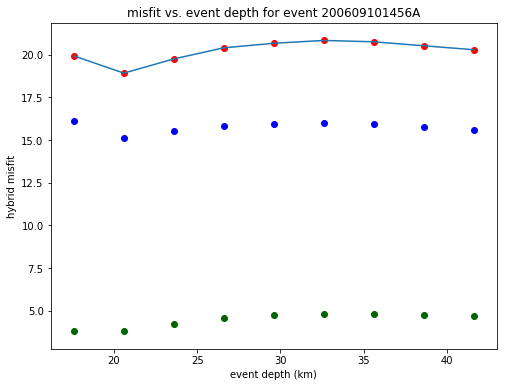

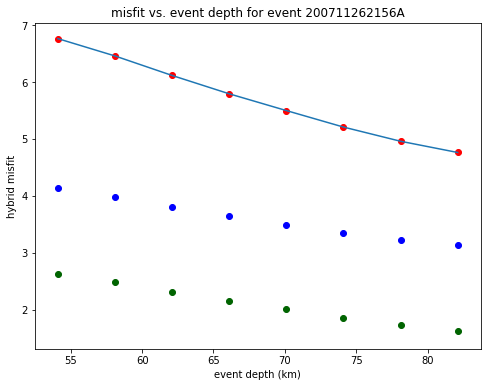

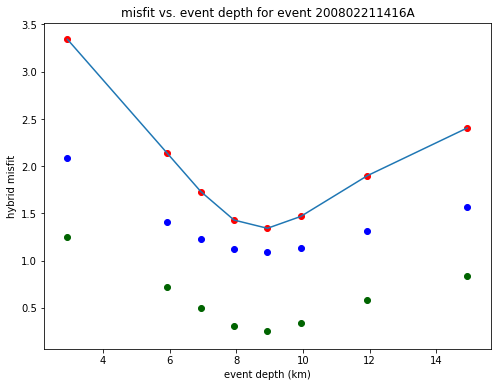

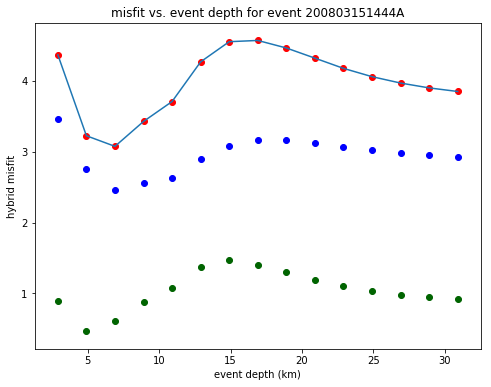

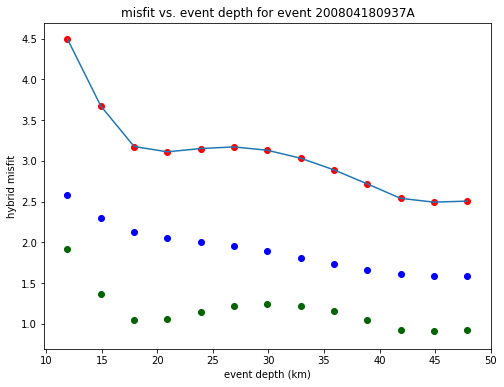

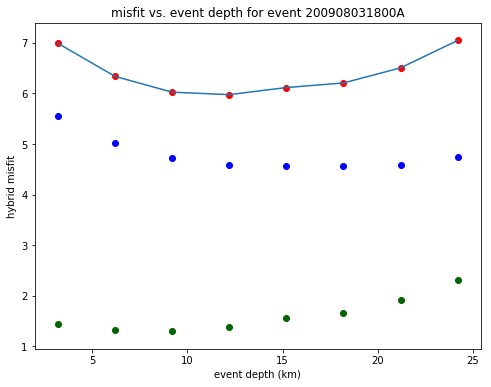

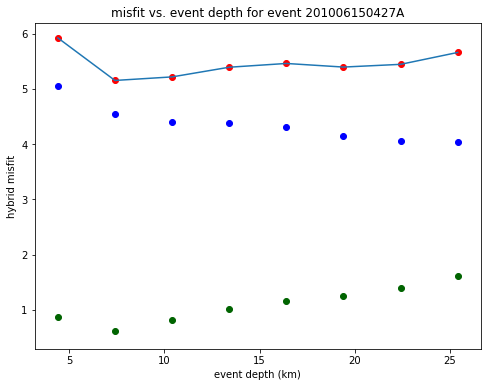

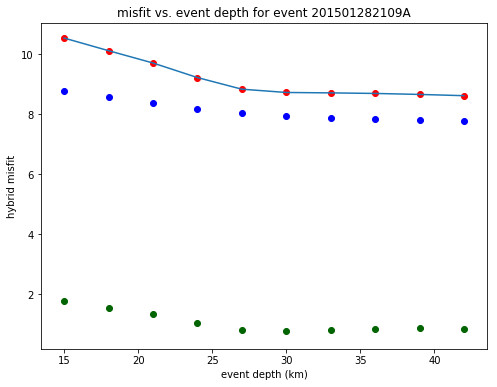

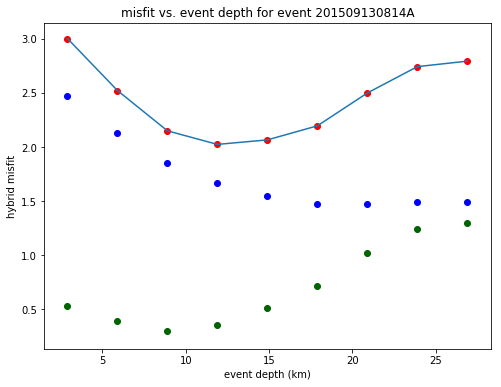

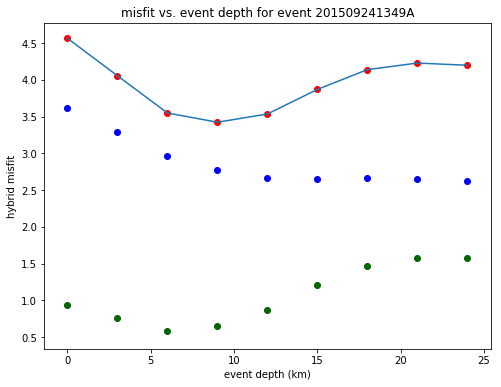

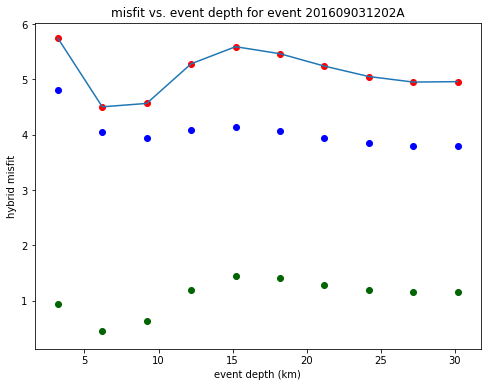

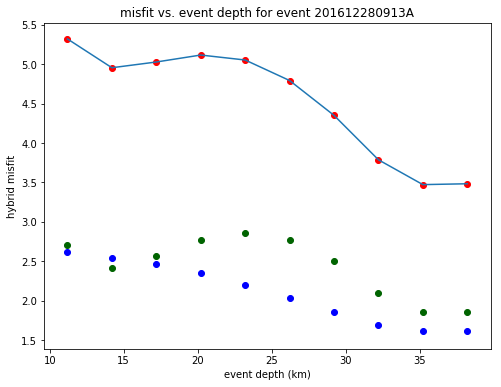

In [11]:
#%store -r
event_list_file = "evtlst.txt"
print(os.path.abspath('.'))
#os.chdir('..')
#print(Eca_all)
#print(Esa_all)

for ievt in open(event_list_file,'r').readlines():
    evtnm = ievt.strip()
    Eca = Eca_all[evtnm]
    Esa = Esa_all[evtnm]
    Ecnorm = Eca / (np.amax(Eca)-np.amin(Eca))
    Esnorm = Esa / (np.amax(Esa)-np.amin(Esa))
    misfit = Ecnorm + Esnorm
    
    os.chdir("cmt3d_syn_"+evtnm)
    cal_dirs = get_dirs("dep_pert_search")      # get run directories for that single event
    pert_list = []
    for idir in cal_dirs:
        ipert = idir.strip().split("/")[2]
        pert_list.append(ipert.strip().split("_")[1])
    parlist = pert_list
    evdp,_,_,_,_,_,_,_,_ = read_cmt("CMTSOLUTION")
    depth = np.zeros((len(pert_list)))
    for i in range(0,len(pert_list)):
        pert_sign = pert_list[i].strip()[0]
        pert_val = pert_list[i].strip()[1:]
        if(pert_sign=='d'):
            depth[i] = evdp + int(pert_val)
        elif(pert_sign=='u'):
            depth[i] = evdp - int(pert_val)
        else:
            depth[i] = evdp
    result = dict(zip(depth,parlist))
    depth = sorted(result.keys())
    parlist = itemgetter(*depth)(result)
    depth = list(depth)
    parlist = list(parlist)
    print(depth)
    print(parlist)
    
    plt.figure(figsize=(8,6))
    plt.plot(depth,misfit)
    for i in range(0,len(misfit)):
        plt.scatter(depth[i],misfit[i],color='red')
        plt.scatter(depth[i],Ecnorm[i],color='blue')
        plt.scatter(depth[i],Esnorm[i],color='darkgreen')
    plt.title('misfit vs. event depth for event '+evtnm)
    plt.xlabel('event depth (km)')
    plt.ylabel('hybrid misfit')
    
    os.chdir('..')
    

In [20]:
import time
event_list_file = "evtlst.txt"
basedir = "/work/05880/tg851792/stampede2/WUS/CMT_inversion_test"
model_dir = '/work/05880/tg851792/stampede2/WUS/new_region_us2016hybrid'
print(Eca_all)

{'200609101456A': array([ 0.38808386,  0.38682312,  0.38948973,  0.38178448,  0.38804944,
        0.38761395,  0.3890272 ,  0.39651113,  0.39729729]), '200711262156A': array([ 0.09905962,  0.09842507,  0.09737294,  0.09634029,  0.09539718,
        0.09432005,  0.09316767,  0.09206463]), '200802211416A': array([ 0.23171217,  0.18152616,  0.16929408,  0.15991828,  0.15521118,
        0.15429404,  0.1608126 ,  0.17652021]), '200803151444A': array([ 0.06894263,  0.06100416,  0.05674987,  0.05632974,  0.05662783,
        0.05983494,  0.06333156,  0.06656889,  0.06929983,  0.07063053,
        0.07116234,  0.07120679,  0.07081114,  0.07029502,  0.06984161]), '200804180937A': array([ 0.13132015,  0.12575875,  0.12115225,  0.11810192,  0.11606779,
        0.11465716,  0.10908092,  0.10778631,  0.10636425,  0.10490513,
        0.10458284,  0.10381559,  0.10359499]), '200908031800A': array([ 2.86180205,  2.57214912,  2.39062391,  2.30809144,  2.30712035,
        2.33514197,  2.38615562,  2.515648

In [21]:
import json
print(os.path.abspath('.'))
#os.chdir('..')
print(misfit_all)
##### save the synthetics 
file_eca = open("grid_search_Eca_"+str(pmin)+"_"+str(pmax)+".txt",'w')
file_esa = open("grid_search_Esa_"+str(pmin)+"_"+str(pmax)+".txt",'w')
file_depth = open("grid_search_depth_"+str(pmin)+"_"+str(pmax)+".txt",'w')
event_list_file = "evtlst.txt"
for ievt in open(event_list_file,'r').readlines():
    evtnm = ievt.strip()
    file_eca.writelines(str(evtnm)+" "+str(Eca_all[evtnm])+"\n")
    file_esa.writelines(str(evtnm)+" "+str(Esa_all[evtnm])+"\n")
    file_depth.writelines(str(evtnm)+" "+str(depth_all[evtnm])+"\n")
    
file_eca.close()
file_esa.close()
file_depth.close()

/work/05880/tg851792/stampede2/WUS/CMT_inversion_test
{'200609101456A': array([ 27.34705745,  27.2476127 ,  27.71193028,  27.49885345,
        28.10142885,  28.20095026,  28.36290867,  28.87212918,  28.91629407]), '200711262156A': array([ 16.78553963,  16.59122424,  16.31308926,  16.02128229,
        15.73338082,  15.41947117,  15.09558547,  14.78553963]), '200802211416A': array([ 4.2977684 ,  3.12672091,  2.76475857,  2.46314706,  2.30961494,
        2.3244653 ,  2.61975495,  3.05536216]), '200803151444A': array([ 5.27130156,  4.41541831,  4.19818448,  4.41327286,  4.58133678,
        5.09869049,  5.51915147,  5.7894663 ,  5.93362891,  5.93702787,
        5.87310836,  5.78172004,  5.67533347,  5.57349898,  5.48823787]), '200804180937A': array([ 6.49000748,  5.83973215,  5.3080943 ,  5.05430336,  4.93988032,
        4.89394873,  4.70976333,  4.67142602,  4.62412741,  4.5661246 ,
        4.54334784,  4.5487365 ,  4.54761044]), '200908031800A': array([ 6.50994051,  5.88804729,  5.5428549

In [8]:
%store win_all > grid_search_results_20_80_win.txt
%store Eca_all > grid_search_results_20_80_Eca.txt
%store Esa_all > grid_search_results_20_80_Esa.txt
%store depth_all > grid_search_results_20_80_depth.txt
%store Ecbin_all > grid_search_results_20_80_azistats.txt
%store Esbin_all >> grid_search_results_20_80_azistats.txt
%store naz_all >> grid_search_results_20_80_azistats.txt
%store manual_check > grid_search_results_20_80_manualcheck.txt

Writing 'win_all' (dict) to file 'grid_search_results_20_80_win.txt'.
Writing 'Eca_all' (dict) to file 'grid_search_results_20_80_Eca.txt'.
Writing 'Esa_all' (dict) to file 'grid_search_results_20_80_Esa.txt'.
Writing 'depth_all' (dict) to file 'grid_search_results_20_80_depth.txt'.
Writing 'Ecbin_all' (dict) to file 'grid_search_results_20_80_azistats.txt'.
Writing 'Esbin_all' (dict) to file 'grid_search_results_20_80_azistats.txt'.
Writing 'naz_all' (dict) to file 'grid_search_results_20_80_azistats.txt'.
Writing 'manual_check' (list) to file 'grid_search_results_20_80_manualcheck.txt'.


In [10]:
os.chdir('..')